In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import tensorflow as tf
import numpy as np
from tqdm import tqdm
from lightkurve import KeplerTargetPixelFile

In [3]:
class Gaussian2D:
    def __init__(self, x, y):
        self.x = x
        self.y = y
        if self.x.shape != self.y.shape:
            raise ValueError("Grid coordinates have the wrong shapes. Got {} and {}".
                             format(self.x.shape, self.y.shape))

    def __call__(self, *params):
        return self.evaluate(*params)

    def evaluate(self, A, xo, yo, a, b, c, B):
        p = tf.exp(-(a * (self.x - xo) ** 2
                     + 2 * b * (self.x - xo) * (self.y - yo)
                     + c * (self.y - yo) ** 2))
        p_sum = tf.reduce_sum(p)
        return A * p / p_sum + B

In [4]:
tabby = KeplerTargetPixelFile.from_archive(8462852, quarter=8)

INFO: Found cached file ./mastDownload/Kepler/kplr008462852_lc_Q111111111111111111/kplr008462852-2011073133259_lpd-targ.fits.gz with expected size 6000827. [astroquery.query]


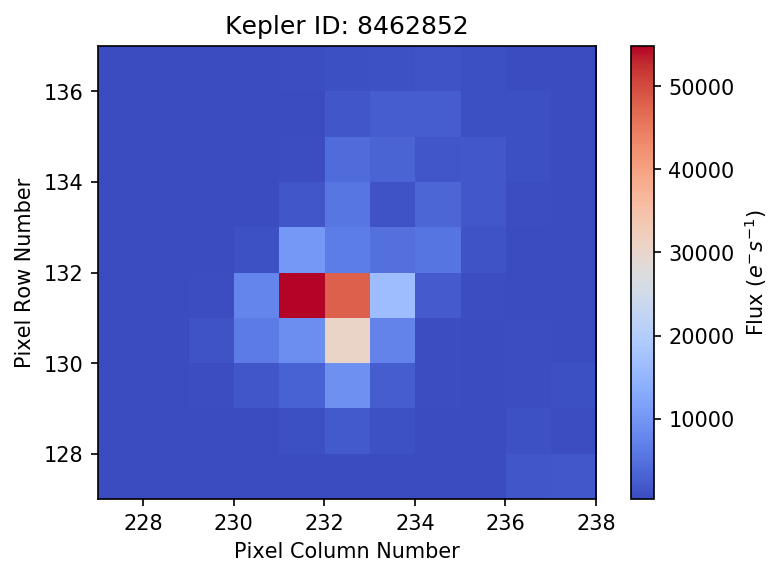

In [5]:
tabby.plot(scale=None, bkg=True, cmap='coolwarm')

In [6]:
col_ref, row_ref = tabby.column, tabby.row
y, x = np.mgrid[row_ref:row_ref+tabby.shape[-2]-1:tabby.shape[-2]*1j,
                col_ref:col_ref+tabby.shape[-1]-1:tabby.shape[-1]*1j]

In [7]:
gauss2D = Gaussian2D(x, y)

In [8]:
sess = tf.Session()
sess.run(fetches=tf.global_variables_initializer())

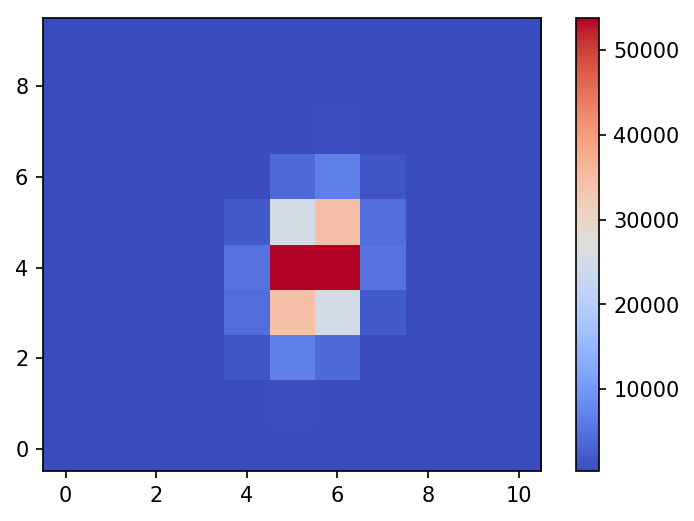

In [9]:
plt.imshow(sess.run(gauss2D(np.sum(tabby.flux[0]),
                            col_ref+5.5, row_ref+4, 1.2, -.15, .6, np.mean(tabby.flux_bkg[0]))),
           origin='lower', cmap='coolwarm')
plt.colorbar()

In [32]:
flux = tf.Variable(np.sum(tabby.flux[0]),
                   dtype=tf.float64, name='flux')
col = tf.Variable(col_ref+5.5, dtype=tf.float64, name='col')
row = tf.Variable(row_ref+4, dtype=tf.float64, name='row')
a = tf.Variable(1.2, dtype=tf.float64, name='a')
b = tf.Variable(-.15, dtype=tf.float64, name='b')
c = tf.Variable(.6, dtype=tf.float64, name='c')
bkg = tf.Variable(np.mean(tabby.flux_bkg[0]), dtype=tf.float64, name='bkg')

In [33]:
mean = gauss2D(flux, col, row, a, b, c, bkg)

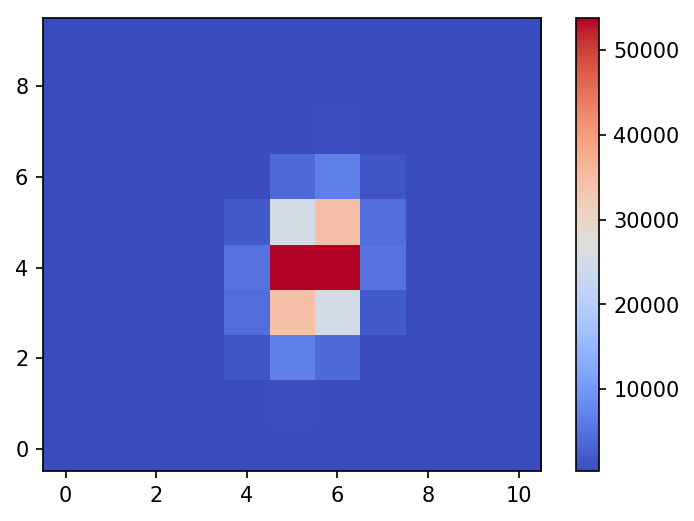

In [34]:
sess.run(fetches=tf.global_variables_initializer())
plt.imshow(sess.run(mean), origin='lower', cmap='coolwarm')
plt.colorbar()

In [35]:
f = tf.placeholder(dtype=tf.float64)
# Poisson likelihood
negloglike = tf.reduce_sum(tf.subtract(mean, tf.multiply(f, tf.log(mean))))

In [36]:
grad = tf.gradients(negloglike, [flux, col, row, a, b, c, bkg])

In [37]:
sess = tf.Session()
sess.run(fetches=tf.global_variables_initializer())

In [38]:
opt_params = []
opt_grad = []
optimizer = tf.contrib.opt.ScipyOptimizerInterface(loss=negloglike,
                                                   var_list=[flux, col, row, a, b, c, bkg],
                                                   method='BFGS')
for n in tqdm(range(tabby.shape[0])):
    optimizer.minimize(session=sess, feed_dict={f: tabby.flux[n] + tabby.flux_bkg[n]})
    opt_params.append([sess.run(flux), sess.run(col), sess.run(row),
                       sess.run(a), sess.run(b), sess.run(c), sess.run(bkg)])
    opt_grad.append(sess.run(grad, feed_dict={f: tabby.flux[n] + tabby.flux_bkg[n]}))

  0%|          | 0/3113 [00:00<?, ?it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2487523.026129
  Number of iterations: 48
  Number of functions evaluations: 59


  0%|          | 1/3113 [00:00<20:57,  2.47it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488138.668344
  Number of iterations: 32
  Number of functions evaluations: 100


  0%|          | 2/3113 [00:00<13:34,  3.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488167.490376
  Number of iterations: 37
  Number of functions evaluations: 110


  0%|          | 3/3113 [00:00<11:20,  4.57it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2487952.954433
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488658.654644
  Number of iterations: 27
  Number of functions evaluations: 41


  0%|          | 5/3113 [00:00<08:07,  6.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488446.649481
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2488657.453417
  Number of iterations: 26
  Number of functions evaluations: 44


  0%|          | 7/3113 [00:00<06:46,  7.63it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2488684.218148
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488518.964443
  Number of iterations: 13
  Number of functions evaluations: 83


  0%|          | 9/3113 [00:01<06:18,  8.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489093.966274
  Number of iterations: 33
  Number of functions evaluations: 142
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489296.219187
  Number of iterations: 28
  Number of functions evaluations: 46


  0%|          | 11/3113 [00:01<06:23,  8.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489232.305801
  Number of iterations: 31
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489469.615967
  Number of iterations: 25
  Number of functions evaluations: 42


  0%|          | 13/3113 [00:01<05:59,  8.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489765.226646
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489503.742653
  Number of iterations: 38
  Number of functions evaluations: 47


  0%|          | 15/3113 [00:01<05:44,  9.00it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489731.720309
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489980.818547
  Number of iterations: 37
  Number of functions evaluations: 82


  1%|          | 17/3113 [00:01<05:39,  9.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490112.388344
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490107.981818
  Number of iterations: 35
  Number of functions evaluations: 49


  1%|          | 19/3113 [00:01<05:23,  9.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490166.275290
  Number of iterations: 35
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490176.918298
  Number of iterations: 37
  Number of functions evaluations: 101


  1%|          | 21/3113 [00:02<05:33,  9.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490243.316712
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490276.318289
  Number of iterations: 38
  Number of functions evaluations: 47


  1%|          | 23/3113 [00:02<05:24,  9.52it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490051.015993
  Number of iterations: 25
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490286.943905
  Number of iterations: 39
  Number of functions evaluations: 49


  1%|          | 25/3113 [00:02<05:15,  9.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490645.933589
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490808.126003
  Number of iterations: 25
  Number of functions evaluations: 45


  1%|          | 27/3113 [00:02<05:06, 10.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491108.292368
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490608.375005
  Number of iterations: 37
  Number of functions evaluations: 49


  1%|          | 29/3113 [00:02<04:58, 10.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490894.364048
  Number of iterations: 38
  Number of functions evaluations: 118
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2491473.919564
  Number of iterations: 39
  Number of functions evaluations: 49


  1%|          | 31/3113 [00:03<04:59, 10.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491605.757290
  Number of iterations: 35
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491272.324544
  Number of iterations: 33
  Number of functions evaluations: 49


  1%|          | 33/3113 [00:03<04:59, 10.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2491611.473769
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491193.289567
  Number of iterations: 21
  Number of functions evaluations: 97


  1%|          | 35/3113 [00:03<04:57, 10.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2491627.981443
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491826.259569
  Number of iterations: 33
  Number of functions evaluations: 48


  1%|          | 37/3113 [00:03<04:51, 10.54it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491777.379789
  Number of iterations: 36
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492087.250904
  Number of iterations: 8
  Number of functions evaluations: 84


  1%|▏         | 39/3113 [00:03<04:54, 10.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492510.850768
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492179.106010
  Number of iterations: 25
  Number of functions evaluations: 40


  1%|▏         | 41/3113 [00:03<04:49, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492591.624245
  Number of iterations: 33
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492694.903226
  Number of iterations: 28
  Number of functions evaluations: 109


  1%|▏         | 43/3113 [00:04<04:49, 10.62it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492590.919882
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492631.529646
  Number of iterations: 14
  Number of functions evaluations: 24


  1%|▏         | 45/3113 [00:04<04:43, 10.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492801.160452
  Number of iterations: 28
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492663.549420
  Number of iterations: 20
  Number of functions evaluations: 38


  2%|▏         | 47/3113 [00:04<04:38, 11.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492964.634320
  Number of iterations: 33
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492530.220375
  Number of iterations: 39
  Number of functions evaluations: 52


  2%|▏         | 49/3113 [00:04<04:34, 11.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492654.301448
  Number of iterations: 36
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492867.261749
  Number of iterations: 38
  Number of functions evaluations: 51


  2%|▏         | 51/3113 [00:04<04:35, 11.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492806.540095
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493151.030917
  Number of iterations: 33
  Number of functions evaluations: 126


  2%|▏         | 53/3113 [00:04<04:36, 11.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493132.226337
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493250.424032
  Number of iterations: 29
  Number of functions evaluations: 40


  2%|▏         | 55/3113 [00:04<04:32, 11.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493090.496766
  Number of iterations: 36
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493553.922924
  Number of iterations: 27
  Number of functions evaluations: 44


  2%|▏         | 57/3113 [00:05<04:29, 11.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493334.043481
  Number of iterations: 9
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493963.086294
  Number of iterations: 40
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493485.821501
  Number of iterations: 36
  Number of functions evaluations: 45


  2%|▏         | 60/3113 [00:05<04:24, 11.56it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493437.734388
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493588.900551
  Number of iterations: 38
  Number of functions evaluations: 50


  2%|▏         | 62/3113 [00:05<04:21, 11.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493327.882182
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493286.079106
  Number of iterations: 19
  Number of functions evaluations: 35


  2%|▏         | 64/3113 [00:05<04:18, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493965.943749
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493817.657429
  Number of iterations: 38
  Number of functions evaluations: 50


  2%|▏         | 66/3113 [00:05<04:16, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493789.956431
  Number of iterations: 17
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494059.174943
  Number of iterations: 36
  Number of functions evaluations: 97


  2%|▏         | 68/3113 [00:05<04:16, 11.88it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493390.424848
  Number of iterations: 36
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494154.985436
  Number of iterations: 33
  Number of functions evaluations: 107


  2%|▏         | 70/3113 [00:05<04:20, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493589.362573
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493662.908177
  Number of iterations: 33
  Number of functions evaluations: 45


  2%|▏         | 72/3113 [00:06<04:18, 11.78it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494066.472548
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494124.759658
  Number of iterations: 27
  Number of functions evaluations: 102


  2%|▏         | 74/3113 [00:06<04:18, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494231.187374
  Number of iterations: 31
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494438.903601
  Number of iterations: 37
  Number of functions evaluations: 48


  2%|▏         | 76/3113 [00:06<04:19, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493930.078373
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493950.270722
  Number of iterations: 33
  Number of functions evaluations: 111


  3%|▎         | 78/3113 [00:06<04:20, 11.66it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494933.205916
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494643.446112
  Number of iterations: 30
  Number of functions evaluations: 83


  3%|▎         | 80/3113 [00:06<04:19, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494571.473670
  Number of iterations: 24
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494437.462058
  Number of iterations: 37
  Number of functions evaluations: 102


  3%|▎         | 82/3113 [00:07<04:19, 11.69it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494610.015575
  Number of iterations: 32
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494422.963838
  Number of iterations: 30
  Number of functions evaluations: 44


  3%|▎         | 84/3113 [00:07<04:18, 11.71it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495088.807400
  Number of iterations: 35
  Number of functions evaluations: 130
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494265.865050
  Number of iterations: 21
  Number of functions evaluations: 39


  3%|▎         | 86/3113 [00:07<04:19, 11.65it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494591.402314
  Number of iterations: 34
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494619.652962
  Number of iterations: 39
  Number of functions evaluations: 47


  3%|▎         | 88/3113 [00:07<04:17, 11.73it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494496.184413
  Number of iterations: 23
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494933.068446
  Number of iterations: 39
  Number of functions evaluations: 160


  3%|▎         | 90/3113 [00:07<04:21, 11.55it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494463.387092
  Number of iterations: 31
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494630.878634
  Number of iterations: 31
  Number of functions evaluations: 53


  3%|▎         | 92/3113 [00:07<04:22, 11.53it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494321.977421
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494414.147060
  Number of iterations: 23
  Number of functions evaluations: 40


  3%|▎         | 94/3113 [00:08<04:20, 11.61it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494396.264987
  Number of iterations: 22
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492909.633519
  Number of iterations: 11
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494715.343280
  Number of iterations: 39
  Number of functions evaluations: 50


  3%|▎         | 97/3113 [00:08<04:16, 11.75it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494824.382172
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495286.085979
  Number of iterations: 9
  Number of functions evaluations: 23


  3%|▎         | 99/3113 [00:08<04:14, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494806.111683
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494874.470447
  Number of iterations: 36
  Number of functions evaluations: 48


  3%|▎         | 101/3113 [00:08<04:13, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494867.847749
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495111.346396
  Number of iterations: 39
  Number of functions evaluations: 51


  3%|▎         | 103/3113 [00:08<04:11, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494924.918964
  Number of iterations: 33
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494730.880894
  Number of iterations: 34
  Number of functions evaluations: 46


  3%|▎         | 105/3113 [00:08<04:12, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495083.243554
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494862.268437
  Number of iterations: 12
  Number of functions evaluations: 25


  3%|▎         | 107/3113 [00:08<04:11, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494603.010615
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495236.290613
  Number of iterations: 38
  Number of functions evaluations: 50


  4%|▎         | 109/3113 [00:09<04:10, 11.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494618.965497
  Number of iterations: 20
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494140.062672
  Number of iterations: 33
  Number of functions evaluations: 118


  4%|▎         | 111/3113 [00:09<04:12, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495079.464115
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495213.974461
  Number of iterations: 27
  Number of functions evaluations: 98


  4%|▎         | 113/3113 [00:09<04:13, 11.84it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494875.270205
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495008.750764
  Number of iterations: 30
  Number of functions evaluations: 91


  4%|▎         | 115/3113 [00:09<04:13, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494844.738426
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495423.064983
  Number of iterations: 34
  Number of functions evaluations: 96


  4%|▍         | 117/3113 [00:09<04:13, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495372.680174
  Number of iterations: 36
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495087.881830
  Number of iterations: 36
  Number of functions evaluations: 49


  4%|▍         | 119/3113 [00:10<04:12, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495223.498717
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495340.691078
  Number of iterations: 23
  Number of functions evaluations: 48


  4%|▍         | 121/3113 [00:10<04:12, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495364.931670
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495844.883707
  Number of iterations: 35
  Number of functions evaluations: 90


  4%|▍         | 123/3113 [00:10<04:12, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495912.529387
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495987.130016
  Number of iterations: 16
  Number of functions evaluations: 28


  4%|▍         | 125/3113 [00:10<04:10, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496252.369827
  Number of iterations: 39
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495625.069897
  Number of iterations: 37
  Number of functions evaluations: 109


  4%|▍         | 127/3113 [00:10<04:12, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495923.568546
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495865.354111
  Number of iterations: 30
  Number of functions evaluations: 89


  4%|▍         | 129/3113 [00:10<04:12, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495651.047371
  Number of iterations: 29
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495679.747784
  Number of iterations: 31
  Number of functions evaluations: 46


  4%|▍         | 131/3113 [00:11<04:11, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496149.122672
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495744.596000
  Number of iterations: 36
  Number of functions evaluations: 50


  4%|▍         | 133/3113 [00:11<04:10, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495803.465534
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496324.953903
  Number of iterations: 39
  Number of functions evaluations: 49


  4%|▍         | 135/3113 [00:11<04:09, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496016.543851
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495950.223442
  Number of iterations: 35
  Number of functions evaluations: 108


  4%|▍         | 137/3113 [00:11<04:10, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496030.042518
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496055.074458
  Number of iterations: 28
  Number of functions evaluations: 129


  4%|▍         | 139/3113 [00:11<04:11, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496044.490613
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496341.712068
  Number of iterations: 38
  Number of functions evaluations: 103


  5%|▍         | 141/3113 [00:11<04:11, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495684.980565
  Number of iterations: 23
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496275.026877
  Number of iterations: 39
  Number of functions evaluations: 102


  5%|▍         | 143/3113 [00:12<04:11, 11.79it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496241.927385
  Number of iterations: 20
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496382.130062
  Number of iterations: 37
  Number of functions evaluations: 108


  5%|▍         | 145/3113 [00:12<04:12, 11.77it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496459.982028
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496885.655662
  Number of iterations: 33
  Number of functions evaluations: 47


  5%|▍         | 147/3113 [00:12<04:10, 11.82it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496414.304239
  Number of iterations: 29
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496471.316236
  Number of iterations: 38
  Number of functions evaluations: 49


  5%|▍         | 149/3113 [00:12<04:10, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496270.990935
  Number of iterations: 37
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496314.022016
  Number of iterations: 14
  Number of functions evaluations: 74


  5%|▍         | 151/3113 [00:12<04:10, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496354.235438
  Number of iterations: 15
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495888.121558
  Number of iterations: 39
  Number of functions evaluations: 52


  5%|▍         | 153/3113 [00:12<04:09, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496062.420658
  Number of iterations: 36
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496287.935972
  Number of iterations: 39
  Number of functions evaluations: 47


  5%|▍         | 155/3113 [00:13<04:08, 11.91it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495405.940625
  Number of iterations: 30
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496467.766035
  Number of iterations: 39
  Number of functions evaluations: 49


  5%|▌         | 157/3113 [00:13<04:08, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496320.991528
  Number of iterations: 17
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496145.351852
  Number of iterations: 25
  Number of functions evaluations: 43


  5%|▌         | 159/3113 [00:13<04:08, 11.90it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496432.618580
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496354.014305
  Number of iterations: 37
  Number of functions evaluations: 50


  5%|▌         | 161/3113 [00:13<04:07, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496288.669738
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496555.788094
  Number of iterations: 36
  Number of functions evaluations: 91


  5%|▌         | 163/3113 [00:13<04:07, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496823.630372
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497175.265215
  Number of iterations: 33
  Number of functions evaluations: 43


  5%|▌         | 165/3113 [00:13<04:06, 11.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496949.241843
  Number of iterations: 13
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497039.678923
  Number of iterations: 22
  Number of functions evaluations: 39


  5%|▌         | 167/3113 [00:13<04:06, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496942.681234
  Number of iterations: 13
  Number of functions evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497706.090321
  Number of iterations: 38
  Number of functions evaluations: 119


  5%|▌         | 169/3113 [00:14<04:07, 11.89it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496864.808434
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497428.814178
  Number of iterations: 35
  Number of functions evaluations: 186


  5%|▌         | 171/3113 [00:14<04:09, 11.81it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497408.525452
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497283.031846
  Number of iterations: 24
  Number of functions evaluations: 40


  6%|▌         | 173/3113 [00:14<04:08, 11.85it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497771.133499
  Number of iterations: 38
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497606.456419
  Number of iterations: 30
  Number of functions evaluations: 46


  6%|▌         | 175/3113 [00:14<04:08, 11.83it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497127.198487
  Number of iterations: 27
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497537.945797
  Number of iterations: 38
  Number of functions evaluations: 48


  6%|▌         | 177/3113 [00:14<04:07, 11.87it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497299.026110
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497161.145650
  Number of iterations: 13
  Number of functions evaluations: 24


  6%|▌         | 179/3113 [00:15<04:06, 11.92it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496947.332000
  Number of iterations: 13
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497175.109572
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497111.313129
  Number of iterations: 37
  Number of functions evaluations: 48


  6%|▌         | 182/3113 [00:15<04:04, 11.99it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497456.470233
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497603.520212
  Number of iterations: 38
  Number of functions evaluations: 52


  6%|▌         | 184/3113 [00:15<04:03, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497790.975098
  Number of iterations: 36
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497858.036767
  Number of iterations: 33
  Number of functions evaluations: 108


  6%|▌         | 186/3113 [00:15<04:05, 11.93it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497582.930893
  Number of iterations: 26
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497915.543726
  Number of iterations: 38
  Number of functions evaluations: 48


  6%|▌         | 188/3113 [00:15<04:04, 11.96it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497427.558699
  Number of iterations: 38
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497445.151339
  Number of iterations: 38
  Number of functions evaluations: 50


  6%|▌         | 190/3113 [00:15<04:04, 11.94it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497545.365998
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497767.941601
  Number of iterations: 33
  Number of functions evaluations: 49


  6%|▌         | 192/3113 [00:16<04:03, 11.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497652.261038
  Number of iterations: 30
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497889.201364
  Number of iterations: 37
  Number of functions evaluations: 48


  6%|▌         | 194/3113 [00:16<04:03, 11.97it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497952.152387
  Number of iterations: 11
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497200.575001
  Number of iterations: 17
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497665.966567
  Number of iterations: 12
  Number of functions evaluations: 24


  6%|▋         | 197/3113 [00:16<04:01, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496876.266641
  Number of iterations: 34
  Number of functions evaluations: 84
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497538.887459
  Number of iterations: 24
  Number of functions evaluations: 40


  6%|▋         | 199/3113 [00:16<04:01, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497556.064168
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497531.275377
  Number of iterations: 28
  Number of functions evaluations: 116


  6%|▋         | 201/3113 [00:16<04:02, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497663.793544
  Number of iterations: 35
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497688.687656
  Number of iterations: 38
  Number of functions evaluations: 48


  7%|▋         | 203/3113 [00:16<04:01, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497413.152836
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497832.033591
  Number of iterations: 39
  Number of functions evaluations: 90


  7%|▋         | 205/3113 [00:17<04:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497555.142823
  Number of iterations: 30
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497405.439701
  Number of iterations: 38
  Number of functions evaluations: 51


  7%|▋         | 207/3113 [00:17<04:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497648.885065
  Number of iterations: 37
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497741.658194
  Number of iterations: 36
  Number of functions evaluations: 46


  7%|▋         | 209/3113 [00:17<04:01, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498002.832676
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498001.925058
  Number of iterations: 33
  Number of functions evaluations: 51


  7%|▋         | 211/3113 [00:17<04:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498095.543655
  Number of iterations: 24
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498251.416180
  Number of iterations: 29
  Number of functions evaluations: 45


  7%|▋         | 213/3113 [00:17<04:00, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498468.692718
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497789.023800
  Number of iterations: 35
  Number of functions evaluations: 47


  7%|▋         | 215/3113 [00:17<03:59, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497782.915137
  Number of iterations: 19
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497849.060967
  Number of iterations: 38
  Number of functions evaluations: 51


  7%|▋         | 217/3113 [00:17<03:58, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497681.699884
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498114.244624
  Number of iterations: 33
  Number of functions evaluations: 101


  7%|▋         | 219/3113 [00:18<03:58, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497917.590877
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497767.028287
  Number of iterations: 29
  Number of functions evaluations: 46


  7%|▋         | 221/3113 [00:18<03:57, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498032.592866
  Number of iterations: 36
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498566.717263
  Number of iterations: 37
  Number of functions evaluations: 47


  7%|▋         | 223/3113 [00:18<03:58, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498393.371642
  Number of iterations: 33
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498513.644334
  Number of iterations: 36
  Number of functions evaluations: 47


  7%|▋         | 225/3113 [00:18<03:58, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498628.875282
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498391.453989
  Number of iterations: 29
  Number of functions evaluations: 45


  7%|▋         | 227/3113 [00:18<03:57, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498966.841616
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498828.049293
  Number of iterations: 27
  Number of functions evaluations: 109


  7%|▋         | 229/3113 [00:18<03:57, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498812.402426
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499285.311480
  Number of iterations: 33
  Number of functions evaluations: 44


  7%|▋         | 231/3113 [00:18<03:57, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499092.573744
  Number of iterations: 21
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499179.711681
  Number of iterations: 28
  Number of functions evaluations: 95


  7%|▋         | 233/3113 [00:19<03:56, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498993.088009
  Number of iterations: 37
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498800.818368
  Number of iterations: 38
  Number of functions evaluations: 48


  8%|▊         | 235/3113 [00:19<03:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499149.059064
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499786.051735
  Number of iterations: 31
  Number of functions evaluations: 113


  8%|▊         | 237/3113 [00:19<03:56, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499089.372253
  Number of iterations: 38
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499462.200574
  Number of iterations: 33
  Number of functions evaluations: 102


  8%|▊         | 239/3113 [00:19<03:56, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499774.581804
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499142.653476
  Number of iterations: 31
  Number of functions evaluations: 89


  8%|▊         | 241/3113 [00:19<03:56, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499137.625124
  Number of iterations: 38
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499630.563649
  Number of iterations: 26
  Number of functions evaluations: 43


  8%|▊         | 243/3113 [00:20<03:56, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499950.017679
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499974.645757
  Number of iterations: 35
  Number of functions evaluations: 47


  8%|▊         | 245/3113 [00:20<03:55, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499617.682514
  Number of iterations: 35
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499635.893023
  Number of iterations: 31
  Number of functions evaluations: 94


  8%|▊         | 247/3113 [00:20<03:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500137.158725
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498603.720339
  Number of iterations: 10
  Number of functions evaluations: 64


  8%|▊         | 249/3113 [00:20<03:56, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507113.242037
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500102.630626
  Number of iterations: 35
  Number of functions evaluations: 49


  8%|▊         | 251/3113 [00:20<03:55, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499527.400859
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499903.844084
  Number of iterations: 30
  Number of functions evaluations: 115


  8%|▊         | 253/3113 [00:20<03:55, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499557.654134
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499733.406854
  Number of iterations: 37
  Number of functions evaluations: 48


  8%|▊         | 255/3113 [00:20<03:55, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499206.528242
  Number of iterations: 32
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499284.502675
  Number of iterations: 37
  Number of functions evaluations: 50


  8%|▊         | 257/3113 [00:21<03:54, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499535.478088
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499367.309339
  Number of iterations: 38
  Number of functions evaluations: 48


  8%|▊         | 259/3113 [00:21<03:53, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499599.586152
  Number of iterations: 11
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499615.307440
  Number of iterations: 35
  Number of functions evaluations: 52


  8%|▊         | 261/3113 [00:21<03:53, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499616.232428
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499617.686521
  Number of iterations: 31
  Number of functions evaluations: 47


  8%|▊         | 263/3113 [00:21<03:52, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500042.236014
  Number of iterations: 36
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499925.421675
  Number of iterations: 34
  Number of functions evaluations: 47


  9%|▊         | 265/3113 [00:21<03:52, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499624.186192
  Number of iterations: 7
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500371.282402
  Number of iterations: 36
  Number of functions evaluations: 46


  9%|▊         | 267/3113 [00:21<03:51, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500428.363837
  Number of iterations: 35
  Number of functions evaluations: 56
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500031.459623
  Number of iterations: 31
  Number of functions evaluations: 45


  9%|▊         | 269/3113 [00:21<03:51, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500660.175393
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500358.109725
  Number of iterations: 37
  Number of functions evaluations: 46


  9%|▊         | 271/3113 [00:22<03:51, 12.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500360.438736
  Number of iterations: 31
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500525.649593
  Number of iterations: 13
  Number of functions evaluations: 24


  9%|▉         | 273/3113 [00:22<03:51, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500104.680981
  Number of iterations: 22
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500402.974715
  Number of iterations: 39
  Number of functions evaluations: 49


  9%|▉         | 275/3113 [00:22<03:51, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500238.969777
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501172.011824
  Number of iterations: 32
  Number of functions evaluations: 48


  9%|▉         | 277/3113 [00:22<03:50, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500309.677781
  Number of iterations: 29
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501035.429192
  Number of iterations: 22
  Number of functions evaluations: 40


  9%|▉         | 279/3113 [00:22<03:51, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500729.638226
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501059.838474
  Number of iterations: 37
  Number of functions evaluations: 47


  9%|▉         | 281/3113 [00:22<03:50, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500438.813345
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500685.956609
  Number of iterations: 29
  Number of functions evaluations: 46


  9%|▉         | 283/3113 [00:23<03:50, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500611.066541
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500441.196040
  Number of iterations: 6
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500971.132193
  Number of iterations: 37
  Number of functions evaluations: 49


  9%|▉         | 286/3113 [00:23<03:49, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500560.539920
  Number of iterations: 9
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500606.585193
  Number of iterations: 33
  Number of functions evaluations: 104


  9%|▉         | 288/3113 [00:23<03:48, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500592.449490
  Number of iterations: 21
  Number of functions evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501022.823737
  Number of iterations: 35
  Number of functions evaluations: 48


  9%|▉         | 290/3113 [00:23<03:48, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500545.820687
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500738.035896
  Number of iterations: 36
  Number of functions evaluations: 95


  9%|▉         | 292/3113 [00:23<03:48, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501247.410495
  Number of iterations: 39
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500947.779361
  Number of iterations: 23
  Number of functions evaluations: 98


  9%|▉         | 294/3113 [00:23<03:48, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501339.846432
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501074.007636
  Number of iterations: 27
  Number of functions evaluations: 76


 10%|▉         | 296/3113 [00:24<03:48, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501023.399552
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500572.813999
  Number of iterations: 35
  Number of functions evaluations: 47


 10%|▉         | 298/3113 [00:24<03:48, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500596.732535
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500695.194498
  Number of iterations: 33
  Number of functions evaluations: 49


 10%|▉         | 300/3113 [00:24<03:47, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500965.842720
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500622.841408
  Number of iterations: 27
  Number of functions evaluations: 90


 10%|▉         | 302/3113 [00:24<03:47, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500779.958885
  Number of iterations: 29
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500705.411204
  Number of iterations: 37
  Number of functions evaluations: 50


 10%|▉         | 304/3113 [00:24<03:47, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500949.529739
  Number of iterations: 24
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500757.974746
  Number of iterations: 38
  Number of functions evaluations: 93


 10%|▉         | 306/3113 [00:24<03:47, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501035.629379
  Number of iterations: 26
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500811.400296
  Number of iterations: 26
  Number of functions evaluations: 41


 10%|▉         | 308/3113 [00:24<03:46, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501246.380276
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501255.397264
  Number of iterations: 38
  Number of functions evaluations: 97


 10%|▉         | 310/3113 [00:25<03:46, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500618.490306
  Number of iterations: 21
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501211.813225
  Number of iterations: 38
  Number of functions evaluations: 139


 10%|█         | 312/3113 [00:25<03:47, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501195.201958
  Number of iterations: 8
  Number of functions evaluations: 84
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501215.621946
  Number of iterations: 33
  Number of functions evaluations: 48


 10%|█         | 314/3113 [00:25<03:46, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501900.458871
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501408.142987
  Number of iterations: 22
  Number of functions evaluations: 100


 10%|█         | 316/3113 [00:25<03:46, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501043.968663
  Number of iterations: 12
  Number of functions evaluations: 73
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501829.492093
  Number of iterations: 39
  Number of functions evaluations: 158


 10%|█         | 318/3113 [00:25<03:47, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501729.925437
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501344.025055
  Number of iterations: 30
  Number of functions evaluations: 44


 10%|█         | 320/3113 [00:26<03:47, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501514.841862
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501672.082849
  Number of iterations: 24
  Number of functions evaluations: 42


 10%|█         | 322/3113 [00:26<03:46, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501687.866417
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501281.518704
  Number of iterations: 11
  Number of functions evaluations: 24


 10%|█         | 324/3113 [00:26<03:46, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501391.548767
  Number of iterations: 27
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501741.072475
  Number of iterations: 32
  Number of functions evaluations: 98


 10%|█         | 326/3113 [00:26<03:46, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501502.842562
  Number of iterations: 18
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501001.749910
  Number of iterations: 39
  Number of functions evaluations: 50


 11%|█         | 328/3113 [00:26<03:46, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501298.547660
  Number of iterations: 32
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501367.952752
  Number of iterations: 12
  Number of functions evaluations: 57


 11%|█         | 330/3113 [00:26<03:46, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500800.878884
  Number of iterations: 29
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501246.459367
  Number of iterations: 32
  Number of functions evaluations: 47


 11%|█         | 332/3113 [00:27<03:46, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500759.001358
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500784.130082
  Number of iterations: 25
  Number of functions evaluations: 96


 11%|█         | 334/3113 [00:27<03:46, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500550.831624
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500668.750326
  Number of iterations: 35
  Number of functions evaluations: 227


 11%|█         | 336/3113 [00:27<03:47, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501129.419540
  Number of iterations: 26
  Number of functions evaluations: 68
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500668.823080
  Number of iterations: 36
  Number of functions evaluations: 50


 11%|█         | 338/3113 [00:27<03:47, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500769.699257
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500986.077573
  Number of iterations: 30
  Number of functions evaluations: 44


 11%|█         | 340/3113 [00:27<03:46, 12.24it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500992.604352
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500947.194240
  Number of iterations: 19
  Number of functions evaluations: 37


 11%|█         | 342/3113 [00:27<03:46, 12.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501218.640325
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501262.688279
  Number of iterations: 13
  Number of functions evaluations: 24


 11%|█         | 344/3113 [00:28<03:45, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500725.154597
  Number of iterations: 37
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501083.753558
  Number of iterations: 38
  Number of functions evaluations: 97


 11%|█         | 346/3113 [00:28<03:46, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500876.219836
  Number of iterations: 33
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500862.188924
  Number of iterations: 36
  Number of functions evaluations: 96


 11%|█         | 348/3113 [00:28<03:46, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500724.609310
  Number of iterations: 16
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500687.180629
  Number of iterations: 24
  Number of functions evaluations: 39


 11%|█         | 350/3113 [00:28<03:45, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501016.587157
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501422.251241
  Number of iterations: 27
  Number of functions evaluations: 40


 11%|█▏        | 352/3113 [00:28<03:45, 12.26it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501126.982572
  Number of iterations: 26
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501746.288208
  Number of iterations: 29
  Number of functions evaluations: 42


 11%|█▏        | 354/3113 [00:28<03:44, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501847.851948
  Number of iterations: 36
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501683.269296
  Number of iterations: 22
  Number of functions evaluations: 40


 11%|█▏        | 356/3113 [00:28<03:44, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501497.564698
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501893.194526
  Number of iterations: 38
  Number of functions evaluations: 51


 12%|█▏        | 358/3113 [00:29<03:43, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501570.517748
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501982.402531
  Number of iterations: 32
  Number of functions evaluations: 49


 12%|█▏        | 360/3113 [00:29<03:43, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501849.770950
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502100.818031
  Number of iterations: 11
  Number of functions evaluations: 83


 12%|█▏        | 362/3113 [00:29<03:43, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502157.516475
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502422.614141
  Number of iterations: 35
  Number of functions evaluations: 83


 12%|█▏        | 364/3113 [00:29<03:43, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502078.409425
  Number of iterations: 34
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502799.112423
  Number of iterations: 33
  Number of functions evaluations: 43


 12%|█▏        | 366/3113 [00:29<03:43, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502648.970348
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502468.173624
  Number of iterations: 26
  Number of functions evaluations: 42


 12%|█▏        | 368/3113 [00:29<03:42, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502403.167057
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502338.266483
  Number of iterations: 24
  Number of functions evaluations: 40


 12%|█▏        | 370/3113 [00:29<03:42, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502336.449430
  Number of iterations: 28
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502453.820026
  Number of iterations: 37
  Number of functions evaluations: 48


 12%|█▏        | 372/3113 [00:30<03:42, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502181.437907
  Number of iterations: 14
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501644.635601
  Number of iterations: 34
  Number of functions evaluations: 45


 12%|█▏        | 374/3113 [00:30<03:42, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501691.238754
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502182.701262
  Number of iterations: 38
  Number of functions evaluations: 52


 12%|█▏        | 376/3113 [00:30<03:41, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501976.760527
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502851.893860
  Number of iterations: 38
  Number of functions evaluations: 49


 12%|█▏        | 378/3113 [00:30<03:41, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502123.833201
  Number of iterations: 22
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502407.191258
  Number of iterations: 34
  Number of functions evaluations: 44


 12%|█▏        | 380/3113 [00:30<03:41, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502419.197324
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502101.228373
  Number of iterations: 23
  Number of functions evaluations: 39


 12%|█▏        | 382/3113 [00:30<03:40, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502537.684106
  Number of iterations: 38
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502653.466641
  Number of iterations: 25
  Number of functions evaluations: 43


 12%|█▏        | 384/3113 [00:31<03:40, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502489.807165
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503062.122573
  Number of iterations: 35
  Number of functions evaluations: 77


 12%|█▏        | 386/3113 [00:31<03:40, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502990.415660
  Number of iterations: 39
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502911.142032
  Number of iterations: 32
  Number of functions evaluations: 101


 12%|█▏        | 388/3113 [00:31<03:40, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503145.919086
  Number of iterations: 33
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503353.449842
  Number of iterations: 31
  Number of functions evaluations: 44


 13%|█▎        | 390/3113 [00:31<03:40, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503812.961939
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503467.419070
  Number of iterations: 34
  Number of functions evaluations: 50


 13%|█▎        | 392/3113 [00:31<03:39, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503342.575518
  Number of iterations: 29
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503548.209612
  Number of iterations: 36
  Number of functions evaluations: 111


 13%|█▎        | 394/3113 [00:31<03:40, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503270.058924
  Number of iterations: 33
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503617.302574
  Number of iterations: 24
  Number of functions evaluations: 97


 13%|█▎        | 396/3113 [00:32<03:40, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503806.663338
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503533.094393
  Number of iterations: 13
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503762.051197
  Number of iterations: 37
  Number of functions evaluations: 105


 13%|█▎        | 399/3113 [00:32<03:39, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503846.767480
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503829.170094
  Number of iterations: 36
  Number of functions evaluations: 49


 13%|█▎        | 401/3113 [00:32<03:39, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503996.182451
  Number of iterations: 35
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504658.431038
  Number of iterations: 37
  Number of functions evaluations: 158


 13%|█▎        | 403/3113 [00:32<03:39, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503958.131067
  Number of iterations: 18
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504363.211065
  Number of iterations: 38
  Number of functions evaluations: 57


 13%|█▎        | 405/3113 [00:32<03:39, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504176.884681
  Number of iterations: 26
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504529.159207
  Number of iterations: 33
  Number of functions evaluations: 45


 13%|█▎        | 407/3113 [00:32<03:38, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504843.305236
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504302.037818
  Number of iterations: 35
  Number of functions evaluations: 110


 13%|█▎        | 409/3113 [00:33<03:38, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504297.994710
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504444.737950
  Number of iterations: 39
  Number of functions evaluations: 54


 13%|█▎        | 411/3113 [00:33<03:38, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504565.307656
  Number of iterations: 30
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504385.322827
  Number of iterations: 38
  Number of functions evaluations: 52


 13%|█▎        | 413/3113 [00:33<03:38, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504181.636523
  Number of iterations: 38
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504125.242949
  Number of iterations: 33
  Number of functions evaluations: 43


 13%|█▎        | 415/3113 [00:33<03:38, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504392.657461
  Number of iterations: 40
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504338.671323
  Number of iterations: 25
  Number of functions evaluations: 43


 13%|█▎        | 417/3113 [00:33<03:38, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504201.453514
  Number of iterations: 11
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504687.842404
  Number of iterations: 30
  Number of functions evaluations: 43


 13%|█▎        | 419/3113 [00:33<03:38, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504365.197440
  Number of iterations: 24
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504476.017753
  Number of iterations: 31
  Number of functions evaluations: 47


 14%|█▎        | 421/3113 [00:34<03:38, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503926.306935
  Number of iterations: 29
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504384.412518
  Number of iterations: 35
  Number of functions evaluations: 50


 14%|█▎        | 423/3113 [00:34<03:38, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504135.906800
  Number of iterations: 30
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504466.483311
  Number of iterations: 37
  Number of functions evaluations: 46


 14%|█▎        | 425/3113 [00:34<03:37, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504400.997448
  Number of iterations: 14
  Number of functions evaluations: 70
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503860.394378
  Number of iterations: 37
  Number of functions evaluations: 49


 14%|█▎        | 427/3113 [00:34<03:37, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504421.694636
  Number of iterations: 35
  Number of functions evaluations: 69
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503576.658032
  Number of iterations: 28
  Number of functions evaluations: 105


 14%|█▍        | 429/3113 [00:34<03:37, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503935.700262
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503999.583943
  Number of iterations: 36
  Number of functions evaluations: 48


 14%|█▍        | 431/3113 [00:34<03:37, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503627.614961
  Number of iterations: 28
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503929.277497
  Number of iterations: 25
  Number of functions evaluations: 39


 14%|█▍        | 433/3113 [00:35<03:36, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503985.126076
  Number of iterations: 28
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503711.417097
  Number of iterations: 36
  Number of functions evaluations: 114


 14%|█▍        | 435/3113 [00:35<03:36, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503826.298334
  Number of iterations: 26
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504175.970574
  Number of iterations: 23
  Number of functions evaluations: 84


 14%|█▍        | 437/3113 [00:35<03:36, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504212.627754
  Number of iterations: 24
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504644.921662
  Number of iterations: 35
  Number of functions evaluations: 47


 14%|█▍        | 439/3113 [00:35<03:36, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504549.280012
  Number of iterations: 30
  Number of functions evaluations: 129
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504625.318032
  Number of iterations: 19
  Number of functions evaluations: 37


 14%|█▍        | 441/3113 [00:35<03:36, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504826.677645
  Number of iterations: 38
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505010.842857
  Number of iterations: 15
  Number of functions evaluations: 28


 14%|█▍        | 443/3113 [00:35<03:36, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504743.967680
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505157.802286
  Number of iterations: 38
  Number of functions evaluations: 51


 14%|█▍        | 445/3113 [00:35<03:35, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505157.818164
  Number of iterations: 37
  Number of functions evaluations: 155
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505226.358455
  Number of iterations: 33
  Number of functions evaluations: 43


 14%|█▍        | 447/3113 [00:36<03:36, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505511.918702
  Number of iterations: 36
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505354.868952
  Number of iterations: 37
  Number of functions evaluations: 94


 14%|█▍        | 449/3113 [00:36<03:36, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505708.555950
  Number of iterations: 36
  Number of functions evaluations: 82
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505666.289012
  Number of iterations: 23
  Number of functions evaluations: 35


 14%|█▍        | 451/3113 [00:36<03:35, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505786.743568
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506034.118504
  Number of iterations: 35
  Number of functions evaluations: 46


 15%|█▍        | 453/3113 [00:36<03:35, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505606.575462
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505776.818903
  Number of iterations: 25
  Number of functions evaluations: 74


 15%|█▍        | 455/3113 [00:36<03:35, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506189.502375
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506102.810630
  Number of iterations: 35
  Number of functions evaluations: 51


 15%|█▍        | 457/3113 [00:36<03:35, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505991.772232
  Number of iterations: 21
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506155.124065
  Number of iterations: 31
  Number of functions evaluations: 44


 15%|█▍        | 459/3113 [00:37<03:34, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506255.972883
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505921.105360
  Number of iterations: 29
  Number of functions evaluations: 94


 15%|█▍        | 461/3113 [00:37<03:34, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506632.013135
  Number of iterations: 29
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506152.681849
  Number of iterations: 30
  Number of functions evaluations: 48


 15%|█▍        | 463/3113 [00:37<03:34, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506324.564676
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506460.976225
  Number of iterations: 37
  Number of functions evaluations: 85


 15%|█▍        | 465/3113 [00:37<03:34, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506616.425112
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506767.768512
  Number of iterations: 37
  Number of functions evaluations: 45


 15%|█▌        | 467/3113 [00:37<03:33, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506165.680874
  Number of iterations: 16
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506395.560861
  Number of iterations: 12
  Number of functions evaluations: 71


 15%|█▌        | 469/3113 [00:37<03:33, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506552.000693
  Number of iterations: 33
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506528.851993
  Number of iterations: 35
  Number of functions evaluations: 50


 15%|█▌        | 471/3113 [00:38<03:33, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506094.957473
  Number of iterations: 20
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506588.169314
  Number of iterations: 40
  Number of functions evaluations: 50


 15%|█▌        | 473/3113 [00:38<03:33, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506376.417821
  Number of iterations: 18
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506105.087128
  Number of iterations: 26
  Number of functions evaluations: 44


 15%|█▌        | 475/3113 [00:38<03:32, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506166.707094
  Number of iterations: 37
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506217.686734
  Number of iterations: 21
  Number of functions evaluations: 40


 15%|█▌        | 477/3113 [00:38<03:32, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505938.049834
  Number of iterations: 35
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506237.886295
  Number of iterations: 39
  Number of functions evaluations: 46


 15%|█▌        | 479/3113 [00:38<03:32, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506223.961109
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506247.603812
  Number of iterations: 31
  Number of functions evaluations: 46


 15%|█▌        | 481/3113 [00:38<03:31, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506384.144741
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506292.776375
  Number of iterations: 38
  Number of functions evaluations: 153


 16%|█▌        | 483/3113 [00:38<03:32, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506132.108097
  Number of iterations: 39
  Number of functions evaluations: 132
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506548.970231
  Number of iterations: 37
  Number of functions evaluations: 47


 16%|█▌        | 485/3113 [00:39<03:32, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506275.383142
  Number of iterations: 35
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506413.426550
  Number of iterations: 22
  Number of functions evaluations: 37


 16%|█▌        | 487/3113 [00:39<03:31, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507105.335539
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506954.368357
  Number of iterations: 34
  Number of functions evaluations: 50


 16%|█▌        | 489/3113 [00:39<03:31, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506749.578996
  Number of iterations: 23
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506823.730907
  Number of iterations: 38
  Number of functions evaluations: 47


 16%|█▌        | 491/3113 [00:39<03:31, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507089.882354
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507891.604037
  Number of iterations: 32
  Number of functions evaluations: 46


 16%|█▌        | 493/3113 [00:39<03:30, 12.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507628.091591
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507657.049051
  Number of iterations: 27
  Number of functions evaluations: 167


 16%|█▌        | 495/3113 [00:39<03:30, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507643.349622
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507518.141308
  Number of iterations: 37
  Number of functions evaluations: 44


 16%|█▌        | 497/3113 [00:39<03:30, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507364.481675
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507898.240604
  Number of iterations: 32
  Number of functions evaluations: 109


 16%|█▌        | 499/3113 [00:40<03:30, 12.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507856.107629
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507372.112388
  Number of iterations: 29
  Number of functions evaluations: 44


 16%|█▌        | 501/3113 [00:40<03:30, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507484.855473
  Number of iterations: 39
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507526.571084
  Number of iterations: 32
  Number of functions evaluations: 46


 16%|█▌        | 503/3113 [00:40<03:29, 12.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507686.354290
  Number of iterations: 35
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507543.937574
  Number of iterations: 35
  Number of functions evaluations: 47


 16%|█▌        | 505/3113 [00:40<03:29, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507748.736262
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507932.194095
  Number of iterations: 37
  Number of functions evaluations: 47


 16%|█▋        | 507/3113 [00:40<03:29, 12.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508144.651930
  Number of iterations: 38
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508197.864491
  Number of iterations: 20
  Number of functions evaluations: 103


 16%|█▋        | 509/3113 [00:40<03:29, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508338.843022
  Number of iterations: 36
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508297.158562
  Number of iterations: 36
  Number of functions evaluations: 48


 16%|█▋        | 511/3113 [00:41<03:29, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507708.400609
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508192.632507
  Number of iterations: 32
  Number of functions evaluations: 110


 16%|█▋        | 513/3113 [00:41<03:29, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508044.728295
  Number of iterations: 29
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507807.202129
  Number of iterations: 39
  Number of functions evaluations: 52


 17%|█▋        | 515/3113 [00:41<03:29, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508003.702011
  Number of iterations: 37
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507896.181995
  Number of iterations: 24
  Number of functions evaluations: 39


 17%|█▋        | 517/3113 [00:41<03:29, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508425.016493
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508186.089987
  Number of iterations: 35
  Number of functions evaluations: 49


 17%|█▋        | 519/3113 [00:41<03:29, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507706.607331
  Number of iterations: 26
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507521.895086
  Number of iterations: 29
  Number of functions evaluations: 96


 17%|█▋        | 521/3113 [00:42<03:29, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507717.829748
  Number of iterations: 29
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507530.961897
  Number of iterations: 38
  Number of functions evaluations: 102


 17%|█▋        | 523/3113 [00:42<03:28, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507941.262321
  Number of iterations: 36
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508226.502121
  Number of iterations: 37
  Number of functions evaluations: 47


 17%|█▋        | 525/3113 [00:42<03:29, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508195.273882
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508335.668944
  Number of iterations: 38
  Number of functions evaluations: 97


 17%|█▋        | 527/3113 [00:42<03:28, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508502.488319
  Number of iterations: 28
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508086.969233
  Number of iterations: 31
  Number of functions evaluations: 42


 17%|█▋        | 529/3113 [00:42<03:28, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508300.807976
  Number of iterations: 31
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508204.674556
  Number of iterations: 38
  Number of functions evaluations: 49


 17%|█▋        | 531/3113 [00:42<03:28, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508086.781893
  Number of iterations: 37
  Number of functions evaluations: 119
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507825.810477
  Number of iterations: 39
  Number of functions evaluations: 47


 17%|█▋        | 533/3113 [00:43<03:28, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508035.647689
  Number of iterations: 39
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508372.517379
  Number of iterations: 36
  Number of functions evaluations: 53


 17%|█▋        | 535/3113 [00:43<03:28, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508134.522688
  Number of iterations: 16
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508526.261634
  Number of iterations: 40
  Number of functions evaluations: 52


 17%|█▋        | 537/3113 [00:43<03:27, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508801.440721
  Number of iterations: 34
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508417.752223
  Number of iterations: 32
  Number of functions evaluations: 45


 17%|█▋        | 539/3113 [00:43<03:27, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508578.605540
  Number of iterations: 38
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508735.641155
  Number of iterations: 38
  Number of functions evaluations: 48


 17%|█▋        | 541/3113 [00:43<03:27, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508329.239556
  Number of iterations: 27
  Number of functions evaluations: 77
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508614.330443
  Number of iterations: 32
  Number of functions evaluations: 46


 17%|█▋        | 543/3113 [00:43<03:27, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508475.954296
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508463.362560
  Number of iterations: 30
  Number of functions evaluations: 46


 18%|█▊        | 545/3113 [00:43<03:26, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508723.467670
  Number of iterations: 26
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508705.376799
  Number of iterations: 29
  Number of functions evaluations: 44


 18%|█▊        | 547/3113 [00:44<03:26, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507839.237677
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508281.192218
  Number of iterations: 36
  Number of functions evaluations: 47


 18%|█▊        | 549/3113 [00:44<03:26, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508186.052822
  Number of iterations: 27
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508154.158694
  Number of iterations: 31
  Number of functions evaluations: 146


 18%|█▊        | 551/3113 [00:44<03:27, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508561.803636
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508322.622725
  Number of iterations: 38
  Number of functions evaluations: 51


 18%|█▊        | 553/3113 [00:44<03:26, 12.38it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508443.664775
  Number of iterations: 40
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508963.345074
  Number of iterations: 27
  Number of functions evaluations: 42


 18%|█▊        | 555/3113 [00:44<03:26, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508520.752317
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508988.442342
  Number of iterations: 37
  Number of functions evaluations: 52


 18%|█▊        | 557/3113 [00:44<03:26, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508789.497555
  Number of iterations: 30
  Number of functions evaluations: 73
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508402.465903
  Number of iterations: 38
  Number of functions evaluations: 50


 18%|█▊        | 559/3113 [00:45<03:25, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508860.142853
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508725.604782
  Number of iterations: 27
  Number of functions evaluations: 45


 18%|█▊        | 561/3113 [00:45<03:25, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508159.247634
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508691.067813
  Number of iterations: 38
  Number of functions evaluations: 48


 18%|█▊        | 563/3113 [00:45<03:25, 12.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508766.450106
  Number of iterations: 37
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508625.860667
  Number of iterations: 21
  Number of functions evaluations: 41


 18%|█▊        | 565/3113 [00:45<03:25, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508688.668575
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508206.668404
  Number of iterations: 34
  Number of functions evaluations: 47


 18%|█▊        | 567/3113 [00:45<03:24, 12.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508472.781544
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508719.991648
  Number of iterations: 35
  Number of functions evaluations: 45


 18%|█▊        | 569/3113 [00:45<03:24, 12.45it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508739.352218
  Number of iterations: 37
  Number of functions evaluations: 77
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509012.727276
  Number of iterations: 33
  Number of functions evaluations: 84


 18%|█▊        | 571/3113 [00:45<03:24, 12.44it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509066.666004
  Number of iterations: 26
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508677.578256
  Number of iterations: 37
  Number of functions evaluations: 51


 18%|█▊        | 573/3113 [00:46<03:24, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509062.477680
  Number of iterations: 37
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509385.310438
  Number of iterations: 35
  Number of functions evaluations: 49


 18%|█▊        | 575/3113 [00:46<03:24, 12.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509637.448588
  Number of iterations: 38
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509457.540058
  Number of iterations: 39
  Number of functions evaluations: 50


 19%|█▊        | 577/3113 [00:46<03:24, 12.43it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509671.881932
  Number of iterations: 34
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509465.974462
  Number of iterations: 27
  Number of functions evaluations: 45


 19%|█▊        | 579/3113 [00:46<03:24, 12.42it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509689.415701
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509581.823976
  Number of iterations: 35
  Number of functions evaluations: 113


 19%|█▊        | 581/3113 [00:46<03:24, 12.41it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509386.094703
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509393.710252
  Number of iterations: 36
  Number of functions evaluations: 133


 19%|█▊        | 583/3113 [00:47<03:24, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509553.661273
  Number of iterations: 31
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509570.228335
  Number of iterations: 24
  Number of functions evaluations: 44


 19%|█▉        | 585/3113 [00:47<03:23, 12.40it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510432.593795
  Number of iterations: 38
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509385.276379
  Number of iterations: 29
  Number of functions evaluations: 44


 19%|█▉        | 587/3113 [00:47<03:23, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509123.606476
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509824.468381
  Number of iterations: 31
  Number of functions evaluations: 109


 19%|█▉        | 589/3113 [00:47<03:23, 12.39it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509709.369442
  Number of iterations: 34
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509664.421489
  Number of iterations: 36
  Number of functions evaluations: 95


 19%|█▉        | 591/3113 [00:47<03:23, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509481.274216
  Number of iterations: 27
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509595.764389
  Number of iterations: 13
  Number of functions evaluations: 80


 19%|█▉        | 593/3113 [00:48<03:24, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510166.846886
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509814.790930
  Number of iterations: 38
  Number of functions evaluations: 50


 19%|█▉        | 595/3113 [00:48<03:23, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509757.690975
  Number of iterations: 23
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510035.383952
  Number of iterations: 30
  Number of functions evaluations: 44


 19%|█▉        | 597/3113 [00:48<03:23, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510234.125682
  Number of iterations: 33
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510074.906500
  Number of iterations: 33
  Number of functions evaluations: 111


 19%|█▉        | 599/3113 [00:48<03:23, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510112.944965
  Number of iterations: 25
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509824.427586
  Number of iterations: 33
  Number of functions evaluations: 46


 19%|█▉        | 601/3113 [00:48<03:23, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509894.019518
  Number of iterations: 10
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510427.257104
  Number of iterations: 37
  Number of functions evaluations: 44


 19%|█▉        | 603/3113 [00:48<03:23, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509938.489804
  Number of iterations: 22
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509734.731556
  Number of iterations: 25
  Number of functions evaluations: 92


 19%|█▉        | 605/3113 [00:49<03:23, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510367.275604
  Number of iterations: 36
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509803.925287
  Number of iterations: 24
  Number of functions evaluations: 39


 19%|█▉        | 607/3113 [00:49<03:23, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509852.514865
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509998.992366
  Number of iterations: 37
  Number of functions evaluations: 48


 20%|█▉        | 609/3113 [00:49<03:22, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509493.620389
  Number of iterations: 30
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510056.588785
  Number of iterations: 36
  Number of functions evaluations: 123


 20%|█▉        | 611/3113 [00:49<03:23, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510399.039406
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510314.408030
  Number of iterations: 33
  Number of functions evaluations: 48


 20%|█▉        | 613/3113 [00:49<03:22, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510428.570351
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510126.518404
  Number of iterations: 14
  Number of functions evaluations: 24


 20%|█▉        | 615/3113 [00:49<03:22, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509913.159153
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510097.068366
  Number of iterations: 30
  Number of functions evaluations: 106


 20%|█▉        | 617/3113 [00:50<03:22, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510315.659704
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510204.577234
  Number of iterations: 36
  Number of functions evaluations: 50


 20%|█▉        | 619/3113 [00:50<03:22, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510261.539829
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510379.033872
  Number of iterations: 21
  Number of functions evaluations: 36


 20%|█▉        | 621/3113 [00:50<03:21, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510460.727932
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511133.633977
  Number of iterations: 31
  Number of functions evaluations: 39


 20%|██        | 623/3113 [00:50<03:21, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511318.867036
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510985.704581
  Number of iterations: 24
  Number of functions evaluations: 41


 20%|██        | 625/3113 [00:50<03:21, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511251.774533
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511482.934690
  Number of iterations: 31
  Number of functions evaluations: 46


 20%|██        | 627/3113 [00:50<03:20, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511352.986391
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512049.876779
  Number of iterations: 31
  Number of functions evaluations: 98


 20%|██        | 629/3113 [00:50<03:20, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511421.831589
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511743.863370
  Number of iterations: 26
  Number of functions evaluations: 40


 20%|██        | 631/3113 [00:51<03:20, 12.37it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511451.783792
  Number of iterations: 32
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511339.963794
  Number of iterations: 25
  Number of functions evaluations: 89


 20%|██        | 633/3113 [00:51<03:20, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511655.860082
  Number of iterations: 37
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511608.276274
  Number of iterations: 38
  Number of functions evaluations: 97


 20%|██        | 635/3113 [00:51<03:21, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511040.505772
  Number of iterations: 30
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511392.735068
  Number of iterations: 39
  Number of functions evaluations: 50


 20%|██        | 637/3113 [00:51<03:20, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511673.286605
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511257.034513
  Number of iterations: 24
  Number of functions evaluations: 43


 21%|██        | 639/3113 [00:51<03:20, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511435.712151
  Number of iterations: 25
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511269.963286
  Number of iterations: 30
  Number of functions evaluations: 46


 21%|██        | 641/3113 [00:51<03:20, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510889.753574
  Number of iterations: 36
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511665.702361
  Number of iterations: 37
  Number of functions evaluations: 49


 21%|██        | 643/3113 [00:52<03:20, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511211.746717
  Number of iterations: 36
  Number of functions evaluations: 126
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510887.037300
  Number of iterations: 24
  Number of functions evaluations: 40


 21%|██        | 645/3113 [00:52<03:20, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511179.567837
  Number of iterations: 13
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510793.387162
  Number of iterations: 19
  Number of functions evaluations: 36


 21%|██        | 647/3113 [00:52<03:20, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511134.988315
  Number of iterations: 36
  Number of functions evaluations: 136
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511168.111416
  Number of iterations: 39
  Number of functions evaluations: 50


 21%|██        | 649/3113 [00:52<03:20, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2510876.032187
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511287.222367
  Number of iterations: 36
  Number of functions evaluations: 47


 21%|██        | 651/3113 [00:52<03:19, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511290.094455
  Number of iterations: 40
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511134.932584
  Number of iterations: 31
  Number of functions evaluations: 45


 21%|██        | 653/3113 [00:52<03:19, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511292.939774
  Number of iterations: 39
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511413.978977
  Number of iterations: 36
  Number of functions evaluations: 50


 21%|██        | 655/3113 [00:53<03:19, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511736.766542
  Number of iterations: 35
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511304.160109
  Number of iterations: 12
  Number of functions evaluations: 25


 21%|██        | 657/3113 [00:53<03:19, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511489.558532
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511213.588047
  Number of iterations: 36
  Number of functions evaluations: 48


 21%|██        | 659/3113 [00:53<03:18, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511445.508276
  Number of iterations: 35
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511558.348748
  Number of iterations: 31
  Number of functions evaluations: 46


 21%|██        | 661/3113 [00:53<03:18, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511200.083684
  Number of iterations: 9
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511558.544000
  Number of iterations: 33
  Number of functions evaluations: 49


 21%|██▏       | 663/3113 [00:53<03:18, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511842.973036
  Number of iterations: 33
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511788.025140
  Number of iterations: 24
  Number of functions evaluations: 41


 21%|██▏       | 665/3113 [00:53<03:18, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511430.110621
  Number of iterations: 30
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511675.248948
  Number of iterations: 27
  Number of functions evaluations: 48


 21%|██▏       | 667/3113 [00:53<03:18, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511809.146158
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511907.611113
  Number of iterations: 38
  Number of functions evaluations: 47


 21%|██▏       | 669/3113 [00:54<03:17, 12.36it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511772.080380
  Number of iterations: 39
  Number of functions evaluations: 150
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511955.671199
  Number of iterations: 37
  Number of functions evaluations: 46


 22%|██▏       | 671/3113 [00:54<03:17, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511949.764685
  Number of iterations: 38
  Number of functions evaluations: 182
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512214.281878
  Number of iterations: 9
  Number of functions evaluations: 105


 22%|██▏       | 673/3113 [00:54<03:18, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512166.089290
  Number of iterations: 33
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512432.691188
  Number of iterations: 37
  Number of functions evaluations: 48


 22%|██▏       | 675/3113 [00:54<03:18, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512613.374563
  Number of iterations: 13
  Number of functions evaluations: 68
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512858.293241
  Number of iterations: 22
  Number of functions evaluations: 38


 22%|██▏       | 677/3113 [00:55<03:17, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512290.362045
  Number of iterations: 35
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512975.590278
  Number of iterations: 34
  Number of functions evaluations: 46


 22%|██▏       | 679/3113 [00:55<03:17, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513085.815055
  Number of iterations: 28
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513127.423735
  Number of iterations: 28
  Number of functions evaluations: 43


 22%|██▏       | 681/3113 [00:55<03:17, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512949.619113
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512893.344677
  Number of iterations: 24
  Number of functions evaluations: 39


 22%|██▏       | 683/3113 [00:55<03:17, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512938.991513
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513223.952933
  Number of iterations: 37
  Number of functions evaluations: 49


 22%|██▏       | 685/3113 [00:55<03:17, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512633.020565
  Number of iterations: 36
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513032.695238
  Number of iterations: 35
  Number of functions evaluations: 48


 22%|██▏       | 687/3113 [00:55<03:17, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512957.977888
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512570.129871
  Number of iterations: 10
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512582.920634
  Number of iterations: 38
  Number of functions evaluations: 49


 22%|██▏       | 690/3113 [00:55<03:16, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512830.596043
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512431.096473
  Number of iterations: 38
  Number of functions evaluations: 47


 22%|██▏       | 692/3113 [00:56<03:16, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512552.909321
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512747.374422
  Number of iterations: 37
  Number of functions evaluations: 46


 22%|██▏       | 694/3113 [00:56<03:16, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512731.146430
  Number of iterations: 30
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512782.890207
  Number of iterations: 30
  Number of functions evaluations: 43


 22%|██▏       | 696/3113 [00:56<03:15, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512848.191559
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513052.213099
  Number of iterations: 14
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513489.224822
  Number of iterations: 39
  Number of functions evaluations: 122


 22%|██▏       | 699/3113 [00:56<03:15, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513105.110222
  Number of iterations: 24
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512927.334014
  Number of iterations: 33
  Number of functions evaluations: 99


 23%|██▎       | 701/3113 [00:56<03:15, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512719.574201
  Number of iterations: 33
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513001.730603
  Number of iterations: 33
  Number of functions evaluations: 136


 23%|██▎       | 703/3113 [00:57<03:16, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512790.023496
  Number of iterations: 30
  Number of functions evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513766.610838
  Number of iterations: 35
  Number of functions evaluations: 44


 23%|██▎       | 705/3113 [00:57<03:15, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512829.068086
  Number of iterations: 26
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512934.103190
  Number of iterations: 19
  Number of functions evaluations: 36


 23%|██▎       | 707/3113 [00:57<03:15, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513073.539643
  Number of iterations: 28
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512847.601745
  Number of iterations: 27
  Number of functions evaluations: 42


 23%|██▎       | 709/3113 [00:57<03:15, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513268.602388
  Number of iterations: 37
  Number of functions evaluations: 117
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512828.868409
  Number of iterations: 37
  Number of functions evaluations: 48


 23%|██▎       | 711/3113 [00:57<03:15, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512779.290469
  Number of iterations: 25
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513178.083979
  Number of iterations: 39
  Number of functions evaluations: 49


 23%|██▎       | 713/3113 [00:57<03:15, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513384.587449
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513173.977310
  Number of iterations: 38
  Number of functions evaluations: 50


 23%|██▎       | 715/3113 [00:58<03:14, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513398.793699
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513494.113074
  Number of iterations: 24
  Number of functions evaluations: 40


 23%|██▎       | 717/3113 [00:58<03:14, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513244.117427
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513545.086130
  Number of iterations: 35
  Number of functions evaluations: 49


 23%|██▎       | 719/3113 [00:58<03:14, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513420.395596
  Number of iterations: 27
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513532.528310
  Number of iterations: 15
  Number of functions evaluations: 30


 23%|██▎       | 721/3113 [00:58<03:13, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516319.942436
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513436.908544
  Number of iterations: 32
  Number of functions evaluations: 51


 23%|██▎       | 723/3113 [00:58<03:13, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513115.776847
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513431.270456
  Number of iterations: 39
  Number of functions evaluations: 46


 23%|██▎       | 725/3113 [00:58<03:13, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513559.676825
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513562.355297
  Number of iterations: 5
  Number of functions evaluations: 12
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513224.095248
  Number of iterations: 34
  Number of functions evaluations: 114


 23%|██▎       | 728/3113 [00:58<03:13, 12.35it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513522.219446
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513109.851673
  Number of iterations: 35
  Number of functions evaluations: 94


 23%|██▎       | 730/3113 [00:59<03:13, 12.34it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513239.860075
  Number of iterations: 32
  Number of functions evaluations: 136
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513509.503946
  Number of iterations: 34
  Number of functions evaluations: 47


 24%|██▎       | 732/3113 [00:59<03:13, 12.33it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513650.282698
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513754.670988
  Number of iterations: 38
  Number of functions evaluations: 163


 24%|██▎       | 734/3113 [00:59<03:13, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513702.557850
  Number of iterations: 8
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514318.601311
  Number of iterations: 38
  Number of functions evaluations: 99


 24%|██▎       | 736/3113 [00:59<03:13, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513870.521580
  Number of iterations: 29
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513497.250885
  Number of iterations: 18
  Number of functions evaluations: 35


 24%|██▎       | 738/3113 [00:59<03:13, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513781.387134
  Number of iterations: 33
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513855.033430
  Number of iterations: 26
  Number of functions evaluations: 93


 24%|██▍       | 740/3113 [01:00<03:13, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513593.080294
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513833.351087
  Number of iterations: 31
  Number of functions evaluations: 44


 24%|██▍       | 742/3113 [01:00<03:12, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513470.434285
  Number of iterations: 24
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513378.137688
  Number of iterations: 35
  Number of functions evaluations: 115


 24%|██▍       | 744/3113 [01:00<03:12, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514086.411618
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513606.630423
  Number of iterations: 31
  Number of functions evaluations: 45


 24%|██▍       | 746/3113 [01:00<03:12, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513598.752530
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514051.196613
  Number of iterations: 37
  Number of functions evaluations: 113


 24%|██▍       | 748/3113 [01:00<03:12, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514385.921387
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514130.124422
  Number of iterations: 29
  Number of functions evaluations: 46


 24%|██▍       | 750/3113 [01:00<03:12, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514160.288351
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514154.225815
  Number of iterations: 36
  Number of functions evaluations: 94


 24%|██▍       | 752/3113 [01:01<03:12, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513902.749527
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514370.123716
  Number of iterations: 35
  Number of functions evaluations: 46


 24%|██▍       | 754/3113 [01:01<03:11, 12.30it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513645.957489
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513978.913655
  Number of iterations: 38
  Number of functions evaluations: 50


 24%|██▍       | 756/3113 [01:01<03:11, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513853.138791
  Number of iterations: 20
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514300.761608
  Number of iterations: 28
  Number of functions evaluations: 44


 24%|██▍       | 758/3113 [01:01<03:11, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514073.158473
  Number of iterations: 30
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513909.270708
  Number of iterations: 23
  Number of functions evaluations: 38


 24%|██▍       | 760/3113 [01:01<03:10, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513723.999986
  Number of iterations: 36
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513974.631878
  Number of iterations: 32
  Number of functions evaluations: 43


 24%|██▍       | 762/3113 [01:01<03:10, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513902.619650
  Number of iterations: 25
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513865.554684
  Number of iterations: 34
  Number of functions evaluations: 46


 25%|██▍       | 764/3113 [01:02<03:10, 12.31it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514056.993347
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514123.024808
  Number of iterations: 36
  Number of functions evaluations: 48


 25%|██▍       | 766/3113 [01:02<03:10, 12.32it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514236.953913
  Number of iterations: 31
  Number of functions evaluations: 116
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514069.201148
  Number of iterations: 31
  Number of functions evaluations: 174


 25%|██▍       | 768/3113 [01:02<03:10, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513978.348754
  Number of iterations: 38
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513888.107783
  Number of iterations: 15
  Number of functions evaluations: 26


 25%|██▍       | 770/3113 [01:02<03:10, 12.29it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513701.812888
  Number of iterations: 27
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514180.858319
  Number of iterations: 27
  Number of functions evaluations: 156


 25%|██▍       | 772/3113 [01:02<03:10, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514128.129766
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513810.969087
  Number of iterations: 38
  Number of functions evaluations: 49


 25%|██▍       | 774/3113 [01:03<03:10, 12.28it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514051.416245
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514083.574328
  Number of iterations: 36
  Number of functions evaluations: 168


 25%|██▍       | 776/3113 [01:03<03:10, 12.27it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513841.817023
  Number of iterations: 34
  Number of functions evaluations: 153
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513673.212572
  Number of iterations: 40
  Number of functions evaluations: 50


 25%|██▍       | 778/3113 [01:03<03:10, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514160.453927
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514112.753379
  Number of iterations: 27
  Number of functions evaluations: 41


 25%|██▌       | 780/3113 [01:03<03:10, 12.25it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513994.118954
  Number of iterations: 34
  Number of functions evaluations: 119
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514691.880172
  Number of iterations: 37
  Number of functions evaluations: 103


 25%|██▌       | 782/3113 [01:03<03:10, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514036.122452
  Number of iterations: 29
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514061.578801
  Number of iterations: 38
  Number of functions evaluations: 51


 25%|██▌       | 784/3113 [01:04<03:10, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514460.439514
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514347.518263
  Number of iterations: 33
  Number of functions evaluations: 113


 25%|██▌       | 786/3113 [01:04<03:10, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514487.828043
  Number of iterations: 11
  Number of functions evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514797.318644
  Number of iterations: 37
  Number of functions evaluations: 49


 25%|██▌       | 788/3113 [01:04<03:10, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514128.866669
  Number of iterations: 31
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514662.982268
  Number of iterations: 39
  Number of functions evaluations: 49


 25%|██▌       | 790/3113 [01:04<03:10, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514576.905001
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514103.548157
  Number of iterations: 33
  Number of functions evaluations: 50


 25%|██▌       | 792/3113 [01:04<03:09, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514752.512266
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514956.095960
  Number of iterations: 35
  Number of functions evaluations: 159


 26%|██▌       | 794/3113 [01:04<03:09, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514852.368312
  Number of iterations: 30
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514911.129075
  Number of iterations: 38
  Number of functions evaluations: 52


 26%|██▌       | 796/3113 [01:05<03:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514616.699678
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514956.462654
  Number of iterations: 39
  Number of functions evaluations: 54


 26%|██▌       | 798/3113 [01:05<03:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514918.267654
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514427.458167
  Number of iterations: 32
  Number of functions evaluations: 47


 26%|██▌       | 800/3113 [01:05<03:09, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514535.677537
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514830.514069
  Number of iterations: 38
  Number of functions evaluations: 118


 26%|██▌       | 802/3113 [01:05<03:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514610.916505
  Number of iterations: 26
  Number of functions evaluations: 137
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514257.579625
  Number of iterations: 37
  Number of functions evaluations: 48


 26%|██▌       | 804/3113 [01:05<03:09, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515158.815821
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514893.833955
  Number of iterations: 39
  Number of functions evaluations: 50


 26%|██▌       | 806/3113 [01:06<03:09, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515185.806717
  Number of iterations: 34
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515121.809150
  Number of iterations: 31
  Number of functions evaluations: 44


 26%|██▌       | 808/3113 [01:06<03:08, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515208.483899
  Number of iterations: 15
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515388.879395
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515218.251117
  Number of iterations: 32
  Number of functions evaluations: 77


 26%|██▌       | 811/3113 [01:06<03:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514831.231193
  Number of iterations: 37
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514859.087102
  Number of iterations: 35
  Number of functions evaluations: 44


 26%|██▌       | 813/3113 [01:06<03:08, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515457.425085
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514541.958068
  Number of iterations: 38
  Number of functions evaluations: 49


 26%|██▌       | 815/3113 [01:06<03:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515255.761190
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514753.056401
  Number of iterations: 38
  Number of functions evaluations: 49


 26%|██▌       | 817/3113 [01:06<03:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514795.620058
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514765.955458
  Number of iterations: 27
  Number of functions evaluations: 41


 26%|██▋       | 819/3113 [01:07<03:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514465.725476
  Number of iterations: 23
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514743.302090
  Number of iterations: 37
  Number of functions evaluations: 51


 26%|██▋       | 821/3113 [01:07<03:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514409.817204
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514858.251066
  Number of iterations: 36
  Number of functions evaluations: 102


 26%|██▋       | 823/3113 [01:07<03:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514625.726278
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515246.620121
  Number of iterations: 28
  Number of functions evaluations: 45


 27%|██▋       | 825/3113 [01:07<03:07, 12.23it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515199.362087
  Number of iterations: 33
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515448.443415
  Number of iterations: 37
  Number of functions evaluations: 94


 27%|██▋       | 827/3113 [01:07<03:07, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515043.625617
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515046.023365
  Number of iterations: 32
  Number of functions evaluations: 43


 27%|██▋       | 829/3113 [01:07<03:06, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514828.877141
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514650.511978
  Number of iterations: 38
  Number of functions evaluations: 124


 27%|██▋       | 831/3113 [01:08<03:06, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515336.791516
  Number of iterations: 39
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514707.256721
  Number of iterations: 36
  Number of functions evaluations: 51


 27%|██▋       | 833/3113 [01:08<03:06, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514864.934613
  Number of iterations: 9
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515351.188656
  Number of iterations: 33
  Number of functions evaluations: 102


 27%|██▋       | 835/3113 [01:08<03:06, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515165.011386
  Number of iterations: 18
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515333.654022
  Number of iterations: 22
  Number of functions evaluations: 109


 27%|██▋       | 837/3113 [01:08<03:06, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515998.230315
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515324.077086
  Number of iterations: 30
  Number of functions evaluations: 43


 27%|██▋       | 839/3113 [01:08<03:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515291.115355
  Number of iterations: 28
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515012.073898
  Number of iterations: 12
  Number of functions evaluations: 26


 27%|██▋       | 841/3113 [01:08<03:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514806.604540
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515051.479009
  Number of iterations: 9
  Number of functions evaluations: 67


 27%|██▋       | 843/3113 [01:09<03:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515802.399702
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515579.871249
  Number of iterations: 38
  Number of functions evaluations: 53


 27%|██▋       | 845/3113 [01:09<03:05, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515436.407473
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516120.584060
  Number of iterations: 34
  Number of functions evaluations: 49


 27%|██▋       | 847/3113 [01:09<03:05, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515728.322574
  Number of iterations: 28
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515670.316075
  Number of iterations: 37
  Number of functions evaluations: 160


 27%|██▋       | 849/3113 [01:09<03:05, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516697.096521
  Number of iterations: 28
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515733.391790
  Number of iterations: 29
  Number of functions evaluations: 122


 27%|██▋       | 851/3113 [01:10<03:06, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515856.864159
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515987.239534
  Number of iterations: 14
  Number of functions evaluations: 27


 27%|██▋       | 853/3113 [01:10<03:05, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515635.335890
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516201.797226
  Number of iterations: 34
  Number of functions evaluations: 43


 27%|██▋       | 855/3113 [01:10<03:05, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515925.503124
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515344.093284
  Number of iterations: 24
  Number of functions evaluations: 39


 28%|██▊       | 857/3113 [01:10<03:05, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515657.803644
  Number of iterations: 9
  Number of functions evaluations: 74
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515575.544853
  Number of iterations: 39
  Number of functions evaluations: 51


 28%|██▊       | 859/3113 [01:10<03:05, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515017.512740
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515570.761357
  Number of iterations: 36
  Number of functions evaluations: 46


 28%|██▊       | 861/3113 [01:10<03:05, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515597.079304
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515641.501286
  Number of iterations: 29
  Number of functions evaluations: 45


 28%|██▊       | 863/3113 [01:10<03:04, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515698.466337
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515495.845401
  Number of iterations: 20
  Number of functions evaluations: 157


 28%|██▊       | 865/3113 [01:11<03:04, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515931.869917
  Number of iterations: 39
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516108.230774
  Number of iterations: 27
  Number of functions evaluations: 104


 28%|██▊       | 867/3113 [01:11<03:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515881.159872
  Number of iterations: 21
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516665.499272
  Number of iterations: 39
  Number of functions evaluations: 46


 28%|██▊       | 869/3113 [01:11<03:04, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516385.204893
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516042.656107
  Number of iterations: 34
  Number of functions evaluations: 47


 28%|██▊       | 871/3113 [01:11<03:04, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516579.084144
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516779.052865
  Number of iterations: 32
  Number of functions evaluations: 46


 28%|██▊       | 873/3113 [01:11<03:04, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516979.949700
  Number of iterations: 23
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517261.040130
  Number of iterations: 29
  Number of functions evaluations: 83


 28%|██▊       | 875/3113 [01:11<03:03, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517126.104038
  Number of iterations: 18
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516717.424135
  Number of iterations: 37
  Number of functions evaluations: 104


 28%|██▊       | 877/3113 [01:12<03:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517453.712001
  Number of iterations: 35
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517279.687049
  Number of iterations: 38
  Number of functions evaluations: 50


 28%|██▊       | 879/3113 [01:12<03:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517087.098051
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517343.867527
  Number of iterations: 29
  Number of functions evaluations: 44


 28%|██▊       | 881/3113 [01:12<03:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517203.014984
  Number of iterations: 24
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517117.224873
  Number of iterations: 30
  Number of functions evaluations: 81


 28%|██▊       | 883/3113 [01:12<03:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516682.424721
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516515.907801
  Number of iterations: 38
  Number of functions evaluations: 46


 28%|██▊       | 885/3113 [01:12<03:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516903.713538
  Number of iterations: 40
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517177.304102
  Number of iterations: 37
  Number of functions evaluations: 46


 28%|██▊       | 887/3113 [01:12<03:03, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516948.096626
  Number of iterations: 19
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517448.790694
  Number of iterations: 37
  Number of functions evaluations: 106


 29%|██▊       | 889/3113 [01:13<03:02, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516966.277234
  Number of iterations: 23
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516761.538430
  Number of iterations: 36
  Number of functions evaluations: 111


 29%|██▊       | 891/3113 [01:13<03:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516991.260284
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516993.206074
  Number of iterations: 26
  Number of functions evaluations: 46


 29%|██▊       | 893/3113 [01:13<03:02, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517036.096797
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516744.194339
  Number of iterations: 35
  Number of functions evaluations: 49


 29%|██▉       | 895/3113 [01:13<03:02, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516513.351377
  Number of iterations: 21
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516584.309342
  Number of iterations: 29
  Number of functions evaluations: 43


 29%|██▉       | 897/3113 [01:13<03:02, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516348.153075
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516240.906360
  Number of iterations: 30
  Number of functions evaluations: 99


 29%|██▉       | 899/3113 [01:13<03:02, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516455.744002
  Number of iterations: 16
  Number of functions evaluations: 32
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516200.474757
  Number of iterations: 14
  Number of functions evaluations: 79


 29%|██▉       | 901/3113 [01:14<03:01, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516463.361751
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516231.044354
  Number of iterations: 23
  Number of functions evaluations: 98


 29%|██▉       | 903/3113 [01:14<03:01, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516185.733196
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515701.222527
  Number of iterations: 33
  Number of functions evaluations: 49


 29%|██▉       | 905/3113 [01:14<03:01, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515868.349353
  Number of iterations: 36
  Number of functions evaluations: 116
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515907.796337
  Number of iterations: 31
  Number of functions evaluations: 132


 29%|██▉       | 907/3113 [01:14<03:01, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515710.527390
  Number of iterations: 19
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515918.978582
  Number of iterations: 12
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515999.926850
  Number of iterations: 38
  Number of functions evaluations: 52


 29%|██▉       | 910/3113 [01:14<03:01, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516296.219772
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516416.059022
  Number of iterations: 35
  Number of functions evaluations: 46


 29%|██▉       | 912/3113 [01:14<03:00, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516164.070597
  Number of iterations: 39
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516567.185204
  Number of iterations: 10
  Number of functions evaluations: 26


 29%|██▉       | 914/3113 [01:15<03:00, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516836.750938
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516970.758917
  Number of iterations: 37
  Number of functions evaluations: 50


 29%|██▉       | 916/3113 [01:15<03:00, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516835.841530
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517908.183781
  Number of iterations: 36
  Number of functions evaluations: 46


 29%|██▉       | 918/3113 [01:15<03:00, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517345.409183
  Number of iterations: 38
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517898.224831
  Number of iterations: 35
  Number of functions evaluations: 130


 30%|██▉       | 920/3113 [01:15<03:00, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518065.539287
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517275.696872
  Number of iterations: 35
  Number of functions evaluations: 44


 30%|██▉       | 922/3113 [01:15<02:59, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517617.665792
  Number of iterations: 40
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517780.757222
  Number of iterations: 36
  Number of functions evaluations: 49


 30%|██▉       | 924/3113 [01:15<02:59, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517717.691070
  Number of iterations: 14
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517811.712051
  Number of iterations: 37
  Number of functions evaluations: 138


 30%|██▉       | 926/3113 [01:16<02:59, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517803.128090
  Number of iterations: 27
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517009.610995
  Number of iterations: 37
  Number of functions evaluations: 76


 30%|██▉       | 928/3113 [01:16<02:59, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517306.730807
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517173.498908
  Number of iterations: 37
  Number of functions evaluations: 47


 30%|██▉       | 930/3113 [01:16<02:59, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517528.370087
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517479.798786
  Number of iterations: 32
  Number of functions evaluations: 42


 30%|██▉       | 932/3113 [01:16<02:59, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517408.316511
  Number of iterations: 14
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517910.788103
  Number of iterations: 32
  Number of functions evaluations: 115


 30%|███       | 934/3113 [01:16<02:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518428.202254
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518126.583162
  Number of iterations: 31
  Number of functions evaluations: 46


 30%|███       | 936/3113 [01:16<02:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517942.411174
  Number of iterations: 38
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518036.483047
  Number of iterations: 39
  Number of functions evaluations: 52


 30%|███       | 938/3113 [01:17<02:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517811.569276
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517671.680091
  Number of iterations: 33
  Number of functions evaluations: 46


 30%|███       | 940/3113 [01:17<02:58, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518049.108199
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518244.163757
  Number of iterations: 23
  Number of functions evaluations: 100


 30%|███       | 942/3113 [01:17<02:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517644.615110
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517849.883810
  Number of iterations: 34
  Number of functions evaluations: 47


 30%|███       | 944/3113 [01:17<02:57, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517760.641825
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517755.220106
  Number of iterations: 39
  Number of functions evaluations: 50


 30%|███       | 946/3113 [01:17<02:57, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517627.584919
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517817.910642
  Number of iterations: 39
  Number of functions evaluations: 51


 30%|███       | 948/3113 [01:17<02:57, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517208.510071
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517572.493607
  Number of iterations: 33
  Number of functions evaluations: 44


 31%|███       | 950/3113 [01:17<02:57, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516691.267930
  Number of iterations: 30
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517030.735133
  Number of iterations: 37
  Number of functions evaluations: 159


 31%|███       | 952/3113 [01:18<02:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517263.920390
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516764.277213
  Number of iterations: 39
  Number of functions evaluations: 48


 31%|███       | 954/3113 [01:18<02:57, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517023.906855
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516895.498051
  Number of iterations: 36
  Number of functions evaluations: 47


 31%|███       | 956/3113 [01:18<02:56, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516708.317680
  Number of iterations: 30
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517079.687255
  Number of iterations: 38
  Number of functions evaluations: 51


 31%|███       | 958/3113 [01:18<02:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516877.738319
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516997.762477
  Number of iterations: 29
  Number of functions evaluations: 45


 31%|███       | 960/3113 [01:18<02:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517219.920772
  Number of iterations: 32
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517377.612558
  Number of iterations: 33
  Number of functions evaluations: 45


 31%|███       | 962/3113 [01:18<02:56, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517297.582479
  Number of iterations: 12
  Number of functions evaluations: 162
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516705.352073
  Number of iterations: 39
  Number of functions evaluations: 95


 31%|███       | 964/3113 [01:19<02:56, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517139.936174
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517220.979744
  Number of iterations: 33
  Number of functions evaluations: 156


 31%|███       | 966/3113 [01:19<02:56, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517177.667029
  Number of iterations: 25
  Number of functions evaluations: 105


 31%|███       | 967/3113 [01:19<02:56, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517301.416832
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516794.714933
  Number of iterations: 36
  Number of functions evaluations: 123


 31%|███       | 969/3113 [01:19<02:56, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516772.691153
  Number of iterations: 23
  Number of functions evaluations: 79


 31%|███       | 970/3113 [01:20<02:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517130.000293
  Number of iterations: 39
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516678.771758
  Number of iterations: 37
  Number of functions evaluations: 58


 31%|███       | 972/3113 [01:20<02:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517033.305066
  Number of iterations: 35
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517196.045802
  Number of iterations: 39
  Number of functions evaluations: 51


 31%|███▏      | 974/3113 [01:20<02:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517465.523214
  Number of iterations: 37
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517230.581168
  Number of iterations: 33
  Number of functions evaluations: 45


 31%|███▏      | 976/3113 [01:20<02:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517994.278893
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517565.172815
  Number of iterations: 36
  Number of functions evaluations: 93


 31%|███▏      | 978/3113 [01:20<02:56, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517819.174515
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517269.604930
  Number of iterations: 35
  Number of functions evaluations: 47


 31%|███▏      | 980/3113 [01:20<02:56, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517032.825220
  Number of iterations: 26
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517450.886818
  Number of iterations: 29
  Number of functions evaluations: 102


 32%|███▏      | 982/3113 [01:21<02:55, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516835.163303
  Number of iterations: 24
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516830.555878
  Number of iterations: 35
  Number of functions evaluations: 51


 32%|███▏      | 984/3113 [01:21<02:55, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516809.919454
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517518.762871
  Number of iterations: 38
  Number of functions evaluations: 47


 32%|███▏      | 986/3113 [01:21<02:55, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517003.288387
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517043.058379
  Number of iterations: 32
  Number of functions evaluations: 44


 32%|███▏      | 988/3113 [01:21<02:55, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517102.952637
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516735.031746
  Number of iterations: 20
  Number of functions evaluations: 126


 32%|███▏      | 990/3113 [01:21<02:55, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516968.681482
  Number of iterations: 38
  Number of functions evaluations: 97


 32%|███▏      | 991/3113 [01:22<02:55, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516800.396218
  Number of iterations: 8
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516471.968355
  Number of iterations: 27
  Number of functions evaluations: 44


 32%|███▏      | 993/3113 [01:22<02:55, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516407.184705
  Number of iterations: 37
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516595.122751
  Number of iterations: 29
  Number of functions evaluations: 45


 32%|███▏      | 995/3113 [01:22<02:55, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516583.827202
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516521.195366
  Number of iterations: 39
  Number of functions evaluations: 50


 32%|███▏      | 997/3113 [01:22<02:55, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516673.213474
  Number of iterations: 10
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516715.198811
  Number of iterations: 40
  Number of functions evaluations: 52


 32%|███▏      | 999/3113 [01:22<02:54, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516908.133988
  Number of iterations: 36
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516300.951969
  Number of iterations: 38
  Number of functions evaluations: 48


 32%|███▏      | 1001/3113 [01:22<02:54, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516995.474075
  Number of iterations: 24
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517146.338431
  Number of iterations: 36
  Number of functions evaluations: 103


 32%|███▏      | 1003/3113 [01:22<02:54, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517364.636963
  Number of iterations: 29
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517009.539869
  Number of iterations: 32
  Number of functions evaluations: 111


 32%|███▏      | 1005/3113 [01:23<02:54, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517316.991359
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517361.105197
  Number of iterations: 21
  Number of functions evaluations: 39


 32%|███▏      | 1007/3113 [01:23<02:54, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517469.958933
  Number of iterations: 37
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517219.392261
  Number of iterations: 34
  Number of functions evaluations: 49


 32%|███▏      | 1009/3113 [01:23<02:54, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517014.194557
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517706.803334
  Number of iterations: 36
  Number of functions evaluations: 46


 32%|███▏      | 1011/3113 [01:23<02:54, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517210.499005
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517090.624593
  Number of iterations: 36
  Number of functions evaluations: 50


 33%|███▎      | 1013/3113 [01:23<02:54, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517433.488186
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517753.960696
  Number of iterations: 28
  Number of functions evaluations: 40


 33%|███▎      | 1015/3113 [01:24<02:53, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517595.828668
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517602.335527
  Number of iterations: 38
  Number of functions evaluations: 48


 33%|███▎      | 1017/3113 [01:24<02:53, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517608.230427
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517462.825559
  Number of iterations: 31
  Number of functions evaluations: 46


 33%|███▎      | 1019/3113 [01:24<02:53, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517857.090478
  Number of iterations: 12
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517691.019679
  Number of iterations: 39
  Number of functions evaluations: 51


 33%|███▎      | 1021/3113 [01:24<02:53, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517627.644692
  Number of iterations: 12
  Number of functions evaluations: 72
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517914.238194
  Number of iterations: 37
  Number of functions evaluations: 47


 33%|███▎      | 1023/3113 [01:24<02:52, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517946.802854
  Number of iterations: 22
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518017.623671
  Number of iterations: 18
  Number of functions evaluations: 91


 33%|███▎      | 1025/3113 [01:24<02:52, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517825.392926
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517694.513136
  Number of iterations: 36
  Number of functions evaluations: 96


 33%|███▎      | 1027/3113 [01:25<02:52, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518191.851895
  Number of iterations: 38
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518510.857758
  Number of iterations: 15
  Number of functions evaluations: 84


 33%|███▎      | 1029/3113 [01:25<02:52, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517739.652039
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518294.172098
  Number of iterations: 31
  Number of functions evaluations: 100


 33%|███▎      | 1031/3113 [01:25<02:52, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517821.317940
  Number of iterations: 11
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517667.820778
  Number of iterations: 27
  Number of functions evaluations: 46


 33%|███▎      | 1033/3113 [01:25<02:52, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518056.198845
  Number of iterations: 32
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517850.985915
  Number of iterations: 9
  Number of functions evaluations: 45


 33%|███▎      | 1035/3113 [01:25<02:52, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517683.223410
  Number of iterations: 28
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517754.792196
  Number of iterations: 33
  Number of functions evaluations: 45


 33%|███▎      | 1037/3113 [01:25<02:51, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517810.380124
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517611.798130
  Number of iterations: 34
  Number of functions evaluations: 179


 33%|███▎      | 1039/3113 [01:26<02:51, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518068.006573
  Number of iterations: 26
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517514.369258
  Number of iterations: 29
  Number of functions evaluations: 42


 33%|███▎      | 1041/3113 [01:26<02:51, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517504.762432
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517827.622315
  Number of iterations: 38
  Number of functions evaluations: 119


 34%|███▎      | 1043/3113 [01:26<02:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518021.746374
  Number of iterations: 10
  Number of functions evaluations: 72
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517677.436176
  Number of iterations: 34
  Number of functions evaluations: 45


 34%|███▎      | 1045/3113 [01:26<02:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518221.264823
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517899.182919
  Number of iterations: 8
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518074.091004
  Number of iterations: 37
  Number of functions evaluations: 100


 34%|███▎      | 1048/3113 [01:26<02:51, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517985.615990
  Number of iterations: 24
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518068.761977
  Number of iterations: 24
  Number of functions evaluations: 41


 34%|███▎      | 1050/3113 [01:27<02:51, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518240.247324
  Number of iterations: 40
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518459.805656
  Number of iterations: 36
  Number of functions evaluations: 95


 34%|███▍      | 1052/3113 [01:27<02:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517603.473247
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517969.257406
  Number of iterations: 35
  Number of functions evaluations: 44


 34%|███▍      | 1054/3113 [01:27<02:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518157.436307
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518105.562088
  Number of iterations: 29
  Number of functions evaluations: 97


 34%|███▍      | 1056/3113 [01:27<02:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517776.704979
  Number of iterations: 34
  Number of functions evaluations: 170
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517888.090607
  Number of iterations: 35
  Number of functions evaluations: 49


 34%|███▍      | 1058/3113 [01:27<02:50, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518144.463483
  Number of iterations: 36
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518229.308974
  Number of iterations: 38
  Number of functions evaluations: 50


 34%|███▍      | 1060/3113 [01:28<02:50, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518791.766811
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518448.720136
  Number of iterations: 39
  Number of functions evaluations: 53


 34%|███▍      | 1062/3113 [01:28<02:50, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518999.851165
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519025.128671
  Number of iterations: 36
  Number of functions evaluations: 113


 34%|███▍      | 1064/3113 [01:28<02:50, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519041.205950
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519184.012610
  Number of iterations: 36
  Number of functions evaluations: 47


 34%|███▍      | 1066/3113 [01:28<02:49, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519141.802154
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518842.796760
  Number of iterations: 39
  Number of functions evaluations: 52


 34%|███▍      | 1068/3113 [01:28<02:49, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518792.381261
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518834.437391
  Number of iterations: 30
  Number of functions evaluations: 46


 34%|███▍      | 1070/3113 [01:28<02:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519095.886445
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519302.406210
  Number of iterations: 31
  Number of functions evaluations: 105


 34%|███▍      | 1072/3113 [01:28<02:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519448.302426
  Number of iterations: 29
  Number of functions evaluations: 77
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519226.016695
  Number of iterations: 39
  Number of functions evaluations: 50


 35%|███▍      | 1074/3113 [01:29<02:49, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519458.697637
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519051.000583
  Number of iterations: 33
  Number of functions evaluations: 46


 35%|███▍      | 1076/3113 [01:29<02:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519808.086552
  Number of iterations: 39
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519563.519519
  Number of iterations: 19
  Number of functions evaluations: 39


 35%|███▍      | 1078/3113 [01:29<02:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519108.214005
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518927.962908
  Number of iterations: 39
  Number of functions evaluations: 57


 35%|███▍      | 1080/3113 [01:29<02:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519359.527071
  Number of iterations: 26
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519178.671474
  Number of iterations: 40
  Number of functions evaluations: 52


 35%|███▍      | 1082/3113 [01:29<02:48, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519018.218096
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519320.226150
  Number of iterations: 34
  Number of functions evaluations: 46


 35%|███▍      | 1084/3113 [01:29<02:48, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519009.938286
  Number of iterations: 21
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518965.207999
  Number of iterations: 33
  Number of functions evaluations: 48


 35%|███▍      | 1086/3113 [01:30<02:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519129.566726
  Number of iterations: 34
  Number of functions evaluations: 116
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519333.390348
  Number of iterations: 26
  Number of functions evaluations: 137


 35%|███▍      | 1088/3113 [01:30<02:48, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518686.103649
  Number of iterations: 33
  Number of functions evaluations: 124
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519009.038933
  Number of iterations: 33
  Number of functions evaluations: 47


 35%|███▌      | 1090/3113 [01:30<02:47, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519555.855740
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519135.438387
  Number of iterations: 37
  Number of functions evaluations: 52


 35%|███▌      | 1092/3113 [01:30<02:47, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518675.900484
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519641.235341
  Number of iterations: 36
  Number of functions evaluations: 107


 35%|███▌      | 1094/3113 [01:30<02:47, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519320.840555
  Number of iterations: 30
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518843.695964
  Number of iterations: 39
  Number of functions evaluations: 56


 35%|███▌      | 1096/3113 [01:31<02:47, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519706.018819
  Number of iterations: 37
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519261.631356
  Number of iterations: 31
  Number of functions evaluations: 95


 35%|███▌      | 1098/3113 [01:31<02:47, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519199.050829
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519627.254124
  Number of iterations: 38
  Number of functions evaluations: 46


 35%|███▌      | 1100/3113 [01:31<02:47, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519145.663274
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518967.467041
  Number of iterations: 32
  Number of functions evaluations: 48


 35%|███▌      | 1102/3113 [01:31<02:47, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519143.701749
  Number of iterations: 38
  Number of functions evaluations: 123
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518993.686651
  Number of iterations: 26
  Number of functions evaluations: 43


 35%|███▌      | 1104/3113 [01:31<02:46, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519566.862923
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519552.272755
  Number of iterations: 34
  Number of functions evaluations: 98


 36%|███▌      | 1106/3113 [01:31<02:46, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519367.639678
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519739.035016
  Number of iterations: 27
  Number of functions evaluations: 119


 36%|███▌      | 1108/3113 [01:32<02:46, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519722.593063
  Number of iterations: 33
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519799.912533
  Number of iterations: 25
  Number of functions evaluations: 92


 36%|███▌      | 1110/3113 [01:32<02:46, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520072.166075
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519396.263735
  Number of iterations: 39
  Number of functions evaluations: 53


 36%|███▌      | 1112/3113 [01:32<02:46, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519489.332539
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519577.910987
  Number of iterations: 32
  Number of functions evaluations: 47


 36%|███▌      | 1114/3113 [01:32<02:46, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519318.596127
  Number of iterations: 32
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519723.114892
  Number of iterations: 31
  Number of functions evaluations: 44


 36%|███▌      | 1116/3113 [01:32<02:46, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519758.235951
  Number of iterations: 14
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519523.689376
  Number of iterations: 34
  Number of functions evaluations: 47


 36%|███▌      | 1118/3113 [01:32<02:45, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519711.933579
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519724.512156
  Number of iterations: 27
  Number of functions evaluations: 91


 36%|███▌      | 1120/3113 [01:33<02:45, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519871.733430
  Number of iterations: 37
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520221.296681
  Number of iterations: 37
  Number of functions evaluations: 89


 36%|███▌      | 1122/3113 [01:33<02:45, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520038.865093
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519691.588200
  Number of iterations: 34
  Number of functions evaluations: 46


 36%|███▌      | 1124/3113 [01:33<02:45, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519693.420666
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519397.166198
  Number of iterations: 29
  Number of functions evaluations: 45


 36%|███▌      | 1126/3113 [01:33<02:45, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519099.259943
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518749.806537
  Number of iterations: 12
  Number of functions evaluations: 94


 36%|███▌      | 1128/3113 [01:33<02:45, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518368.138757
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518799.544537
  Number of iterations: 39
  Number of functions evaluations: 49


 36%|███▋      | 1130/3113 [01:33<02:44, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518589.177951
  Number of iterations: 32
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518005.223681
  Number of iterations: 19
  Number of functions evaluations: 40


 36%|███▋      | 1132/3113 [01:34<02:44, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518365.880878
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518259.593548
  Number of iterations: 37
  Number of functions evaluations: 47


 36%|███▋      | 1134/3113 [01:34<02:44, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517737.581089
  Number of iterations: 29
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518679.953802
  Number of iterations: 40
  Number of functions evaluations: 48


 36%|███▋      | 1136/3113 [01:34<02:44, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517792.439211
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518129.552394
  Number of iterations: 31
  Number of functions evaluations: 45


 37%|███▋      | 1138/3113 [01:34<02:43, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518474.164897
  Number of iterations: 38
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518111.214343
  Number of iterations: 33
  Number of functions evaluations: 49


 37%|███▋      | 1140/3113 [01:34<02:43, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517898.382868
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518332.220375
  Number of iterations: 30
  Number of functions evaluations: 43


 37%|███▋      | 1142/3113 [01:34<02:43, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517982.077775
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517747.549868
  Number of iterations: 21
  Number of functions evaluations: 36


 37%|███▋      | 1144/3113 [01:34<02:43, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517809.458819
  Number of iterations: 13
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518005.094335
  Number of iterations: 10
  Number of functions evaluations: 22


 37%|███▋      | 1146/3113 [01:34<02:43, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518075.362024
  Number of iterations: 32
  Number of functions evaluations: 150
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517836.564821
  Number of iterations: 38
  Number of functions evaluations: 51


 37%|███▋      | 1148/3113 [01:35<02:42, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517778.796715
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518413.150320
  Number of iterations: 35
  Number of functions evaluations: 106


 37%|███▋      | 1150/3113 [01:35<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518331.608721
  Number of iterations: 38
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518331.117860
  Number of iterations: 29
  Number of functions evaluations: 92


 37%|███▋      | 1152/3113 [01:35<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518091.031829
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518488.644957
  Number of iterations: 34
  Number of functions evaluations: 47


 37%|███▋      | 1154/3113 [01:35<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517876.241146
  Number of iterations: 25
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518613.064082
  Number of iterations: 25
  Number of functions evaluations: 41


 37%|███▋      | 1156/3113 [01:35<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518414.205198
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518266.387020
  Number of iterations: 35
  Number of functions evaluations: 90


 37%|███▋      | 1158/3113 [01:36<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517861.744067
  Number of iterations: 35
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518385.304505
  Number of iterations: 38
  Number of functions evaluations: 47


 37%|███▋      | 1160/3113 [01:36<02:42, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518357.542050
  Number of iterations: 26
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518515.989557
  Number of iterations: 37
  Number of functions evaluations: 50


 37%|███▋      | 1162/3113 [01:36<02:41, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518470.898075
  Number of iterations: 27
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518188.679824
  Number of iterations: 24
  Number of functions evaluations: 41


 37%|███▋      | 1164/3113 [01:36<02:41, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519279.880364
  Number of iterations: 30
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518484.265814
  Number of iterations: 29
  Number of functions evaluations: 46


 37%|███▋      | 1166/3113 [01:36<02:41, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518282.704746
  Number of iterations: 11
  Number of functions evaluations: 66
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518794.001084
  Number of iterations: 35
  Number of functions evaluations: 48


 38%|███▊      | 1168/3113 [01:36<02:41, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518845.156027
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518745.070865
  Number of iterations: 30
  Number of functions evaluations: 114


 38%|███▊      | 1170/3113 [01:36<02:41, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519258.840474
  Number of iterations: 30
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518785.013571
  Number of iterations: 34
  Number of functions evaluations: 98


 38%|███▊      | 1172/3113 [01:37<02:41, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518595.621763
  Number of iterations: 19
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518791.232982
  Number of iterations: 37
  Number of functions evaluations: 138


 38%|███▊      | 1174/3113 [01:37<02:40, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518942.729355
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518620.520682
  Number of iterations: 38
  Number of functions evaluations: 49


 38%|███▊      | 1176/3113 [01:37<02:40, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519776.771820
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520079.743132
  Number of iterations: 37
  Number of functions evaluations: 49


 38%|███▊      | 1178/3113 [01:37<02:40, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520205.104851
  Number of iterations: 35
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520633.975628
  Number of iterations: 38
  Number of functions evaluations: 50


 38%|███▊      | 1180/3113 [01:37<02:40, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520606.632610
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520428.898208
  Number of iterations: 29
  Number of functions evaluations: 44


 38%|███▊      | 1182/3113 [01:37<02:40, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520672.089842
  Number of iterations: 32
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520320.324572
  Number of iterations: 20
  Number of functions evaluations: 81


 38%|███▊      | 1184/3113 [01:38<02:39, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520969.614003
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521001.379983
  Number of iterations: 38
  Number of functions evaluations: 94


 38%|███▊      | 1186/3113 [01:38<02:39, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519663.008324
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519522.038494
  Number of iterations: 31
  Number of functions evaluations: 47


 38%|███▊      | 1188/3113 [01:38<02:39, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519467.205868
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519344.096322
  Number of iterations: 24
  Number of functions evaluations: 41


 38%|███▊      | 1190/3113 [01:38<02:39, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520034.064796
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519659.841992
  Number of iterations: 21
  Number of functions evaluations: 37


 38%|███▊      | 1192/3113 [01:38<02:39, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519365.508638
  Number of iterations: 30
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519970.498592
  Number of iterations: 38
  Number of functions evaluations: 47


 38%|███▊      | 1194/3113 [01:38<02:39, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519299.033216
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519665.333762
  Number of iterations: 38
  Number of functions evaluations: 51


 38%|███▊      | 1196/3113 [01:39<02:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519611.056012
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519081.977093
  Number of iterations: 23
  Number of functions evaluations: 72


 38%|███▊      | 1198/3113 [01:39<02:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519348.858360
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519674.401436
  Number of iterations: 36
  Number of functions evaluations: 84


 39%|███▊      | 1200/3113 [01:39<02:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518887.228166
  Number of iterations: 35
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519275.463015
  Number of iterations: 36
  Number of functions evaluations: 46


 39%|███▊      | 1202/3113 [01:39<02:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518903.062946
  Number of iterations: 36
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518402.751569
  Number of iterations: 26
  Number of functions evaluations: 43


 39%|███▊      | 1204/3113 [01:39<02:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518810.883940
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518349.430931
  Number of iterations: 38
  Number of functions evaluations: 50


 39%|███▊      | 1206/3113 [01:39<02:37, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518343.383843
  Number of iterations: 32
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518305.336607
  Number of iterations: 35
  Number of functions evaluations: 46


 39%|███▉      | 1208/3113 [01:40<02:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518217.572305
  Number of iterations: 15
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517567.766292
  Number of iterations: 36
  Number of functions evaluations: 49


 39%|███▉      | 1210/3113 [01:40<02:37, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517703.916566
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516916.462165
  Number of iterations: 39
  Number of functions evaluations: 51


 39%|███▉      | 1212/3113 [01:40<02:37, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517455.118622
  Number of iterations: 33
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516928.913401
  Number of iterations: 18
  Number of functions evaluations: 94


 39%|███▉      | 1214/3113 [01:40<02:37, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516770.030951
  Number of iterations: 40
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517317.341565
  Number of iterations: 35
  Number of functions evaluations: 48


 39%|███▉      | 1216/3113 [01:40<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517187.516583
  Number of iterations: 30
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516935.414430
  Number of iterations: 36
  Number of functions evaluations: 49


 39%|███▉      | 1218/3113 [01:40<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517170.193278
  Number of iterations: 39
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516811.158887
  Number of iterations: 30
  Number of functions evaluations: 46


 39%|███▉      | 1220/3113 [01:40<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517002.068643
  Number of iterations: 32
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517715.871875
  Number of iterations: 38
  Number of functions evaluations: 46


 39%|███▉      | 1222/3113 [01:41<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517043.700017
  Number of iterations: 22
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517252.761699
  Number of iterations: 29
  Number of functions evaluations: 100


 39%|███▉      | 1224/3113 [01:41<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517558.451593
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517014.778487
  Number of iterations: 24
  Number of functions evaluations: 41


 39%|███▉      | 1226/3113 [01:41<02:36, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517413.578841
  Number of iterations: 36
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517778.124731
  Number of iterations: 33
  Number of functions evaluations: 93


 39%|███▉      | 1228/3113 [01:41<02:35, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517086.378864
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517238.360946
  Number of iterations: 34
  Number of functions evaluations: 48


 40%|███▉      | 1230/3113 [01:41<02:35, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2536831.266250
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517371.772015
  Number of iterations: 31
  Number of functions evaluations: 45


 40%|███▉      | 1232/3113 [01:41<02:35, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516953.371915
  Number of iterations: 29
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517296.912411
  Number of iterations: 38
  Number of functions evaluations: 98


 40%|███▉      | 1234/3113 [01:42<02:35, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517047.131211
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517345.956716
  Number of iterations: 33
  Number of functions evaluations: 50


 40%|███▉      | 1236/3113 [01:42<02:35, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517408.353474
  Number of iterations: 30
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517001.471555
  Number of iterations: 34
  Number of functions evaluations: 47


 40%|███▉      | 1238/3113 [01:42<02:34, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517651.763299
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517977.027924
  Number of iterations: 36
  Number of functions evaluations: 48


 40%|███▉      | 1240/3113 [01:42<02:34, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517650.272708
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518174.376383
  Number of iterations: 34
  Number of functions evaluations: 117


 40%|███▉      | 1242/3113 [01:42<02:34, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517862.827471
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516939.297766
  Number of iterations: 21
  Number of functions evaluations: 90


 40%|███▉      | 1244/3113 [01:42<02:34, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517488.512986
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517208.252630
  Number of iterations: 37
  Number of functions evaluations: 47


 40%|████      | 1246/3113 [01:42<02:34, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517277.974389
  Number of iterations: 31
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514067.799433
  Number of iterations: 35
  Number of functions evaluations: 47


 40%|████      | 1248/3113 [01:43<02:33, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513997.021722
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514951.366762
  Number of iterations: 38
  Number of functions evaluations: 48


 40%|████      | 1250/3113 [01:43<02:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514405.361540
  Number of iterations: 16
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515458.096574
  Number of iterations: 37
  Number of functions evaluations: 51


 40%|████      | 1252/3113 [01:43<02:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515071.873228
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515585.009065
  Number of iterations: 36
  Number of functions evaluations: 49


 40%|████      | 1254/3113 [01:43<02:33, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516098.157092
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515928.203776
  Number of iterations: 34
  Number of functions evaluations: 46


 40%|████      | 1256/3113 [01:43<02:33, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516565.733798
  Number of iterations: 27
  Number of functions evaluations: 123
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517091.123095
  Number of iterations: 33
  Number of functions evaluations: 46


 40%|████      | 1258/3113 [01:43<02:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517338.657755
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517248.431276
  Number of iterations: 28
  Number of functions evaluations: 89


 40%|████      | 1260/3113 [01:43<02:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517972.493589
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517685.414954
  Number of iterations: 23
  Number of functions evaluations: 36


 41%|████      | 1262/3113 [01:44<02:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518362.972905
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518550.650252
  Number of iterations: 38
  Number of functions evaluations: 50


 41%|████      | 1264/3113 [01:44<02:32, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518231.381487
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518557.189075
  Number of iterations: 38
  Number of functions evaluations: 51


 41%|████      | 1266/3113 [01:44<02:32, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519131.695927
  Number of iterations: 38
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518950.869736
  Number of iterations: 40
  Number of functions evaluations: 52


 41%|████      | 1268/3113 [01:44<02:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518832.392707
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518987.638472
  Number of iterations: 31
  Number of functions evaluations: 44


 41%|████      | 1270/3113 [01:44<02:31, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519027.209484
  Number of iterations: 28
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519225.159823
  Number of iterations: 37
  Number of functions evaluations: 50


 41%|████      | 1272/3113 [01:44<02:31, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519435.518437
  Number of iterations: 31
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519460.366739
  Number of iterations: 31
  Number of functions evaluations: 46


 41%|████      | 1274/3113 [01:44<02:31, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519594.579472
  Number of iterations: 36
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519664.808200
  Number of iterations: 35
  Number of functions evaluations: 48


 41%|████      | 1276/3113 [01:45<02:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518902.173366
  Number of iterations: 34
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519295.774088
  Number of iterations: 39
  Number of functions evaluations: 49


 41%|████      | 1278/3113 [01:45<02:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519494.998641
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518837.946319
  Number of iterations: 31
  Number of functions evaluations: 109


 41%|████      | 1280/3113 [01:45<02:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519036.958910
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519092.330530
  Number of iterations: 22
  Number of functions evaluations: 95


 41%|████      | 1282/3113 [01:45<02:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519316.994353
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519559.967754
  Number of iterations: 28
  Number of functions evaluations: 40


 41%|████      | 1284/3113 [01:45<02:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519247.497072
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519466.527245
  Number of iterations: 31
  Number of functions evaluations: 45


 41%|████▏     | 1286/3113 [01:45<02:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519784.415344
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519624.464853
  Number of iterations: 38
  Number of functions evaluations: 51


 41%|████▏     | 1288/3113 [01:46<02:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520056.490174
  Number of iterations: 38
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520251.650488
  Number of iterations: 29
  Number of functions evaluations: 44


 41%|████▏     | 1290/3113 [01:46<02:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520423.582480
  Number of iterations: 14
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520861.349629
  Number of iterations: 29
  Number of functions evaluations: 104


 42%|████▏     | 1292/3113 [01:46<02:29, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520996.090919
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520562.333967
  Number of iterations: 29
  Number of functions evaluations: 47


 42%|████▏     | 1294/3113 [01:46<02:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521232.354455
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521010.714265
  Number of iterations: 38
  Number of functions evaluations: 49


 42%|████▏     | 1296/3113 [01:46<02:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520867.698352
  Number of iterations: 13
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521100.736467
  Number of iterations: 39
  Number of functions evaluations: 50


 42%|████▏     | 1298/3113 [01:46<02:29, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521512.519732
  Number of iterations: 38
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521396.222305
  Number of iterations: 27
  Number of functions evaluations: 103


 42%|████▏     | 1300/3113 [01:47<02:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521692.988562
  Number of iterations: 14
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521835.436581
  Number of iterations: 33
  Number of functions evaluations: 82


 42%|████▏     | 1302/3113 [01:47<02:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521270.764161
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521945.397431
  Number of iterations: 32
  Number of functions evaluations: 44


 42%|████▏     | 1304/3113 [01:47<02:28, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521598.904434
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522073.403559
  Number of iterations: 37
  Number of functions evaluations: 148


 42%|████▏     | 1306/3113 [01:47<02:28, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522237.712771
  Number of iterations: 22
  Number of functions evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522140.348390
  Number of iterations: 27
  Number of functions evaluations: 101


 42%|████▏     | 1308/3113 [01:47<02:28, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522303.157821
  Number of iterations: 34
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522207.171066
  Number of iterations: 35
  Number of functions evaluations: 45


 42%|████▏     | 1310/3113 [01:47<02:28, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522377.424544
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522663.865828
  Number of iterations: 15
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522419.195089
  Number of iterations: 32
  Number of functions evaluations: 101


 42%|████▏     | 1313/3113 [01:48<02:28, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522286.695296
  Number of iterations: 24
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522652.696014
  Number of iterations: 38
  Number of functions evaluations: 115


 42%|████▏     | 1315/3113 [01:48<02:28, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522371.769413
  Number of iterations: 11
  Number of functions evaluations: 69
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524682.792493
  Number of iterations: 35
  Number of functions evaluations: 54


 42%|████▏     | 1317/3113 [01:48<02:27, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522115.378226
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522255.742903
  Number of iterations: 29
  Number of functions evaluations: 44


 42%|████▏     | 1319/3113 [01:48<02:27, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522074.825884
  Number of iterations: 37
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522070.933479
  Number of iterations: 14
  Number of functions evaluations: 25


 42%|████▏     | 1321/3113 [01:48<02:27, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522256.480366
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521653.491669
  Number of iterations: 37
  Number of functions evaluations: 48


 42%|████▏     | 1323/3113 [01:48<02:27, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522114.945553
  Number of iterations: 38
  Number of functions evaluations: 117
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521239.593139
  Number of iterations: 37
  Number of functions evaluations: 52


 43%|████▎     | 1325/3113 [01:49<02:27, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521979.516847
  Number of iterations: 33
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522161.084846
  Number of iterations: 33
  Number of functions evaluations: 82


 43%|████▎     | 1327/3113 [01:49<02:26, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521483.520558
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521675.028427
  Number of iterations: 9
  Number of functions evaluations: 87


 43%|████▎     | 1329/3113 [01:49<02:26, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521682.019429
  Number of iterations: 37
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521485.627743
  Number of iterations: 36
  Number of functions evaluations: 49


 43%|████▎     | 1331/3113 [01:49<02:26, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521777.082340
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522180.347761
  Number of iterations: 23
  Number of functions evaluations: 39


 43%|████▎     | 1333/3113 [01:49<02:26, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522388.761692
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521995.583632
  Number of iterations: 34
  Number of functions evaluations: 49


 43%|████▎     | 1335/3113 [01:49<02:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522655.424404
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521871.700646
  Number of iterations: 36
  Number of functions evaluations: 50


 43%|████▎     | 1337/3113 [01:49<02:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522513.839345
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522398.866335
  Number of iterations: 37
  Number of functions evaluations: 104


 43%|████▎     | 1339/3113 [01:50<02:25, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522715.067550
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522415.664286
  Number of iterations: 29
  Number of functions evaluations: 45


 43%|████▎     | 1341/3113 [01:50<02:25, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522537.494374
  Number of iterations: 16
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522028.890007
  Number of iterations: 36
  Number of functions evaluations: 48


 43%|████▎     | 1343/3113 [01:50<02:25, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522862.511428
  Number of iterations: 37
  Number of functions evaluations: 90
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522009.187727
  Number of iterations: 38
  Number of functions evaluations: 48


 43%|████▎     | 1345/3113 [01:50<02:25, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522535.504342
  Number of iterations: 37
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522872.215344
  Number of iterations: 36
  Number of functions evaluations: 45


 43%|████▎     | 1347/3113 [01:50<02:25, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522799.170329
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522843.196719
  Number of iterations: 31
  Number of functions evaluations: 47


 43%|████▎     | 1349/3113 [01:50<02:24, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523825.495316
  Number of iterations: 38
  Number of functions evaluations: 119
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523124.570264
  Number of iterations: 27
  Number of functions evaluations: 111


 43%|████▎     | 1351/3113 [01:51<02:24, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523330.547787
  Number of iterations: 38
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522910.483382
  Number of iterations: 32
  Number of functions evaluations: 99


 43%|████▎     | 1353/3113 [01:51<02:24, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523418.714266
  Number of iterations: 34
  Number of functions evaluations: 56
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523399.925156
  Number of iterations: 15
  Number of functions evaluations: 26


 44%|████▎     | 1355/3113 [01:51<02:24, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523227.593870
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523377.267251
  Number of iterations: 37
  Number of functions evaluations: 98


 44%|████▎     | 1357/3113 [01:51<02:24, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523444.644010
  Number of iterations: 29
  Number of functions evaluations: 118
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523352.175429
  Number of iterations: 35
  Number of functions evaluations: 49


 44%|████▎     | 1359/3113 [01:51<02:24, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522944.110247
  Number of iterations: 37
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523339.624982
  Number of iterations: 37
  Number of functions evaluations: 107


 44%|████▎     | 1361/3113 [01:52<02:24, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522777.577560
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523199.789954
  Number of iterations: 39
  Number of functions evaluations: 49


 44%|████▍     | 1363/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523138.573229
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522752.606194
  Number of iterations: 38
  Number of functions evaluations: 50


 44%|████▍     | 1365/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522744.765073
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522849.892262
  Number of iterations: 4
  Number of functions evaluations: 56


 44%|████▍     | 1367/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522710.676763
  Number of iterations: 28
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523106.506053
  Number of iterations: 37
  Number of functions evaluations: 47


 44%|████▍     | 1369/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523139.677581
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523026.841063
  Number of iterations: 32
  Number of functions evaluations: 45


 44%|████▍     | 1371/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522782.188966
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522918.549668
  Number of iterations: 35
  Number of functions evaluations: 66


 44%|████▍     | 1373/3113 [01:52<02:23, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522556.603231
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522606.316654
  Number of iterations: 28
  Number of functions evaluations: 43


 44%|████▍     | 1375/3113 [01:53<02:22, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522801.578323
  Number of iterations: 38
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522918.545684
  Number of iterations: 36
  Number of functions evaluations: 50


 44%|████▍     | 1377/3113 [01:53<02:22, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523133.338290
  Number of iterations: 31
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522626.333088
  Number of iterations: 22
  Number of functions evaluations: 38


 44%|████▍     | 1379/3113 [01:53<02:22, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523141.654524
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522443.552721
  Number of iterations: 33
  Number of functions evaluations: 49


 44%|████▍     | 1381/3113 [01:53<02:22, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522755.343056
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522904.899793
  Number of iterations: 36
  Number of functions evaluations: 50


 44%|████▍     | 1383/3113 [01:53<02:22, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522808.946086
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522832.084937
  Number of iterations: 26
  Number of functions evaluations: 45


 44%|████▍     | 1385/3113 [01:53<02:21, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523302.064606
  Number of iterations: 37
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523190.074949
  Number of iterations: 29
  Number of functions evaluations: 43


 45%|████▍     | 1387/3113 [01:53<02:21, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522957.977634
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523396.260062
  Number of iterations: 32
  Number of functions evaluations: 43


 45%|████▍     | 1389/3113 [01:54<02:21, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523546.839678
  Number of iterations: 30
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523412.767269
  Number of iterations: 31
  Number of functions evaluations: 46


 45%|████▍     | 1391/3113 [01:54<02:21, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523514.087577
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523289.643351
  Number of iterations: 37
  Number of functions evaluations: 48


 45%|████▍     | 1393/3113 [01:54<02:21, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523582.460892
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523862.440522
  Number of iterations: 37
  Number of functions evaluations: 110


 45%|████▍     | 1395/3113 [01:54<02:21, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523595.830382
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523495.981182
  Number of iterations: 35
  Number of functions evaluations: 47


 45%|████▍     | 1397/3113 [01:54<02:20, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523985.834494
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523563.264389
  Number of iterations: 39
  Number of functions evaluations: 50


 45%|████▍     | 1399/3113 [01:54<02:20, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523445.866330
  Number of iterations: 11
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523509.007344
  Number of iterations: 15
  Number of functions evaluations: 26


 45%|████▌     | 1401/3113 [01:55<02:20, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523424.969813
  Number of iterations: 11
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524011.807051
  Number of iterations: 37
  Number of functions evaluations: 51


 45%|████▌     | 1403/3113 [01:55<02:20, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524297.511143
  Number of iterations: 36
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523613.769597
  Number of iterations: 37
  Number of functions evaluations: 51


 45%|████▌     | 1405/3113 [01:55<02:20, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523584.946765
  Number of iterations: 15
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524496.936169
  Number of iterations: 35
  Number of functions evaluations: 49


 45%|████▌     | 1407/3113 [01:55<02:20, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523439.290483
  Number of iterations: 31
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524310.926116
  Number of iterations: 38
  Number of functions evaluations: 48


 45%|████▌     | 1409/3113 [01:55<02:19, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523951.666205
  Number of iterations: 23
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523980.593705
  Number of iterations: 37
  Number of functions evaluations: 55


 45%|████▌     | 1411/3113 [01:55<02:19, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523921.194060
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523814.915038
  Number of iterations: 9
  Number of functions evaluations: 80


 45%|████▌     | 1413/3113 [01:56<02:19, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523418.560876
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524221.388098
  Number of iterations: 37
  Number of functions evaluations: 50


 45%|████▌     | 1415/3113 [01:56<02:19, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524047.700782
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523852.996332
  Number of iterations: 26
  Number of functions evaluations: 40


 46%|████▌     | 1417/3113 [01:56<02:19, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524562.407208
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523848.359478
  Number of iterations: 29
  Number of functions evaluations: 43


 46%|████▌     | 1419/3113 [01:56<02:19, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524038.795895
  Number of iterations: 39
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524183.177933
  Number of iterations: 14
  Number of functions evaluations: 28


 46%|████▌     | 1421/3113 [01:56<02:18, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524029.906349
  Number of iterations: 25
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524332.448196
  Number of iterations: 25
  Number of functions evaluations: 44


 46%|████▌     | 1423/3113 [01:56<02:18, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524064.592286
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523893.989626
  Number of iterations: 34
  Number of functions evaluations: 124


 46%|████▌     | 1425/3113 [01:56<02:18, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524414.821888
  Number of iterations: 32
  Number of functions evaluations: 155
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524531.366744
  Number of iterations: 37
  Number of functions evaluations: 49


 46%|████▌     | 1427/3113 [01:57<02:18, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524426.185341
  Number of iterations: 31
  Number of functions evaluations: 165
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524164.138633
  Number of iterations: 36
  Number of functions evaluations: 48


 46%|████▌     | 1429/3113 [01:57<02:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524228.280640
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524249.646345
  Number of iterations: 27
  Number of functions evaluations: 43


 46%|████▌     | 1431/3113 [01:57<02:18, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524373.522339
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524422.132060
  Number of iterations: 38
  Number of functions evaluations: 49


 46%|████▌     | 1433/3113 [01:57<02:18, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524518.339616
  Number of iterations: 31
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524891.865462
  Number of iterations: 39
  Number of functions evaluations: 50


 46%|████▌     | 1435/3113 [01:57<02:17, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525145.156075
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524960.736950
  Number of iterations: 16
  Number of functions evaluations: 81


 46%|████▌     | 1437/3113 [01:58<02:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525163.729397
  Number of iterations: 39
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525544.470838
  Number of iterations: 35
  Number of functions evaluations: 115


 46%|████▌     | 1439/3113 [01:58<02:17, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525260.194705
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525194.906948
  Number of iterations: 31
  Number of functions evaluations: 47


 46%|████▋     | 1441/3113 [01:58<02:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525237.484011
  Number of iterations: 36
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525000.259857
  Number of iterations: 11
  Number of functions evaluations: 25


 46%|████▋     | 1443/3113 [01:58<02:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525323.481039
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525431.519283
  Number of iterations: 30
  Number of functions evaluations: 46


 46%|████▋     | 1445/3113 [01:58<02:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525217.565420
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525742.841057
  Number of iterations: 37
  Number of functions evaluations: 45


 46%|████▋     | 1447/3113 [01:58<02:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525560.388565
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525718.031895
  Number of iterations: 37
  Number of functions evaluations: 50


 47%|████▋     | 1449/3113 [01:58<02:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525696.750221
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525822.540348
  Number of iterations: 37
  Number of functions evaluations: 50


 47%|████▋     | 1451/3113 [01:59<02:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525811.443830
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525334.611895
  Number of iterations: 27
  Number of functions evaluations: 44


 47%|████▋     | 1453/3113 [01:59<02:16, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525085.176366
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525788.637546
  Number of iterations: 39
  Number of functions evaluations: 58


 47%|████▋     | 1455/3113 [01:59<02:16, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525232.841304
  Number of iterations: 28
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525237.951713
  Number of iterations: 26
  Number of functions evaluations: 40


 47%|████▋     | 1457/3113 [01:59<02:15, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525303.360067
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525236.076778
  Number of iterations: 31
  Number of functions evaluations: 48


 47%|████▋     | 1459/3113 [01:59<02:15, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525003.841396
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525130.661623
  Number of iterations: 38
  Number of functions evaluations: 51


 47%|████▋     | 1461/3113 [01:59<02:15, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524985.707977
  Number of iterations: 23
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525058.773433
  Number of iterations: 38
  Number of functions evaluations: 46


 47%|████▋     | 1463/3113 [01:59<02:15, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525696.763152
  Number of iterations: 37
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525239.506796
  Number of iterations: 26
  Number of functions evaluations: 38


 47%|████▋     | 1465/3113 [02:00<02:15, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525322.303885
  Number of iterations: 20
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525582.016037
  Number of iterations: 37
  Number of functions evaluations: 47


 47%|████▋     | 1467/3113 [02:00<02:15, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525432.771410
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525727.952891
  Number of iterations: 33
  Number of functions evaluations: 82


 47%|████▋     | 1469/3113 [02:00<02:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525377.731357
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525121.092862
  Number of iterations: 22
  Number of functions evaluations: 43


 47%|████▋     | 1471/3113 [02:00<02:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525221.612523
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525117.085833
  Number of iterations: 23
  Number of functions evaluations: 118


 47%|████▋     | 1473/3113 [02:00<02:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524961.611909
  Number of iterations: 21
  Number of functions evaluations: 79
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524889.266330
  Number of iterations: 34
  Number of functions evaluations: 99


 47%|████▋     | 1475/3113 [02:01<02:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525464.297346
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525065.731650
  Number of iterations: 38
  Number of functions evaluations: 52


 47%|████▋     | 1477/3113 [02:01<02:14, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525399.997805
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525186.432062
  Number of iterations: 23
  Number of functions evaluations: 41


 48%|████▊     | 1479/3113 [02:01<02:13, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525213.324962
  Number of iterations: 14
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525915.774912
  Number of iterations: 38
  Number of functions evaluations: 48


 48%|████▊     | 1481/3113 [02:01<02:13, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525865.211225
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525739.338810
  Number of iterations: 34
  Number of functions evaluations: 47


 48%|████▊     | 1483/3113 [02:01<02:13, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526110.017409
  Number of iterations: 35
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525712.464660
  Number of iterations: 31
  Number of functions evaluations: 39


 48%|████▊     | 1485/3113 [02:01<02:13, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525714.520259
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526154.202575
  Number of iterations: 38
  Number of functions evaluations: 49


 48%|████▊     | 1487/3113 [02:01<02:13, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526264.208605
  Number of iterations: 30
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526242.739054
  Number of iterations: 14
  Number of functions evaluations: 24


 48%|████▊     | 1489/3113 [02:01<02:12, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525987.738162
  Number of iterations: 36
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526016.324927
  Number of iterations: 31
  Number of functions evaluations: 51


 48%|████▊     | 1491/3113 [02:02<02:12, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526189.598171
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526445.688682
  Number of iterations: 29
  Number of functions evaluations: 45


 48%|████▊     | 1493/3113 [02:02<02:12, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525975.549777
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526325.660431
  Number of iterations: 37
  Number of functions evaluations: 48


 48%|████▊     | 1495/3113 [02:02<02:12, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525737.471164
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525751.394501
  Number of iterations: 30
  Number of functions evaluations: 94


 48%|████▊     | 1497/3113 [02:02<02:12, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525757.811694
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525499.159086
  Number of iterations: 32
  Number of functions evaluations: 42


 48%|████▊     | 1499/3113 [02:02<02:12, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525650.216799
  Number of iterations: 28
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525515.197132
  Number of iterations: 38
  Number of functions evaluations: 112


 48%|████▊     | 1501/3113 [02:02<02:12, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525632.032251
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525581.348340
  Number of iterations: 38
  Number of functions evaluations: 50


 48%|████▊     | 1503/3113 [02:03<02:11, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525980.622456
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526090.903077
  Number of iterations: 35
  Number of functions evaluations: 106


 48%|████▊     | 1505/3113 [02:03<02:11, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525397.339034
  Number of iterations: 37
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525590.220181
  Number of iterations: 33
  Number of functions evaluations: 48


 48%|████▊     | 1507/3113 [02:03<02:11, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525468.615284
  Number of iterations: 24
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525766.970855
  Number of iterations: 38
  Number of functions evaluations: 51


 48%|████▊     | 1509/3113 [02:03<02:11, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525553.529211
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525735.557089
  Number of iterations: 30
  Number of functions evaluations: 44


 49%|████▊     | 1511/3113 [02:03<02:11, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525744.826866
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525304.028340
  Number of iterations: 24
  Number of functions evaluations: 39


 49%|████▊     | 1513/3113 [02:03<02:11, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525540.041122
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525375.656738
  Number of iterations: 32
  Number of functions evaluations: 96


 49%|████▊     | 1515/3113 [02:04<02:10, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525395.810951
  Number of iterations: 29
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525271.017167
  Number of iterations: 15
  Number of functions evaluations: 27


 49%|████▊     | 1517/3113 [02:04<02:10, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525240.782437
  Number of iterations: 32
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524983.981076
  Number of iterations: 20
  Number of functions evaluations: 39


 49%|████▉     | 1519/3113 [02:04<02:10, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525704.724331
  Number of iterations: 34
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525494.051947
  Number of iterations: 28
  Number of functions evaluations: 111


 49%|████▉     | 1521/3113 [02:04<02:10, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525109.980033
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525561.967120
  Number of iterations: 25
  Number of functions evaluations: 39


 49%|████▉     | 1523/3113 [02:04<02:10, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525340.912698
  Number of iterations: 33
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525383.415776
  Number of iterations: 31
  Number of functions evaluations: 47


 49%|████▉     | 1525/3113 [02:04<02:10, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525535.734234
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525530.575103
  Number of iterations: 33
  Number of functions evaluations: 46


 49%|████▉     | 1527/3113 [02:05<02:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525814.373588
  Number of iterations: 36
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525534.490417
  Number of iterations: 34
  Number of functions evaluations: 46


 49%|████▉     | 1529/3113 [02:05<02:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525881.223526
  Number of iterations: 9
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525928.660624
  Number of iterations: 37
  Number of functions evaluations: 51


 49%|████▉     | 1531/3113 [02:05<02:09, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525832.411042
  Number of iterations: 18
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525627.504786
  Number of iterations: 21
  Number of functions evaluations: 39


 49%|████▉     | 1533/3113 [02:05<02:09, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525960.570249
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525613.083773
  Number of iterations: 21
  Number of functions evaluations: 39


 49%|████▉     | 1535/3113 [02:05<02:09, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525842.715342
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526405.235999
  Number of iterations: 34
  Number of functions evaluations: 49


 49%|████▉     | 1537/3113 [02:05<02:09, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526106.241653
  Number of iterations: 34
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526807.781233
  Number of iterations: 38
  Number of functions evaluations: 48


 49%|████▉     | 1539/3113 [02:06<02:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526522.814458
  Number of iterations: 33
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526456.044588
  Number of iterations: 20
  Number of functions evaluations: 101


 50%|████▉     | 1541/3113 [02:06<02:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526217.381054
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526067.237096
  Number of iterations: 35
  Number of functions evaluations: 46


 50%|████▉     | 1543/3113 [02:06<02:08, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526147.024924
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526237.207175
  Number of iterations: 34
  Number of functions evaluations: 48


 50%|████▉     | 1545/3113 [02:06<02:08, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526265.052223
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526281.117080
  Number of iterations: 37
  Number of functions evaluations: 50


 50%|████▉     | 1547/3113 [02:06<02:08, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526519.867189
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526607.399924
  Number of iterations: 28
  Number of functions evaluations: 97


 50%|████▉     | 1549/3113 [02:06<02:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526435.920654
  Number of iterations: 5
  Number of functions evaluations: 13
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526790.175972
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526330.969139
  Number of iterations: 37
  Number of functions evaluations: 122


 50%|████▉     | 1552/3113 [02:07<02:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526217.438065
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526605.036976
  Number of iterations: 30
  Number of functions evaluations: 99


 50%|████▉     | 1554/3113 [02:07<02:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526440.940111
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526239.702201
  Number of iterations: 30
  Number of functions evaluations: 96


 50%|████▉     | 1556/3113 [02:07<02:07, 12.22it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526413.098265
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526582.689050
  Number of iterations: 23
  Number of functions evaluations: 80


 50%|█████     | 1558/3113 [02:07<02:07, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526456.067638
  Number of iterations: 22
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526551.819218
  Number of iterations: 37
  Number of functions evaluations: 48


 50%|█████     | 1560/3113 [02:07<02:07, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527813.036491
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526586.373738
  Number of iterations: 32
  Number of functions evaluations: 47


 50%|█████     | 1562/3113 [02:07<02:07, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526496.943708
  Number of iterations: 31
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526079.821156
  Number of iterations: 35
  Number of functions evaluations: 102


 50%|█████     | 1564/3113 [02:08<02:06, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526483.733023
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526315.029265
  Number of iterations: 26
  Number of functions evaluations: 105


 50%|█████     | 1566/3113 [02:08<02:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526198.954349
  Number of iterations: 31
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526176.304828
  Number of iterations: 36
  Number of functions evaluations: 103


 50%|█████     | 1568/3113 [02:08<02:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526001.260293
  Number of iterations: 21
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526193.344059
  Number of iterations: 9
  Number of functions evaluations: 22


 50%|█████     | 1570/3113 [02:08<02:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526004.528254
  Number of iterations: 13
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526251.531892
  Number of iterations: 28
  Number of functions evaluations: 45


 50%|█████     | 1572/3113 [02:08<02:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526187.140034
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526766.326866
  Number of iterations: 37
  Number of functions evaluations: 49


 51%|█████     | 1574/3113 [02:08<02:06, 12.21it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526641.550045
  Number of iterations: 20
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525987.858603
  Number of iterations: 33
  Number of functions evaluations: 90


 51%|█████     | 1576/3113 [02:09<02:06, 12.20it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526526.752549
  Number of iterations: 35
  Number of functions evaluations: 139
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526314.572200
  Number of iterations: 38
  Number of functions evaluations: 52


 51%|█████     | 1578/3113 [02:09<02:05, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526356.520741
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527081.069614
  Number of iterations: 36
  Number of functions evaluations: 49


 51%|█████     | 1580/3113 [02:09<02:05, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526144.966628
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525982.797728
  Number of iterations: 36
  Number of functions evaluations: 49


 51%|█████     | 1582/3113 [02:09<02:05, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526638.994755
  Number of iterations: 34
  Number of functions evaluations: 180
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526133.986232
  Number of iterations: 34
  Number of functions evaluations: 48


 51%|█████     | 1584/3113 [02:10<02:05, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526366.155137
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526823.538437
  Number of iterations: 34
  Number of functions evaluations: 134


 51%|█████     | 1586/3113 [02:10<02:05, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526764.023412
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526758.867511
  Number of iterations: 26
  Number of functions evaluations: 45


 51%|█████     | 1588/3113 [02:10<02:05, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527024.615939
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526982.209265
  Number of iterations: 31
  Number of functions evaluations: 107


 51%|█████     | 1590/3113 [02:10<02:05, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526761.630230
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527206.268775
  Number of iterations: 37
  Number of functions evaluations: 53


 51%|█████     | 1592/3113 [02:10<02:04, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526984.543978
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527155.556689
  Number of iterations: 38
  Number of functions evaluations: 122


 51%|█████     | 1594/3113 [02:10<02:04, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527514.796743
  Number of iterations: 33
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526785.400329
  Number of iterations: 29
  Number of functions evaluations: 45


 51%|█████▏    | 1596/3113 [02:11<02:04, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527308.767454
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527199.739103
  Number of iterations: 31
  Number of functions evaluations: 97


 51%|█████▏    | 1598/3113 [02:11<02:04, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527271.035846
  Number of iterations: 35
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527334.235059
  Number of iterations: 36
  Number of functions evaluations: 45


 51%|█████▏    | 1600/3113 [02:11<02:04, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527261.925442
  Number of iterations: 9
  Number of functions evaluations: 81


 51%|█████▏    | 1601/3113 [02:11<02:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527438.830555
  Number of iterations: 34
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527262.082235
  Number of iterations: 12
  Number of functions evaluations: 26


 51%|█████▏    | 1603/3113 [02:11<02:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527074.924013
  Number of iterations: 28
  Number of functions evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527361.852773
  Number of iterations: 8
  Number of functions evaluations: 22


 52%|█████▏    | 1605/3113 [02:12<02:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527675.713890
  Number of iterations: 16
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526944.664206
  Number of iterations: 34
  Number of functions evaluations: 50


 52%|█████▏    | 1607/3113 [02:12<02:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527569.625021
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527123.907586
  Number of iterations: 31
  Number of functions evaluations: 102


 52%|█████▏    | 1609/3113 [02:12<02:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526490.931580
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526842.570308
  Number of iterations: 33
  Number of functions evaluations: 45


 52%|█████▏    | 1611/3113 [02:12<02:03, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527158.389960
  Number of iterations: 36
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526691.939864
  Number of iterations: 32
  Number of functions evaluations: 49


 52%|█████▏    | 1613/3113 [02:12<02:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526938.865593
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527226.820885
  Number of iterations: 21
  Number of functions evaluations: 174


 52%|█████▏    | 1615/3113 [02:13<02:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527027.781457
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527854.419235
  Number of iterations: 38
  Number of functions evaluations: 50


 52%|█████▏    | 1617/3113 [02:13<02:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527415.226046
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527274.819006
  Number of iterations: 36
  Number of functions evaluations: 90


 52%|█████▏    | 1619/3113 [02:13<02:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527409.277962
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527447.563947
  Number of iterations: 24
  Number of functions evaluations: 43


 52%|█████▏    | 1621/3113 [02:13<02:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527292.996977
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528344.527688
  Number of iterations: 39
  Number of functions evaluations: 52


 52%|█████▏    | 1623/3113 [02:13<02:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528030.204508
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528285.109664
  Number of iterations: 29
  Number of functions evaluations: 44


 52%|█████▏    | 1625/3113 [02:13<02:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528443.319724
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527872.531943
  Number of iterations: 38
  Number of functions evaluations: 48


 52%|█████▏    | 1627/3113 [02:13<02:02, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528868.244067
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528646.510671
  Number of iterations: 33
  Number of functions evaluations: 47


 52%|█████▏    | 1629/3113 [02:14<02:02, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528269.013246
  Number of iterations: 35
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528598.129078
  Number of iterations: 31
  Number of functions evaluations: 51


 52%|█████▏    | 1631/3113 [02:14<02:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528529.154069
  Number of iterations: 28
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528592.059085
  Number of iterations: 35
  Number of functions evaluations: 50


 52%|█████▏    | 1633/3113 [02:14<02:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528620.522401
  Number of iterations: 27
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528814.395570
  Number of iterations: 38
  Number of functions evaluations: 49


 53%|█████▎    | 1635/3113 [02:14<02:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528583.827958
  Number of iterations: 24
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528614.880560
  Number of iterations: 37
  Number of functions evaluations: 50


 53%|█████▎    | 1637/3113 [02:14<02:01, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528889.758195
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528102.321365
  Number of iterations: 29
  Number of functions evaluations: 41


 53%|█████▎    | 1639/3113 [02:14<02:01, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529092.817438
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528407.241249
  Number of iterations: 29
  Number of functions evaluations: 45


 53%|█████▎    | 1641/3113 [02:15<02:01, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527810.242993
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528186.757773
  Number of iterations: 32
  Number of functions evaluations: 44


 53%|█████▎    | 1643/3113 [02:15<02:00, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528162.595384
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528057.734705
  Number of iterations: 38
  Number of functions evaluations: 100


 53%|█████▎    | 1645/3113 [02:15<02:00, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528213.811665
  Number of iterations: 22
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528299.351544
  Number of iterations: 36
  Number of functions evaluations: 45


 53%|█████▎    | 1647/3113 [02:15<02:00, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527997.800223
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527637.416076
  Number of iterations: 7
  Number of functions evaluations: 47


 53%|█████▎    | 1649/3113 [02:15<02:00, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527519.610291
  Number of iterations: 34
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527513.829017
  Number of iterations: 39
  Number of functions evaluations: 50


 53%|█████▎    | 1651/3113 [02:15<02:00, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527575.073876
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527081.365916
  Number of iterations: 39
  Number of functions evaluations: 48


 53%|█████▎    | 1653/3113 [02:15<02:00, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527436.819058
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526584.284086
  Number of iterations: 31
  Number of functions evaluations: 44


 53%|█████▎    | 1655/3113 [02:16<01:59, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526297.453865
  Number of iterations: 35
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526972.343674
  Number of iterations: 37
  Number of functions evaluations: 124


 53%|█████▎    | 1657/3113 [02:16<01:59, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526510.498149
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526761.022117
  Number of iterations: 36
  Number of functions evaluations: 104


 53%|█████▎    | 1659/3113 [02:16<01:59, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526761.688767
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526865.395071
  Number of iterations: 9
  Number of functions evaluations: 22


 53%|█████▎    | 1661/3113 [02:16<01:59, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526649.086234
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526609.373781
  Number of iterations: 28
  Number of functions evaluations: 47


 53%|█████▎    | 1663/3113 [02:16<01:59, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526482.056791
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526411.681169
  Number of iterations: 34
  Number of functions evaluations: 47


 53%|█████▎    | 1665/3113 [02:16<01:58, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526775.757075
  Number of iterations: 10
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526498.351099
  Number of iterations: 8
  Number of functions evaluations: 84


 54%|█████▎    | 1667/3113 [02:16<01:58, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526279.577451
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526340.665751
  Number of iterations: 22
  Number of functions evaluations: 39


 54%|█████▎    | 1669/3113 [02:17<01:58, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526179.585649
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526035.955449
  Number of iterations: 36
  Number of functions evaluations: 49


 54%|█████▎    | 1671/3113 [02:17<01:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526117.319902
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526681.008423
  Number of iterations: 39
  Number of functions evaluations: 51


 54%|█████▎    | 1673/3113 [02:17<01:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526619.112641
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526261.703228
  Number of iterations: 38
  Number of functions evaluations: 49


 54%|█████▍    | 1675/3113 [02:17<01:58, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526467.511921
  Number of iterations: 34
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528082.564028
  Number of iterations: 29
  Number of functions evaluations: 46


 54%|█████▍    | 1677/3113 [02:17<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525923.592547
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526453.101638
  Number of iterations: 32
  Number of functions evaluations: 43


 54%|█████▍    | 1679/3113 [02:17<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526357.451657
  Number of iterations: 14
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526173.136095
  Number of iterations: 18
  Number of functions evaluations: 98


 54%|█████▍    | 1681/3113 [02:18<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526806.670210
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526723.156374
  Number of iterations: 25
  Number of functions evaluations: 42


 54%|█████▍    | 1683/3113 [02:18<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526803.948584
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527005.373329
  Number of iterations: 34
  Number of functions evaluations: 96


 54%|█████▍    | 1685/3113 [02:18<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526910.178814
  Number of iterations: 38
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526898.005661
  Number of iterations: 26
  Number of functions evaluations: 42


 54%|█████▍    | 1687/3113 [02:18<01:57, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527089.355607
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526546.851521
  Number of iterations: 24
  Number of functions evaluations: 42


 54%|█████▍    | 1689/3113 [02:18<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527061.348090
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526912.339186
  Number of iterations: 36
  Number of functions evaluations: 47


 54%|█████▍    | 1691/3113 [02:18<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526641.300264
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527068.749936
  Number of iterations: 38
  Number of functions evaluations: 120


 54%|█████▍    | 1693/3113 [02:18<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526651.504947
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526312.224580
  Number of iterations: 36
  Number of functions evaluations: 49


 54%|█████▍    | 1695/3113 [02:19<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526605.198676
  Number of iterations: 14
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526298.920575
  Number of iterations: 35
  Number of functions evaluations: 91


 55%|█████▍    | 1697/3113 [02:19<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526258.450480
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526838.611154
  Number of iterations: 34
  Number of functions evaluations: 49


 55%|█████▍    | 1699/3113 [02:19<01:56, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526068.405296
  Number of iterations: 23
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526121.931662
  Number of iterations: 35
  Number of functions evaluations: 103


 55%|█████▍    | 1701/3113 [02:19<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526026.105237
  Number of iterations: 31
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526039.958326
  Number of iterations: 33
  Number of functions evaluations: 108


 55%|█████▍    | 1703/3113 [02:19<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526545.133095
  Number of iterations: 31
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526442.900171
  Number of iterations: 33
  Number of functions evaluations: 46


 55%|█████▍    | 1705/3113 [02:20<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526521.900737
  Number of iterations: 25
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526819.088265
  Number of iterations: 28
  Number of functions evaluations: 46


 55%|█████▍    | 1707/3113 [02:20<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527040.256389
  Number of iterations: 17
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526876.732505
  Number of iterations: 24
  Number of functions evaluations: 100


 55%|█████▍    | 1709/3113 [02:20<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527064.798148
  Number of iterations: 36
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527120.637511
  Number of iterations: 9
  Number of functions evaluations: 20


 55%|█████▍    | 1711/3113 [02:20<01:55, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527974.651310
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527027.649120
  Number of iterations: 37
  Number of functions evaluations: 51


 55%|█████▌    | 1713/3113 [02:20<01:54, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527065.433137
  Number of iterations: 32
  Number of functions evaluations: 189
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526899.448200
  Number of iterations: 38
  Number of functions evaluations: 50


 55%|█████▌    | 1715/3113 [02:20<01:54, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527392.910735
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527006.236087
  Number of iterations: 24
  Number of functions evaluations: 43


 55%|█████▌    | 1717/3113 [02:21<01:54, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526892.789828
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526995.225304
  Number of iterations: 15
  Number of functions evaluations: 25


 55%|█████▌    | 1719/3113 [02:21<01:54, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526679.132385
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527066.399488
  Number of iterations: 35
  Number of functions evaluations: 46


 55%|█████▌    | 1721/3113 [02:21<01:54, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526610.394177
  Number of iterations: 32
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526418.251137
  Number of iterations: 22
  Number of functions evaluations: 41


 55%|█████▌    | 1723/3113 [02:21<01:54, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526907.833802
  Number of iterations: 38
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527179.434413
  Number of iterations: 12
  Number of functions evaluations: 26


 55%|█████▌    | 1725/3113 [02:21<01:53, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527179.388568
  Number of iterations: 14
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527361.991712
  Number of iterations: 32
  Number of functions evaluations: 44


 55%|█████▌    | 1727/3113 [02:21<01:53, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527699.571472
  Number of iterations: 38
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527883.379713
  Number of iterations: 31
  Number of functions evaluations: 121


 56%|█████▌    | 1729/3113 [02:22<01:53, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527594.649027
  Number of iterations: 32
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528135.847759
  Number of iterations: 39
  Number of functions evaluations: 50


 56%|█████▌    | 1731/3113 [02:22<01:53, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527679.436380
  Number of iterations: 38
  Number of functions evaluations: 146
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527976.349301
  Number of iterations: 38
  Number of functions evaluations: 49


 56%|█████▌    | 1733/3113 [02:22<01:53, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527967.913758
  Number of iterations: 12
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527705.363903
  Number of iterations: 35
  Number of functions evaluations: 47


 56%|█████▌    | 1735/3113 [02:22<01:53, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527790.514543
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527451.726983
  Number of iterations: 37
  Number of functions evaluations: 52


 56%|█████▌    | 1737/3113 [02:22<01:53, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527325.509263
  Number of iterations: 22
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527292.961615
  Number of iterations: 39
  Number of functions evaluations: 52


 56%|█████▌    | 1739/3113 [02:22<01:52, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527124.434526
  Number of iterations: 24
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527106.614006
  Number of iterations: 37
  Number of functions evaluations: 49


 56%|█████▌    | 1741/3113 [02:22<01:52, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527528.028230
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526957.319407
  Number of iterations: 38
  Number of functions evaluations: 50


 56%|█████▌    | 1743/3113 [02:23<01:52, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527501.211508
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527065.766293
  Number of iterations: 37
  Number of functions evaluations: 97


 56%|█████▌    | 1745/3113 [02:23<01:52, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526932.752369
  Number of iterations: 25
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527014.549790
  Number of iterations: 37
  Number of functions evaluations: 50


 56%|█████▌    | 1747/3113 [02:23<01:52, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527393.324328
  Number of iterations: 37
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527481.616072
  Number of iterations: 18
  Number of functions evaluations: 34


 56%|█████▌    | 1749/3113 [02:23<01:52, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527744.880982
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527597.959139
  Number of iterations: 35
  Number of functions evaluations: 50


 56%|█████▌    | 1751/3113 [02:23<01:51, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527005.470481
  Number of iterations: 25
  Number of functions evaluations: 62
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527399.765352
  Number of iterations: 37
  Number of functions evaluations: 88


 56%|█████▋    | 1753/3113 [02:23<01:51, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528080.183565
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527856.478870
  Number of iterations: 35
  Number of functions evaluations: 49


 56%|█████▋    | 1755/3113 [02:24<01:51, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527647.088842
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527749.296599
  Number of iterations: 16
  Number of functions evaluations: 29


 56%|█████▋    | 1757/3113 [02:24<01:51, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527580.367203
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527898.482332
  Number of iterations: 38
  Number of functions evaluations: 98


 57%|█████▋    | 1759/3113 [02:24<01:51, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527716.329587
  Number of iterations: 31
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527702.009165
  Number of iterations: 39
  Number of functions evaluations: 50


 57%|█████▋    | 1761/3113 [02:24<01:50, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527825.648690
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527778.048091
  Number of iterations: 29
  Number of functions evaluations: 49


 57%|█████▋    | 1763/3113 [02:24<01:50, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527285.465660
  Number of iterations: 27
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527393.440153
  Number of iterations: 36
  Number of functions evaluations: 48


 57%|█████▋    | 1765/3113 [02:24<01:50, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527768.278442
  Number of iterations: 28
  Number of functions evaluations: 121
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527281.837724
  Number of iterations: 23
  Number of functions evaluations: 110


 57%|█████▋    | 1767/3113 [02:25<01:50, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527398.078541
  Number of iterations: 26
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527137.964951
  Number of iterations: 34
  Number of functions evaluations: 49


 57%|█████▋    | 1769/3113 [02:25<01:50, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527657.537511
  Number of iterations: 24
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527297.012047
  Number of iterations: 32
  Number of functions evaluations: 47


 57%|█████▋    | 1771/3113 [02:25<01:50, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527543.334761
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527111.944181
  Number of iterations: 34
  Number of functions evaluations: 52


 57%|█████▋    | 1773/3113 [02:25<01:50, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527876.611529
  Number of iterations: 38
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527605.951223
  Number of iterations: 33
  Number of functions evaluations: 45


 57%|█████▋    | 1775/3113 [02:25<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527995.201994
  Number of iterations: 38
  Number of functions evaluations: 90
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527962.146499
  Number of iterations: 31
  Number of functions evaluations: 44


 57%|█████▋    | 1777/3113 [02:26<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527878.860730
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527733.718140
  Number of iterations: 37
  Number of functions evaluations: 49


 57%|█████▋    | 1779/3113 [02:26<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527575.621701
  Number of iterations: 37
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526785.791353
  Number of iterations: 32
  Number of functions evaluations: 44


 57%|█████▋    | 1781/3113 [02:26<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528122.327140
  Number of iterations: 35
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527621.220608
  Number of iterations: 37
  Number of functions evaluations: 46


 57%|█████▋    | 1783/3113 [02:26<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527499.905825
  Number of iterations: 21
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527583.316846
  Number of iterations: 36
  Number of functions evaluations: 78


 57%|█████▋    | 1785/3113 [02:26<01:49, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527247.385666
  Number of iterations: 28
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527266.098376
  Number of iterations: 32
  Number of functions evaluations: 46


 57%|█████▋    | 1787/3113 [02:26<01:48, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526947.732885
  Number of iterations: 38
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526780.958582
  Number of iterations: 34
  Number of functions evaluations: 44


 57%|█████▋    | 1789/3113 [02:27<01:48, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526502.658424
  Number of iterations: 36
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527150.005164
  Number of iterations: 28
  Number of functions evaluations: 90


 58%|█████▊    | 1791/3113 [02:27<01:48, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526529.376586
  Number of iterations: 22
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527407.052429
  Number of iterations: 39
  Number of functions evaluations: 49


 58%|█████▊    | 1793/3113 [02:27<01:48, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526808.748052
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526959.586295
  Number of iterations: 33
  Number of functions evaluations: 86


 58%|█████▊    | 1795/3113 [02:27<01:48, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526970.549143
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526598.849821
  Number of iterations: 36
  Number of functions evaluations: 115


 58%|█████▊    | 1797/3113 [02:27<01:48, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526723.669388
  Number of iterations: 36
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527084.910640
  Number of iterations: 32
  Number of functions evaluations: 47


 58%|█████▊    | 1799/3113 [02:28<01:48, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526286.731626
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526656.955101
  Number of iterations: 40
  Number of functions evaluations: 49


 58%|█████▊    | 1801/3113 [02:28<01:47, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526572.776921
  Number of iterations: 25
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526684.591534
  Number of iterations: 37
  Number of functions evaluations: 107


 58%|█████▊    | 1803/3113 [02:28<01:47, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526713.866669
  Number of iterations: 38
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526433.160043
  Number of iterations: 24
  Number of functions evaluations: 43


 58%|█████▊    | 1805/3113 [02:28<01:47, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526402.136746
  Number of iterations: 16
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527203.742137
  Number of iterations: 38
  Number of functions evaluations: 51


 58%|█████▊    | 1807/3113 [02:28<01:47, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526670.169763
  Number of iterations: 31
  Number of functions evaluations: 121
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526869.357768
  Number of iterations: 31
  Number of functions evaluations: 102


 58%|█████▊    | 1809/3113 [02:29<01:47, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527388.379330
  Number of iterations: 39
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526679.667049
  Number of iterations: 34
  Number of functions evaluations: 47


 58%|█████▊    | 1811/3113 [02:29<01:47, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527206.917544
  Number of iterations: 30
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527414.865622
  Number of iterations: 37
  Number of functions evaluations: 124


 58%|█████▊    | 1813/3113 [02:29<01:47, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527464.664925
  Number of iterations: 32
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527191.685740
  Number of iterations: 25
  Number of functions evaluations: 39


 58%|█████▊    | 1815/3113 [02:29<01:47, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527500.271927
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527203.868052
  Number of iterations: 25
  Number of functions evaluations: 64


 58%|█████▊    | 1817/3113 [02:29<01:46, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527370.897025
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527532.245381
  Number of iterations: 39
  Number of functions evaluations: 51


 58%|█████▊    | 1819/3113 [02:29<01:46, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527371.615915
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527264.722205
  Number of iterations: 34
  Number of functions evaluations: 45


 58%|█████▊    | 1821/3113 [02:30<01:46, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527171.529244
  Number of iterations: 14
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527007.543182
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527534.102023
  Number of iterations: 36
  Number of functions evaluations: 46


 59%|█████▊    | 1824/3113 [02:30<01:46, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527697.958472
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527176.405418
  Number of iterations: 39
  Number of functions evaluations: 93


 59%|█████▊    | 1826/3113 [02:30<01:46, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527202.689334
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527299.279792
  Number of iterations: 29
  Number of functions evaluations: 45


 59%|█████▊    | 1828/3113 [02:30<01:45, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526891.944283
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527222.781505
  Number of iterations: 37
  Number of functions evaluations: 46


 59%|█████▉    | 1830/3113 [02:30<01:45, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526810.571817
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526613.084393
  Number of iterations: 27
  Number of functions evaluations: 86


 59%|█████▉    | 1832/3113 [02:30<01:45, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526640.960459
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526953.073501
  Number of iterations: 33
  Number of functions evaluations: 48


 59%|█████▉    | 1834/3113 [02:30<01:45, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526966.877887
  Number of iterations: 35
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526696.683178
  Number of iterations: 33
  Number of functions evaluations: 93


 59%|█████▉    | 1836/3113 [02:31<01:45, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526654.563962
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526963.560242
  Number of iterations: 27
  Number of functions evaluations: 50


 59%|█████▉    | 1838/3113 [02:31<01:44, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526924.848007
  Number of iterations: 39
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526829.214818
  Number of iterations: 22
  Number of functions evaluations: 86


 59%|█████▉    | 1840/3113 [02:31<01:44, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526641.277340
  Number of iterations: 36
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527307.955156
  Number of iterations: 37
  Number of functions evaluations: 116


 59%|█████▉    | 1842/3113 [02:31<01:44, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527204.200941
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526983.784483
  Number of iterations: 38
  Number of functions evaluations: 52


 59%|█████▉    | 1844/3113 [02:31<01:44, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527393.991333
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526686.221982
  Number of iterations: 21
  Number of functions evaluations: 37


 59%|█████▉    | 1846/3113 [02:32<01:44, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526992.758577
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527147.127364
  Number of iterations: 36
  Number of functions evaluations: 47


 59%|█████▉    | 1848/3113 [02:32<01:44, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526569.447840
  Number of iterations: 35
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526455.249074
  Number of iterations: 36
  Number of functions evaluations: 105


 59%|█████▉    | 1850/3113 [02:32<01:44, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526867.211399
  Number of iterations: 40
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526570.575138
  Number of iterations: 22
  Number of functions evaluations: 40


 59%|█████▉    | 1852/3113 [02:32<01:43, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526951.356884
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527008.265377
  Number of iterations: 28
  Number of functions evaluations: 44


 60%|█████▉    | 1854/3113 [02:32<01:43, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526597.571780
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527259.550241
  Number of iterations: 38
  Number of functions evaluations: 114


 60%|█████▉    | 1856/3113 [02:32<01:43, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527123.950796
  Number of iterations: 24
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527040.470485
  Number of iterations: 34
  Number of functions evaluations: 46


 60%|█████▉    | 1858/3113 [02:33<01:43, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526987.144439
  Number of iterations: 36
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526988.782834
  Number of iterations: 35
  Number of functions evaluations: 48


 60%|█████▉    | 1860/3113 [02:33<01:43, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527456.167411
  Number of iterations: 38
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527419.340582
  Number of iterations: 39
  Number of functions evaluations: 51


 60%|█████▉    | 1862/3113 [02:33<01:43, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527449.176015
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527058.792984
  Number of iterations: 10
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527190.093573
  Number of iterations: 31
  Number of functions evaluations: 45


 60%|█████▉    | 1865/3113 [02:33<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527075.377604
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526714.050162
  Number of iterations: 17
  Number of functions evaluations: 97


 60%|█████▉    | 1867/3113 [02:33<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527770.131765
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527162.229377
  Number of iterations: 26
  Number of functions evaluations: 42


 60%|██████    | 1869/3113 [02:33<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527006.900377
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527870.401752
  Number of iterations: 38
  Number of functions evaluations: 50


 60%|██████    | 1871/3113 [02:34<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527275.983001
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527332.474368
  Number of iterations: 37
  Number of functions evaluations: 99


 60%|██████    | 1873/3113 [02:34<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527448.275289
  Number of iterations: 15
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527521.887070
  Number of iterations: 34
  Number of functions evaluations: 102


 60%|██████    | 1875/3113 [02:34<01:42, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527601.746712
  Number of iterations: 30
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526929.216020
  Number of iterations: 37
  Number of functions evaluations: 46


 60%|██████    | 1877/3113 [02:34<01:41, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526492.676340
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527234.358295
  Number of iterations: 39
  Number of functions evaluations: 49


 60%|██████    | 1879/3113 [02:34<01:41, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527243.584011
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526663.144415
  Number of iterations: 25
  Number of functions evaluations: 43


 60%|██████    | 1881/3113 [02:34<01:41, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526926.762166
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526820.506022
  Number of iterations: 21
  Number of functions evaluations: 38


 60%|██████    | 1883/3113 [02:35<01:41, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526861.136732
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526713.036399
  Number of iterations: 34
  Number of functions evaluations: 46


 61%|██████    | 1885/3113 [02:35<01:41, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526681.594577
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527097.767156
  Number of iterations: 22
  Number of functions evaluations: 39


 61%|██████    | 1887/3113 [02:35<01:40, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527431.543431
  Number of iterations: 38
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527535.999471
  Number of iterations: 28
  Number of functions evaluations: 95


 61%|██████    | 1889/3113 [02:35<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527419.649517
  Number of iterations: 21
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526687.123283
  Number of iterations: 35
  Number of functions evaluations: 121


 61%|██████    | 1891/3113 [02:35<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527404.609811
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527041.421077
  Number of iterations: 30
  Number of functions evaluations: 46


 61%|██████    | 1893/3113 [02:35<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527141.610051
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527150.799180
  Number of iterations: 18
  Number of functions evaluations: 35


 61%|██████    | 1895/3113 [02:36<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527053.211353
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527301.668850
  Number of iterations: 32
  Number of functions evaluations: 49


 61%|██████    | 1897/3113 [02:36<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527407.287097
  Number of iterations: 31
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527267.737321
  Number of iterations: 32
  Number of functions evaluations: 47


 61%|██████    | 1899/3113 [02:36<01:40, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527075.864712
  Number of iterations: 37
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526893.997809
  Number of iterations: 33
  Number of functions evaluations: 43


 61%|██████    | 1901/3113 [02:36<01:39, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527343.936051
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527450.417732
  Number of iterations: 24
  Number of functions evaluations: 42


 61%|██████    | 1903/3113 [02:36<01:39, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527427.383370
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528002.497786
  Number of iterations: 38
  Number of functions evaluations: 125


 61%|██████    | 1905/3113 [02:37<01:39, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528652.727046
  Number of iterations: 24
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528184.445430
  Number of iterations: 34
  Number of functions evaluations: 48


 61%|██████▏   | 1907/3113 [02:37<01:39, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528865.525712
  Number of iterations: 39
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528754.668330
  Number of iterations: 36
  Number of functions evaluations: 48


 61%|██████▏   | 1909/3113 [02:37<01:39, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528610.843198
  Number of iterations: 24
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529283.039273
  Number of iterations: 39
  Number of functions evaluations: 119


 61%|██████▏   | 1911/3113 [02:37<01:39, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529230.650340
  Number of iterations: 37
  Number of functions evaluations: 96


 61%|██████▏   | 1912/3113 [02:37<01:39, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529641.769614
  Number of iterations: 27
  Number of functions evaluations: 112


 61%|██████▏   | 1913/3113 [02:38<01:39, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529893.374901
  Number of iterations: 15
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530281.108979
  Number of iterations: 29
  Number of functions evaluations: 83


 62%|██████▏   | 1915/3113 [02:38<01:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530186.589900
  Number of iterations: 39
  Number of functions evaluations: 46


 62%|██████▏   | 1916/3113 [02:38<01:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530669.932809
  Number of iterations: 31
  Number of functions evaluations: 47


 62%|██████▏   | 1917/3113 [02:38<01:38, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529553.038203
  Number of iterations: 33
  Number of functions evaluations: 106


 62%|██████▏   | 1918/3113 [02:38<01:38, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530323.221804
  Number of iterations: 30
  Number of functions evaluations: 99


 62%|██████▏   | 1919/3113 [02:38<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530408.614202
  Number of iterations: 37
  Number of functions evaluations: 87


 62%|██████▏   | 1920/3113 [02:39<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530135.593592
  Number of iterations: 40
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530116.907083
  Number of iterations: 24
  Number of functions evaluations: 41


 62%|██████▏   | 1922/3113 [02:39<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530224.759556
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530166.519889
  Number of iterations: 38
  Number of functions evaluations: 50


 62%|██████▏   | 1924/3113 [02:39<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530434.323993
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530962.555922
  Number of iterations: 30
  Number of functions evaluations: 44


 62%|██████▏   | 1926/3113 [02:39<01:38, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530521.030010
  Number of iterations: 37
  Number of functions evaluations: 130
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2530134.600139
  Number of iterations: 36
  Number of functions evaluations: 50


 62%|██████▏   | 1928/3113 [02:39<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2530851.249207
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529298.085577
  Number of iterations: 37
  Number of functions evaluations: 115


 62%|██████▏   | 1930/3113 [02:39<01:38, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2529429.415807
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528956.369604
  Number of iterations: 34
  Number of functions evaluations: 46


 62%|██████▏   | 1932/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2529313.036334
  Number of iterations: 35
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2529185.205766
  Number of iterations: 38
  Number of functions evaluations: 49


 62%|██████▏   | 1934/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2529031.105858
  Number of iterations: 19
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528957.223012
  Number of iterations: 39
  Number of functions evaluations: 49


 62%|██████▏   | 1936/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528887.889207
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528524.600977
  Number of iterations: 34
  Number of functions evaluations: 93


 62%|██████▏   | 1938/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2528227.230500
  Number of iterations: 35
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527432.012357
  Number of iterations: 25
  Number of functions evaluations: 96


 62%|██████▏   | 1940/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527700.384842
  Number of iterations: 35
  Number of functions evaluations: 57
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2528224.467624
  Number of iterations: 36
  Number of functions evaluations: 111


 62%|██████▏   | 1942/3113 [02:40<01:37, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527608.678748
  Number of iterations: 35
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527674.695860
  Number of iterations: 36
  Number of functions evaluations: 98


 62%|██████▏   | 1944/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527940.209564
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527539.271671
  Number of iterations: 28
  Number of functions evaluations: 43


 63%|██████▎   | 1946/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527370.162126
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526798.666140
  Number of iterations: 30
  Number of functions evaluations: 103


 63%|██████▎   | 1948/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527025.819558
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527640.378955
  Number of iterations: 36
  Number of functions evaluations: 51


 63%|██████▎   | 1950/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527507.288805
  Number of iterations: 35
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527250.787379
  Number of iterations: 24
  Number of functions evaluations: 38


 63%|██████▎   | 1952/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527701.589423
  Number of iterations: 37
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527709.734578
  Number of iterations: 38
  Number of functions evaluations: 49


 63%|██████▎   | 1954/3113 [02:41<01:36, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526941.815956
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527408.402738
  Number of iterations: 37
  Number of functions evaluations: 48


 63%|██████▎   | 1956/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527759.193980
  Number of iterations: 32
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2527008.620067
  Number of iterations: 34
  Number of functions evaluations: 46


 63%|██████▎   | 1958/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527213.771600
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2527115.060322
  Number of iterations: 17
  Number of functions evaluations: 119


 63%|██████▎   | 1960/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526498.396823
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526884.309185
  Number of iterations: 31
  Number of functions evaluations: 43


 63%|██████▎   | 1962/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526115.656273
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526395.398365
  Number of iterations: 29
  Number of functions evaluations: 106


 63%|██████▎   | 1964/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525832.060771
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525985.322481
  Number of iterations: 29
  Number of functions evaluations: 43


 63%|██████▎   | 1966/3113 [02:42<01:35, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526057.987746
  Number of iterations: 32
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526572.102186
  Number of iterations: 38
  Number of functions evaluations: 113


 63%|██████▎   | 1968/3113 [02:43<01:34, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525714.801344
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526132.784645
  Number of iterations: 38
  Number of functions evaluations: 51


 63%|██████▎   | 1970/3113 [02:43<01:34, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526223.202388
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525589.506093
  Number of iterations: 18
  Number of functions evaluations: 87


 63%|██████▎   | 1972/3113 [02:43<01:34, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526050.782954
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526063.899729
  Number of iterations: 10
  Number of functions evaluations: 19


 63%|██████▎   | 1974/3113 [02:43<01:34, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525680.634872
  Number of iterations: 19
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525802.012452
  Number of iterations: 38
  Number of functions evaluations: 51


 63%|██████▎   | 1976/3113 [02:43<01:34, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525743.596195
  Number of iterations: 36
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525425.064749
  Number of iterations: 23
  Number of functions evaluations: 36


 64%|██████▎   | 1978/3113 [02:43<01:34, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525327.004045
  Number of iterations: 31
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525417.276622
  Number of iterations: 39
  Number of functions evaluations: 54


 64%|██████▎   | 1980/3113 [02:43<01:33, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525459.310191
  Number of iterations: 35
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525638.072550
  Number of iterations: 32
  Number of functions evaluations: 99


 64%|██████▎   | 1982/3113 [02:44<01:33, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525506.939926
  Number of iterations: 35
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525112.383502
  Number of iterations: 35
  Number of functions evaluations: 43


 64%|██████▎   | 1984/3113 [02:44<01:33, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525512.328725
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525419.704090
  Number of iterations: 37
  Number of functions evaluations: 99


 64%|██████▍   | 1986/3113 [02:44<01:33, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525332.098890
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525798.602723
  Number of iterations: 35
  Number of functions evaluations: 98


 64%|██████▍   | 1988/3113 [02:44<01:33, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525880.645536
  Number of iterations: 29
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525830.640153
  Number of iterations: 18
  Number of functions evaluations: 34


 64%|██████▍   | 1990/3113 [02:44<01:33, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525679.029092
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525399.052269
  Number of iterations: 26
  Number of functions evaluations: 43


 64%|██████▍   | 1992/3113 [02:44<01:32, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525342.776033
  Number of iterations: 14
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525859.231903
  Number of iterations: 36
  Number of functions evaluations: 47


 64%|██████▍   | 1994/3113 [02:45<01:32, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525476.525926
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525703.560677
  Number of iterations: 37
  Number of functions evaluations: 51


 64%|██████▍   | 1996/3113 [02:45<01:32, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525688.458185
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525035.305279
  Number of iterations: 38
  Number of functions evaluations: 109


 64%|██████▍   | 1998/3113 [02:45<01:32, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525617.341829
  Number of iterations: 36
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525437.146303
  Number of iterations: 32
  Number of functions evaluations: 45


 64%|██████▍   | 2000/3113 [02:45<01:32, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525307.707157
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525266.204445
  Number of iterations: 35
  Number of functions evaluations: 48


 64%|██████▍   | 2002/3113 [02:45<01:31, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524989.404706
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2526436.387948
  Number of iterations: 27
  Number of functions evaluations: 45


 64%|██████▍   | 2004/3113 [02:45<01:31, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525253.042674
  Number of iterations: 27
  Number of functions evaluations: 76
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525415.951803
  Number of iterations: 36
  Number of functions evaluations: 127


 64%|██████▍   | 2006/3113 [02:46<01:31, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525057.797591
  Number of iterations: 35
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525330.168443
  Number of iterations: 37
  Number of functions evaluations: 103


 65%|██████▍   | 2008/3113 [02:46<01:31, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525062.742926
  Number of iterations: 27
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524697.191400
  Number of iterations: 9
  Number of functions evaluations: 87


 65%|██████▍   | 2010/3113 [02:46<01:31, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524662.269664
  Number of iterations: 13
  Number of functions evaluations: 20
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524672.348374
  Number of iterations: 34
  Number of functions evaluations: 52


 65%|██████▍   | 2012/3113 [02:46<01:31, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524449.037400
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524628.453585
  Number of iterations: 35
  Number of functions evaluations: 46


 65%|██████▍   | 2014/3113 [02:46<01:31, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523736.387538
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523945.405709
  Number of iterations: 37
  Number of functions evaluations: 47


 65%|██████▍   | 2016/3113 [02:46<01:30, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524280.331038
  Number of iterations: 34
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524105.858849
  Number of iterations: 18
  Number of functions evaluations: 34


 65%|██████▍   | 2018/3113 [02:47<01:30, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524409.322436
  Number of iterations: 30
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524642.335586
  Number of iterations: 38
  Number of functions evaluations: 49


 65%|██████▍   | 2020/3113 [02:47<01:30, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523817.270981
  Number of iterations: 36
  Number of functions evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524182.602067
  Number of iterations: 37
  Number of functions evaluations: 117


 65%|██████▍   | 2022/3113 [02:47<01:30, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524682.337536
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523844.341342
  Number of iterations: 11
  Number of functions evaluations: 64


 65%|██████▌   | 2024/3113 [02:47<01:30, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524250.482142
  Number of iterations: 37
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524478.072840
  Number of iterations: 35
  Number of functions evaluations: 47


 65%|██████▌   | 2026/3113 [02:47<01:30, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524118.510427
  Number of iterations: 40
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524562.355996
  Number of iterations: 29
  Number of functions evaluations: 42


 65%|██████▌   | 2028/3113 [02:47<01:29, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524949.399408
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524977.818091
  Number of iterations: 39
  Number of functions evaluations: 51


 65%|██████▌   | 2030/3113 [02:48<01:29, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524699.573358
  Number of iterations: 13
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525319.909440
  Number of iterations: 35
  Number of functions evaluations: 178


 65%|██████▌   | 2032/3113 [02:48<01:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525096.956566
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525314.173808
  Number of iterations: 15
  Number of functions evaluations: 27


 65%|██████▌   | 2034/3113 [02:48<01:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525073.955886
  Number of iterations: 14
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524841.637488
  Number of iterations: 8
  Number of functions evaluations: 87


 65%|██████▌   | 2036/3113 [02:48<01:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525530.310292
  Number of iterations: 36
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525020.154191
  Number of iterations: 38
  Number of functions evaluations: 48


 65%|██████▌   | 2038/3113 [02:48<01:29, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525638.302988
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525335.608154
  Number of iterations: 34
  Number of functions evaluations: 86


 66%|██████▌   | 2040/3113 [02:48<01:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525000.230835
  Number of iterations: 21
  Number of functions evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525693.392765
  Number of iterations: 39
  Number of functions evaluations: 51


 66%|██████▌   | 2042/3113 [02:49<01:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525178.677258
  Number of iterations: 34
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524543.488404
  Number of iterations: 38
  Number of functions evaluations: 48


 66%|██████▌   | 2044/3113 [02:49<01:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525099.428851
  Number of iterations: 37
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524573.440112
  Number of iterations: 35
  Number of functions evaluations: 47


 66%|██████▌   | 2046/3113 [02:49<01:28, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524775.995514
  Number of iterations: 31
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524909.871377
  Number of iterations: 35
  Number of functions evaluations: 99


 66%|██████▌   | 2048/3113 [02:49<01:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524757.748962
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524927.791496
  Number of iterations: 36
  Number of functions evaluations: 138


 66%|██████▌   | 2050/3113 [02:49<01:28, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524705.128813
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524218.470755
  Number of iterations: 28
  Number of functions evaluations: 44


 66%|██████▌   | 2052/3113 [02:49<01:27, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524657.355120
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524746.217230
  Number of iterations: 38
  Number of functions evaluations: 49


 66%|██████▌   | 2054/3113 [02:50<01:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524475.850089
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524376.828023
  Number of iterations: 22
  Number of functions evaluations: 40


 66%|██████▌   | 2056/3113 [02:50<01:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524749.876701
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524618.488493
  Number of iterations: 29
  Number of functions evaluations: 93


 66%|██████▌   | 2058/3113 [02:50<01:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524215.911051
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524517.509485
  Number of iterations: 38
  Number of functions evaluations: 50


 66%|██████▌   | 2060/3113 [02:50<01:27, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524574.041239
  Number of iterations: 15
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524310.557066
  Number of iterations: 32
  Number of functions evaluations: 47


 66%|██████▌   | 2062/3113 [02:50<01:26, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524568.498692
  Number of iterations: 39
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524744.385423
  Number of iterations: 34
  Number of functions evaluations: 47


 66%|██████▋   | 2064/3113 [02:50<01:26, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524470.847391
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524815.972913
  Number of iterations: 29
  Number of functions evaluations: 45


 66%|██████▋   | 2066/3113 [02:50<01:26, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524783.334571
  Number of iterations: 13
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524769.424947
  Number of iterations: 37
  Number of functions evaluations: 49


 66%|██████▋   | 2068/3113 [02:50<01:26, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525076.862878
  Number of iterations: 11
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524678.054266
  Number of iterations: 40
  Number of functions evaluations: 56


 66%|██████▋   | 2070/3113 [02:51<01:26, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524625.947538
  Number of iterations: 40
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524854.159954
  Number of iterations: 31
  Number of functions evaluations: 45


 67%|██████▋   | 2072/3113 [02:51<01:26, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524376.585831
  Number of iterations: 31
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525100.226564
  Number of iterations: 38
  Number of functions evaluations: 48


 67%|██████▋   | 2074/3113 [02:51<01:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524663.608640
  Number of iterations: 25
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524843.160657
  Number of iterations: 38
  Number of functions evaluations: 50


 67%|██████▋   | 2076/3113 [02:51<01:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524725.475642
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2548124.856073
  Number of iterations: 35
  Number of functions evaluations: 50


 67%|██████▋   | 2078/3113 [02:51<01:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524772.408743
  Number of iterations: 32
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524706.793697
  Number of iterations: 28
  Number of functions evaluations: 42


 67%|██████▋   | 2080/3113 [02:51<01:25, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524669.544157
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525196.466945
  Number of iterations: 27
  Number of functions evaluations: 42


 67%|██████▋   | 2082/3113 [02:51<01:25, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524822.877772
  Number of iterations: 33
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524509.905207
  Number of iterations: 33
  Number of functions evaluations: 99


 67%|██████▋   | 2084/3113 [02:52<01:25, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525114.581723
  Number of iterations: 9
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524933.434764
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525388.481402
  Number of iterations: 35
  Number of functions evaluations: 49


 67%|██████▋   | 2087/3113 [02:52<01:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525380.714201
  Number of iterations: 12
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525116.390112
  Number of iterations: 35
  Number of functions evaluations: 109


 67%|██████▋   | 2089/3113 [02:52<01:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525198.095758
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2525124.210330
  Number of iterations: 30
  Number of functions evaluations: 45


 67%|██████▋   | 2091/3113 [02:52<01:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524525.641239
  Number of iterations: 16
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524356.077491
  Number of iterations: 38
  Number of functions evaluations: 49


 67%|██████▋   | 2093/3113 [02:52<01:24, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2525117.002098
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524187.640336
  Number of iterations: 37
  Number of functions evaluations: 51


 67%|██████▋   | 2095/3113 [02:52<01:24, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524450.864665
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524678.604160
  Number of iterations: 38
  Number of functions evaluations: 51


 67%|██████▋   | 2097/3113 [02:53<01:23, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524571.939993
  Number of iterations: 25
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524601.741941
  Number of iterations: 39
  Number of functions evaluations: 55


 67%|██████▋   | 2099/3113 [02:53<01:23, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524367.135299
  Number of iterations: 37
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524388.460902
  Number of iterations: 22
  Number of functions evaluations: 101


 67%|██████▋   | 2101/3113 [02:53<01:23, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524247.177104
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523941.750645
  Number of iterations: 21
  Number of functions evaluations: 35


 68%|██████▊   | 2103/3113 [02:53<01:23, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523834.471858
  Number of iterations: 12
  Number of functions evaluations: 80
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524073.087612
  Number of iterations: 37
  Number of functions evaluations: 49


 68%|██████▊   | 2105/3113 [02:53<01:23, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524159.384244
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523773.351267
  Number of iterations: 38
  Number of functions evaluations: 51


 68%|██████▊   | 2107/3113 [02:53<01:22, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524300.606139
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523754.557539
  Number of iterations: 38
  Number of functions evaluations: 47


 68%|██████▊   | 2109/3113 [02:53<01:22, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524192.585448
  Number of iterations: 36
  Number of functions evaluations: 163
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524111.607368
  Number of iterations: 28
  Number of functions evaluations: 45


 68%|██████▊   | 2111/3113 [02:54<01:22, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524106.953918
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524503.564755
  Number of iterations: 39
  Number of functions evaluations: 51


 68%|██████▊   | 2113/3113 [02:54<01:22, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524195.044905
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523584.971849
  Number of iterations: 39
  Number of functions evaluations: 49


 68%|██████▊   | 2115/3113 [02:54<01:22, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524158.781615
  Number of iterations: 38
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524106.045062
  Number of iterations: 36
  Number of functions evaluations: 47


 68%|██████▊   | 2117/3113 [02:54<01:22, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523792.690521
  Number of iterations: 26
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523822.426811
  Number of iterations: 38
  Number of functions evaluations: 49


 68%|██████▊   | 2119/3113 [02:54<01:21, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524078.742416
  Number of iterations: 31
  Number of functions evaluations: 67
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524004.607634
  Number of iterations: 31
  Number of functions evaluations: 44


 68%|██████▊   | 2121/3113 [02:54<01:21, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523859.483620
  Number of iterations: 29
  Number of functions evaluations: 80
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523826.706297
  Number of iterations: 36
  Number of functions evaluations: 119


 68%|██████▊   | 2123/3113 [02:55<01:21, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524514.568351
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524140.209804
  Number of iterations: 34
  Number of functions evaluations: 100


 68%|██████▊   | 2125/3113 [02:55<01:21, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524601.849448
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524471.455114
  Number of iterations: 38
  Number of functions evaluations: 50


 68%|██████▊   | 2127/3113 [02:55<01:21, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524882.575849
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524311.913554
  Number of iterations: 21
  Number of functions evaluations: 39


 68%|██████▊   | 2129/3113 [02:55<01:21, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524290.933557
  Number of iterations: 14
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524294.102693
  Number of iterations: 20
  Number of functions evaluations: 41


 68%|██████▊   | 2131/3113 [02:55<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524019.886767
  Number of iterations: 32
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524656.179357
  Number of iterations: 35
  Number of functions evaluations: 100


 69%|██████▊   | 2133/3113 [02:55<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524478.283466
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524319.693915
  Number of iterations: 22
  Number of functions evaluations: 37


 69%|██████▊   | 2135/3113 [02:55<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524215.684070
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524172.157670
  Number of iterations: 34
  Number of functions evaluations: 150


 69%|██████▊   | 2137/3113 [02:56<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523912.783918
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524068.263160
  Number of iterations: 36
  Number of functions evaluations: 49


 69%|██████▊   | 2139/3113 [02:56<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523697.596482
  Number of iterations: 33
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523899.959989
  Number of iterations: 27
  Number of functions evaluations: 44


 69%|██████▉   | 2141/3113 [02:56<01:20, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524248.498341
  Number of iterations: 36
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524410.019930
  Number of iterations: 38
  Number of functions evaluations: 49


 69%|██████▉   | 2143/3113 [02:56<01:19, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523098.633386
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523969.858130
  Number of iterations: 35
  Number of functions evaluations: 48


 69%|██████▉   | 2145/3113 [02:56<01:19, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523890.113195
  Number of iterations: 7
  Number of functions evaluations: 63
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523505.230873
  Number of iterations: 15
  Number of functions evaluations: 34


 69%|██████▉   | 2147/3113 [02:56<01:19, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524207.141829
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523653.070501
  Number of iterations: 38
  Number of functions evaluations: 155


 69%|██████▉   | 2149/3113 [02:57<01:19, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523737.372088
  Number of iterations: 37
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523862.240588
  Number of iterations: 38
  Number of functions evaluations: 48


 69%|██████▉   | 2151/3113 [02:57<01:19, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524072.850799
  Number of iterations: 12
  Number of functions evaluations: 84
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523779.750507
  Number of iterations: 36
  Number of functions evaluations: 48


 69%|██████▉   | 2153/3113 [02:57<01:19, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523914.422930
  Number of iterations: 38
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523673.950858
  Number of iterations: 34
  Number of functions evaluations: 47


 69%|██████▉   | 2155/3113 [02:57<01:18, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523909.361775
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523701.176507
  Number of iterations: 10
  Number of functions evaluations: 25


 69%|██████▉   | 2157/3113 [02:57<01:18, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523279.057222
  Number of iterations: 39
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523978.723413
  Number of iterations: 37
  Number of functions evaluations: 48


 69%|██████▉   | 2159/3113 [02:57<01:18, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523835.051673
  Number of iterations: 25
  Number of functions evaluations: 85
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523712.841212
  Number of iterations: 26
  Number of functions evaluations: 43


 69%|██████▉   | 2161/3113 [02:58<01:18, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523314.338000
  Number of iterations: 13
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523599.506761
  Number of iterations: 31
  Number of functions evaluations: 49


 69%|██████▉   | 2163/3113 [02:58<01:18, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523438.136208
  Number of iterations: 18
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523387.074971
  Number of iterations: 34
  Number of functions evaluations: 46


 70%|██████▉   | 2165/3113 [02:58<01:18, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522997.446022
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523488.631666
  Number of iterations: 34
  Number of functions evaluations: 46


 70%|██████▉   | 2167/3113 [02:58<01:17, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523674.249497
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523673.578633
  Number of iterations: 29
  Number of functions evaluations: 46


 70%|██████▉   | 2169/3113 [02:58<01:17, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523683.712422
  Number of iterations: 36
  Number of functions evaluations: 115
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523619.763949
  Number of iterations: 29
  Number of functions evaluations: 45


 70%|██████▉   | 2171/3113 [02:58<01:17, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523696.648097
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524193.847450
  Number of iterations: 38
  Number of functions evaluations: 53


 70%|██████▉   | 2173/3113 [02:58<01:17, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524189.338089
  Number of iterations: 31
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524589.079520
  Number of iterations: 23
  Number of functions evaluations: 36


 70%|██████▉   | 2175/3113 [02:59<01:17, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524230.414076
  Number of iterations: 14
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524384.124799
  Number of iterations: 29
  Number of functions evaluations: 43


 70%|██████▉   | 2177/3113 [02:59<01:17, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523751.830290
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523786.769497
  Number of iterations: 31
  Number of functions evaluations: 44


 70%|██████▉   | 2179/3113 [02:59<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523504.799860
  Number of iterations: 38
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523489.305179
  Number of iterations: 9
  Number of functions evaluations: 21


 70%|███████   | 2181/3113 [02:59<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523079.926011
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523529.134154
  Number of iterations: 38
  Number of functions evaluations: 50


 70%|███████   | 2183/3113 [02:59<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523587.361563
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2524167.617745
  Number of iterations: 31
  Number of functions evaluations: 45


 70%|███████   | 2185/3113 [02:59<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523954.852095
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523781.535163
  Number of iterations: 9
  Number of functions evaluations: 19


 70%|███████   | 2187/3113 [03:00<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2524062.367066
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523490.717670
  Number of iterations: 32
  Number of functions evaluations: 111


 70%|███████   | 2189/3113 [03:00<01:16, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523129.914834
  Number of iterations: 28
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523864.465653
  Number of iterations: 36
  Number of functions evaluations: 51


 70%|███████   | 2191/3113 [03:00<01:15, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523772.257075
  Number of iterations: 24
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523605.800822
  Number of iterations: 38
  Number of functions evaluations: 109


 70%|███████   | 2193/3113 [03:00<01:15, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523655.865441
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523215.503591
  Number of iterations: 18
  Number of functions evaluations: 83


 71%|███████   | 2195/3113 [03:00<01:15, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523047.170917
  Number of iterations: 35
  Number of functions evaluations: 156
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523480.963130
  Number of iterations: 38
  Number of functions evaluations: 51


 71%|███████   | 2197/3113 [03:01<01:15, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523191.614510
  Number of iterations: 25
  Number of functions evaluations: 70
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523457.079325
  Number of iterations: 39
  Number of functions evaluations: 52


 71%|███████   | 2199/3113 [03:01<01:15, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523682.511102
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523502.967639
  Number of iterations: 29
  Number of functions evaluations: 89


 71%|███████   | 2201/3113 [03:01<01:15, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523655.285471
  Number of iterations: 35
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523537.496128
  Number of iterations: 15
  Number of functions evaluations: 88


 71%|███████   | 2203/3113 [03:01<01:15, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523022.005818
  Number of iterations: 25
  Number of functions evaluations: 100


 71%|███████   | 2204/3113 [03:01<01:15, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523917.867422
  Number of iterations: 35
  Number of functions evaluations: 107


 71%|███████   | 2205/3113 [03:02<01:15, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522954.571163
  Number of iterations: 36
  Number of functions evaluations: 68


 71%|███████   | 2206/3113 [03:02<01:14, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523047.728605
  Number of iterations: 31
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522946.844471
  Number of iterations: 38
  Number of functions evaluations: 47


 71%|███████   | 2208/3113 [03:02<01:14, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522874.062493
  Number of iterations: 12
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522625.620528
  Number of iterations: 38
  Number of functions evaluations: 48


 71%|███████   | 2210/3113 [03:02<01:14, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523606.934847
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523440.763967
  Number of iterations: 38
  Number of functions evaluations: 50


 71%|███████   | 2212/3113 [03:02<01:14, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523697.200009
  Number of iterations: 29
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523730.272138
  Number of iterations: 37
  Number of functions evaluations: 49


 71%|███████   | 2214/3113 [03:02<01:14, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523283.651207
  Number of iterations: 39
  Number of functions evaluations: 178
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523796.929378
  Number of iterations: 37
  Number of functions evaluations: 50


 71%|███████   | 2216/3113 [03:03<01:14, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523921.573315
  Number of iterations: 38
  Number of functions evaluations: 48


 71%|███████   | 2217/3113 [03:03<01:14, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2526017.757167
  Number of iterations: 29
  Number of functions evaluations: 49


 71%|███████   | 2218/3113 [03:03<01:14, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523347.677026
  Number of iterations: 27
  Number of functions evaluations: 44


 71%|███████▏  | 2219/3113 [03:03<01:13, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523213.111367
  Number of iterations: 24
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523468.344147
  Number of iterations: 32
  Number of functions evaluations: 48


 71%|███████▏  | 2221/3113 [03:03<01:13, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523905.080671
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523574.639381
  Number of iterations: 28
  Number of functions evaluations: 43


 71%|███████▏  | 2223/3113 [03:03<01:13, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523887.730633
  Number of iterations: 11
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523819.987483
  Number of iterations: 38
  Number of functions evaluations: 46


 71%|███████▏  | 2225/3113 [03:04<01:13, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523964.453405
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523882.219314
  Number of iterations: 20
  Number of functions evaluations: 71


 72%|███████▏  | 2227/3113 [03:04<01:13, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523763.242031
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523807.443197
  Number of iterations: 28
  Number of functions evaluations: 114


 72%|███████▏  | 2229/3113 [03:04<01:13, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523804.308750
  Number of iterations: 30
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523833.970901
  Number of iterations: 36
  Number of functions evaluations: 105


 72%|███████▏  | 2231/3113 [03:04<01:13, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523449.735080
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523423.941646
  Number of iterations: 40
  Number of functions evaluations: 133


 72%|███████▏  | 2233/3113 [03:05<01:12, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523083.354490
  Number of iterations: 31
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522972.869276
  Number of iterations: 15
  Number of functions evaluations: 27


 72%|███████▏  | 2235/3113 [03:05<01:12, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523055.419225
  Number of iterations: 36
  Number of functions evaluations: 46


 72%|███████▏  | 2236/3113 [03:05<01:12, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523008.594168
  Number of iterations: 38
  Number of functions evaluations: 49


 72%|███████▏  | 2237/3113 [03:05<01:12, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522867.758509
  Number of iterations: 14
  Number of functions evaluations: 76


 72%|███████▏  | 2238/3113 [03:05<01:12, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523597.112150
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523959.745799
  Number of iterations: 9
  Number of functions evaluations: 24


 72%|███████▏  | 2240/3113 [03:05<01:12, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522947.516562
  Number of iterations: 35
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523593.843115
  Number of iterations: 36
  Number of functions evaluations: 46


 72%|███████▏  | 2242/3113 [03:06<01:12, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523236.720607
  Number of iterations: 24
  Number of functions evaluations: 82
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523244.036615
  Number of iterations: 29
  Number of functions evaluations: 53


 72%|███████▏  | 2244/3113 [03:06<01:12, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523429.664475
  Number of iterations: 39
  Number of functions evaluations: 50


 72%|███████▏  | 2245/3113 [03:06<01:12, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522945.774691
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523334.315337
  Number of iterations: 38
  Number of functions evaluations: 50


 72%|███████▏  | 2247/3113 [03:06<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522863.282511
  Number of iterations: 37
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522762.890505
  Number of iterations: 28
  Number of functions evaluations: 44


 72%|███████▏  | 2249/3113 [03:06<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523074.552790
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522721.270188
  Number of iterations: 34
  Number of functions evaluations: 48


 72%|███████▏  | 2251/3113 [03:06<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522409.934042
  Number of iterations: 35
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522787.996587
  Number of iterations: 37
  Number of functions evaluations: 49


 72%|███████▏  | 2253/3113 [03:07<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522629.033588
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522628.851073
  Number of iterations: 27
  Number of functions evaluations: 93


 72%|███████▏  | 2255/3113 [03:07<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2523022.158952
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522115.983215
  Number of iterations: 19
  Number of functions evaluations: 39


 73%|███████▎  | 2257/3113 [03:07<01:11, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522330.839156
  Number of iterations: 35
  Number of functions evaluations: 90
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522717.165628
  Number of iterations: 14
  Number of functions evaluations: 25


 73%|███████▎  | 2259/3113 [03:07<01:10, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522683.420765
  Number of iterations: 36
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521852.583341
  Number of iterations: 29
  Number of functions evaluations: 46


 73%|███████▎  | 2261/3113 [03:07<01:10, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522474.803875
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522407.208711
  Number of iterations: 20
  Number of functions evaluations: 125


 73%|███████▎  | 2263/3113 [03:08<01:10, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521780.744367
  Number of iterations: 39
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522139.148193
  Number of iterations: 34
  Number of functions evaluations: 44


 73%|███████▎  | 2265/3113 [03:08<01:10, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522315.544653
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522086.065791
  Number of iterations: 29
  Number of functions evaluations: 46


 73%|███████▎  | 2267/3113 [03:08<01:10, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522218.793393
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522064.934691
  Number of iterations: 29
  Number of functions evaluations: 46


 73%|███████▎  | 2269/3113 [03:08<01:10, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521970.003660
  Number of iterations: 13
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522211.368103
  Number of iterations: 36
  Number of functions evaluations: 45


 73%|███████▎  | 2271/3113 [03:08<01:09, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522390.094774
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522252.659435
  Number of iterations: 39
  Number of functions evaluations: 49


 73%|███████▎  | 2273/3113 [03:08<01:09, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522155.048878
  Number of iterations: 38
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522185.185248
  Number of iterations: 35
  Number of functions evaluations: 49


 73%|███████▎  | 2275/3113 [03:09<01:09, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521723.899805
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522176.081240
  Number of iterations: 36
  Number of functions evaluations: 98


 73%|███████▎  | 2277/3113 [03:09<01:09, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522217.252732
  Number of iterations: 36
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521553.229224
  Number of iterations: 39
  Number of functions evaluations: 52


 73%|███████▎  | 2279/3113 [03:09<01:09, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522117.132667
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521785.881238
  Number of iterations: 30
  Number of functions evaluations: 104


 73%|███████▎  | 2281/3113 [03:09<01:09, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521615.168316
  Number of iterations: 37
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522143.816579
  Number of iterations: 39
  Number of functions evaluations: 48


 73%|███████▎  | 2283/3113 [03:09<01:08, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521504.158373
  Number of iterations: 22
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2522206.494513
  Number of iterations: 37
  Number of functions evaluations: 48


 73%|███████▎  | 2285/3113 [03:09<01:08, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521511.271710
  Number of iterations: 24
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521735.053473
  Number of iterations: 34
  Number of functions evaluations: 47


 73%|███████▎  | 2287/3113 [03:10<01:08, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2522112.485026
  Number of iterations: 36
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521837.279740
  Number of iterations: 24
  Number of functions evaluations: 42


 74%|███████▎  | 2289/3113 [03:10<01:08, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521284.660144
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521341.955532
  Number of iterations: 15
  Number of functions evaluations: 25


 74%|███████▎  | 2291/3113 [03:10<01:08, 12.02it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521528.340120
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520947.341548
  Number of iterations: 39
  Number of functions evaluations: 55


 74%|███████▎  | 2293/3113 [03:10<01:08, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521321.759472
  Number of iterations: 38
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521110.430890
  Number of iterations: 35
  Number of functions evaluations: 48


 74%|███████▎  | 2295/3113 [03:10<01:08, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520964.144629
  Number of iterations: 15
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520976.183043
  Number of iterations: 14
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520934.450441
  Number of iterations: 34
  Number of functions evaluations: 46


 74%|███████▍  | 2298/3113 [03:10<01:07, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521307.660943
  Number of iterations: 29
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521233.011731
  Number of iterations: 37
  Number of functions evaluations: 50


 74%|███████▍  | 2300/3113 [03:11<01:07, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520985.356103
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520998.046287
  Number of iterations: 37
  Number of functions evaluations: 48


 74%|███████▍  | 2302/3113 [03:11<01:07, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520664.219844
  Number of iterations: 28
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520978.794945
  Number of iterations: 37
  Number of functions evaluations: 48


 74%|███████▍  | 2304/3113 [03:11<01:07, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520906.559305
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521056.278146
  Number of iterations: 26
  Number of functions evaluations: 41


 74%|███████▍  | 2306/3113 [03:11<01:07, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520730.224309
  Number of iterations: 26
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521106.386632
  Number of iterations: 38
  Number of functions evaluations: 113


 74%|███████▍  | 2308/3113 [03:11<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520793.078713
  Number of iterations: 25
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521032.315681
  Number of iterations: 36
  Number of functions evaluations: 49


 74%|███████▍  | 2310/3113 [03:11<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521515.570196
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520593.228944
  Number of iterations: 38
  Number of functions evaluations: 96


 74%|███████▍  | 2312/3113 [03:12<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521632.969536
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521106.596355
  Number of iterations: 11
  Number of functions evaluations: 42


 74%|███████▍  | 2314/3113 [03:12<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520899.604492
  Number of iterations: 29
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520852.832478
  Number of iterations: 13
  Number of functions evaluations: 106


 74%|███████▍  | 2316/3113 [03:12<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521200.330614
  Number of iterations: 26
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521258.405646
  Number of iterations: 25
  Number of functions evaluations: 45


 74%|███████▍  | 2318/3113 [03:12<01:06, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521216.027135
  Number of iterations: 37
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521500.846302
  Number of iterations: 38
  Number of functions evaluations: 51


 75%|███████▍  | 2320/3113 [03:12<01:05, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521028.676287
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521301.768708
  Number of iterations: 37
  Number of functions evaluations: 50


 75%|███████▍  | 2322/3113 [03:12<01:05, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521019.840640
  Number of iterations: 29
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520924.011082
  Number of iterations: 37
  Number of functions evaluations: 50


 75%|███████▍  | 2324/3113 [03:12<01:05, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521069.380587
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521357.562388
  Number of iterations: 33
  Number of functions evaluations: 113


 75%|███████▍  | 2326/3113 [03:13<01:05, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521655.239087
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521749.055007
  Number of iterations: 29
  Number of functions evaluations: 45


 75%|███████▍  | 2328/3113 [03:13<01:05, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521594.400495
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521306.729200
  Number of iterations: 33
  Number of functions evaluations: 46


 75%|███████▍  | 2330/3113 [03:13<01:05, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521358.091811
  Number of iterations: 34
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521196.259059
  Number of iterations: 38
  Number of functions evaluations: 49


 75%|███████▍  | 2332/3113 [03:13<01:04, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521204.547756
  Number of iterations: 13
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2521259.177564
  Number of iterations: 37
  Number of functions evaluations: 46


 75%|███████▍  | 2334/3113 [03:13<01:04, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520989.233537
  Number of iterations: 16
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2521045.944145
  Number of iterations: 31
  Number of functions evaluations: 45


 75%|███████▌  | 2336/3113 [03:14<01:04, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520940.074576
  Number of iterations: 38
  Number of functions evaluations: 159
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520674.968974
  Number of iterations: 19
  Number of functions evaluations: 35


 75%|███████▌  | 2338/3113 [03:14<01:04, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520958.388724
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520754.188644
  Number of iterations: 32
  Number of functions evaluations: 137


 75%|███████▌  | 2340/3113 [03:14<01:04, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520609.894784
  Number of iterations: 20
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519965.546439
  Number of iterations: 32
  Number of functions evaluations: 47


 75%|███████▌  | 2342/3113 [03:14<01:04, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520119.465938
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520176.669449
  Number of iterations: 7
  Number of functions evaluations: 107


 75%|███████▌  | 2344/3113 [03:14<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2520093.586767
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519807.339572
  Number of iterations: 34
  Number of functions evaluations: 87


 75%|███████▌  | 2346/3113 [03:15<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519407.406876
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519702.307908
  Number of iterations: 29
  Number of functions evaluations: 42


 75%|███████▌  | 2348/3113 [03:15<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519891.732495
  Number of iterations: 12
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519926.652287
  Number of iterations: 38
  Number of functions evaluations: 48


 75%|███████▌  | 2350/3113 [03:15<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519980.912367
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519562.892838
  Number of iterations: 10
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2520022.747168
  Number of iterations: 39
  Number of functions evaluations: 49


 76%|███████▌  | 2353/3113 [03:15<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519724.604310
  Number of iterations: 39
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519841.153776
  Number of iterations: 26
  Number of functions evaluations: 93


 76%|███████▌  | 2355/3113 [03:15<01:03, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519847.769553
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519748.049369
  Number of iterations: 29
  Number of functions evaluations: 43


 76%|███████▌  | 2357/3113 [03:15<01:02, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519636.449182
  Number of iterations: 34
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519968.570339
  Number of iterations: 35
  Number of functions evaluations: 47


 76%|███████▌  | 2359/3113 [03:16<01:02, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519519.934427
  Number of iterations: 33
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519414.663394
  Number of iterations: 36
  Number of functions evaluations: 99


 76%|███████▌  | 2361/3113 [03:16<01:02, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518322.690577
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2519188.545858
  Number of iterations: 33
  Number of functions evaluations: 45


 76%|███████▌  | 2363/3113 [03:16<01:02, 12.03it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518988.043194
  Number of iterations: 38
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518646.821568
  Number of iterations: 30
  Number of functions evaluations: 45


 76%|███████▌  | 2365/3113 [03:16<01:02, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518791.870100
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518991.850613
  Number of iterations: 33
  Number of functions evaluations: 44


 76%|███████▌  | 2367/3113 [03:16<01:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518540.930256
  Number of iterations: 25
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2519001.049959
  Number of iterations: 27
  Number of functions evaluations: 41


 76%|███████▌  | 2369/3113 [03:16<01:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518751.586792
  Number of iterations: 30
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2518246.207203
  Number of iterations: 25
  Number of functions evaluations: 40


 76%|███████▌  | 2371/3113 [03:16<01:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518632.769277
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517974.877650
  Number of iterations: 38
  Number of functions evaluations: 47


 76%|███████▌  | 2373/3113 [03:17<01:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2518083.277325
  Number of iterations: 33
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517898.892070
  Number of iterations: 14
  Number of functions evaluations: 25


 76%|███████▋  | 2375/3113 [03:17<01:01, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517419.673329
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517420.774721
  Number of iterations: 22
  Number of functions evaluations: 39


 76%|███████▋  | 2377/3113 [03:17<01:01, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517640.935760
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517583.606497
  Number of iterations: 34
  Number of functions evaluations: 54


 76%|███████▋  | 2379/3113 [03:17<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2517328.011928
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2517358.108448
  Number of iterations: 30
  Number of functions evaluations: 86


 76%|███████▋  | 2381/3113 [03:17<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516763.323504
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516806.042720
  Number of iterations: 37
  Number of functions evaluations: 105


 77%|███████▋  | 2383/3113 [03:17<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516630.785596
  Number of iterations: 26
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516749.223565
  Number of iterations: 28
  Number of functions evaluations: 42


 77%|███████▋  | 2385/3113 [03:17<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2523319.099347
  Number of iterations: 28
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516281.030404
  Number of iterations: 33
  Number of functions evaluations: 48


 77%|███████▋  | 2387/3113 [03:18<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516280.879688
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516458.104239
  Number of iterations: 37
  Number of functions evaluations: 48


 77%|███████▋  | 2389/3113 [03:18<01:00, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516412.160111
  Number of iterations: 14
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2516252.336014
  Number of iterations: 34
  Number of functions evaluations: 49


 77%|███████▋  | 2391/3113 [03:18<00:59, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516303.043528
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515704.714162
  Number of iterations: 27
  Number of functions evaluations: 109


 77%|███████▋  | 2393/3113 [03:18<00:59, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515431.323873
  Number of iterations: 28
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515337.834343
  Number of iterations: 37
  Number of functions evaluations: 46


 77%|███████▋  | 2395/3113 [03:18<00:59, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515505.106388
  Number of iterations: 37
  Number of functions evaluations: 139
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515678.856927
  Number of iterations: 36
  Number of functions evaluations: 51


 77%|███████▋  | 2397/3113 [03:18<00:59, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2516043.599689
  Number of iterations: 35
  Number of functions evaluations: 82
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2515229.122304
  Number of iterations: 9
  Number of functions evaluations: 23


 77%|███████▋  | 2399/3113 [03:19<00:59, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515301.760497
  Number of iterations: 11
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2515409.795386
  Number of iterations: 28
  Number of functions evaluations: 93


 77%|███████▋  | 2401/3113 [03:19<00:59, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514707.032778
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514660.841119
  Number of iterations: 26
  Number of functions evaluations: 48


 77%|███████▋  | 2403/3113 [03:19<00:58, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514583.381425
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514424.215091
  Number of iterations: 21
  Number of functions evaluations: 37


 77%|███████▋  | 2405/3113 [03:19<00:58, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2514345.240926
  Number of iterations: 11
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2514106.245655
  Number of iterations: 38
  Number of functions evaluations: 51


 77%|███████▋  | 2407/3113 [03:19<00:58, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513935.267184
  Number of iterations: 23
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2513747.832207
  Number of iterations: 34
  Number of functions evaluations: 51


 77%|███████▋  | 2409/3113 [03:19<00:58, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513944.835371
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513372.975769
  Number of iterations: 24
  Number of functions evaluations: 40


 77%|███████▋  | 2411/3113 [03:19<00:58, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2513252.104094
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512956.049768
  Number of iterations: 37
  Number of functions evaluations: 110


 78%|███████▊  | 2413/3113 [03:19<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512813.012887
  Number of iterations: 26
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512613.852009
  Number of iterations: 34
  Number of functions evaluations: 46


 78%|███████▊  | 2415/3113 [03:20<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512573.601365
  Number of iterations: 15
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2512460.862268
  Number of iterations: 24
  Number of functions evaluations: 38


 78%|███████▊  | 2417/3113 [03:20<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512218.973793
  Number of iterations: 12
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2512421.965175
  Number of iterations: 30
  Number of functions evaluations: 121


 78%|███████▊  | 2419/3113 [03:20<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511788.770351
  Number of iterations: 34
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511962.660734
  Number of iterations: 36
  Number of functions evaluations: 51


 78%|███████▊  | 2421/3113 [03:20<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511642.243548
  Number of iterations: 33
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511089.390143
  Number of iterations: 26
  Number of functions evaluations: 94


 78%|███████▊  | 2423/3113 [03:20<00:57, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510930.393171
  Number of iterations: 31
  Number of functions evaluations: 132
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2511295.619247
  Number of iterations: 30
  Number of functions evaluations: 174


 78%|███████▊  | 2425/3113 [03:21<00:57, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510657.494210
  Number of iterations: 8
  Number of functions evaluations: 80
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2511095.467056
  Number of iterations: 37
  Number of functions evaluations: 49


 78%|███████▊  | 2427/3113 [03:21<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510856.615707
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510354.444080
  Number of iterations: 8
  Number of functions evaluations: 83


 78%|███████▊  | 2429/3113 [03:21<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510316.752294
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509915.601396
  Number of iterations: 36
  Number of functions evaluations: 95


 78%|███████▊  | 2431/3113 [03:21<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509797.399405
  Number of iterations: 30
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510028.081599
  Number of iterations: 16
  Number of functions evaluations: 27


 78%|███████▊  | 2433/3113 [03:21<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2510793.532412
  Number of iterations: 33
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509683.276340
  Number of iterations: 31
  Number of functions evaluations: 47


 78%|███████▊  | 2435/3113 [03:21<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509569.707846
  Number of iterations: 37
  Number of functions evaluations: 174
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509022.284990
  Number of iterations: 38
  Number of functions evaluations: 52


 78%|███████▊  | 2437/3113 [03:22<00:56, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509377.875570
  Number of iterations: 41
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2509391.065168
  Number of iterations: 9
  Number of functions evaluations: 23


 78%|███████▊  | 2439/3113 [03:22<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508758.075668
  Number of iterations: 39
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2509076.930589
  Number of iterations: 38
  Number of functions evaluations: 91


 78%|███████▊  | 2441/3113 [03:22<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508926.255007
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508103.306797
  Number of iterations: 24
  Number of functions evaluations: 40


 78%|███████▊  | 2443/3113 [03:22<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508412.722850
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507974.151328
  Number of iterations: 24
  Number of functions evaluations: 37


 79%|███████▊  | 2445/3113 [03:22<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508118.272608
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508181.040472
  Number of iterations: 35
  Number of functions evaluations: 105


 79%|███████▊  | 2447/3113 [03:23<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507644.862338
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507890.744620
  Number of iterations: 35
  Number of functions evaluations: 46


 79%|███████▊  | 2449/3113 [03:23<00:55, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507925.408518
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507275.362775
  Number of iterations: 35
  Number of functions evaluations: 48


 79%|███████▊  | 2451/3113 [03:23<00:54, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507350.397438
  Number of iterations: 38
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507368.625147
  Number of iterations: 33
  Number of functions evaluations: 46


 79%|███████▉  | 2453/3113 [03:23<00:54, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507237.250655
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507187.031719
  Number of iterations: 36
  Number of functions evaluations: 106


 79%|███████▉  | 2455/3113 [03:23<00:54, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507280.621881
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507107.354727
  Number of iterations: 30
  Number of functions evaluations: 101


 79%|███████▉  | 2457/3113 [03:24<00:54, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507330.813215
  Number of iterations: 36
  Number of functions evaluations: 75
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506613.619735
  Number of iterations: 24
  Number of functions evaluations: 41


 79%|███████▉  | 2459/3113 [03:24<00:54, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506474.649265
  Number of iterations: 34
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506379.458996
  Number of iterations: 38
  Number of functions evaluations: 49


 79%|███████▉  | 2461/3113 [03:24<00:54, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506099.793725
  Number of iterations: 26
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505803.902533
  Number of iterations: 36
  Number of functions evaluations: 47


 79%|███████▉  | 2463/3113 [03:24<00:53, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505581.533504
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505227.215770
  Number of iterations: 23
  Number of functions evaluations: 90


 79%|███████▉  | 2465/3113 [03:24<00:53, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504998.698030
  Number of iterations: 13
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505057.553774
  Number of iterations: 36
  Number of functions evaluations: 92


 79%|███████▉  | 2467/3113 [03:24<00:53, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504463.035351
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504779.326487
  Number of iterations: 39
  Number of functions evaluations: 52


 79%|███████▉  | 2469/3113 [03:24<00:53, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504681.340828
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504546.861491
  Number of iterations: 26
  Number of functions evaluations: 111


 79%|███████▉  | 2471/3113 [03:25<00:53, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504646.392840
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507587.472579
  Number of iterations: 27
  Number of functions evaluations: 99


 79%|███████▉  | 2473/3113 [03:25<00:53, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503964.948082
  Number of iterations: 36
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504153.499599
  Number of iterations: 39
  Number of functions evaluations: 51


 80%|███████▉  | 2475/3113 [03:25<00:52, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504383.760357
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503932.526461
  Number of iterations: 24
  Number of functions evaluations: 40


 80%|███████▉  | 2477/3113 [03:25<00:52, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503665.276719
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503748.970074
  Number of iterations: 31
  Number of functions evaluations: 43


 80%|███████▉  | 2479/3113 [03:25<00:52, 12.04it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503332.012309
  Number of iterations: 20
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503390.039857
  Number of iterations: 39
  Number of functions evaluations: 49


 80%|███████▉  | 2481/3113 [03:25<00:52, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503443.821686
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502864.095234
  Number of iterations: 24
  Number of functions evaluations: 39


 80%|███████▉  | 2483/3113 [03:26<00:52, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503134.811360
  Number of iterations: 26
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502902.759568
  Number of iterations: 25
  Number of functions evaluations: 38


 80%|███████▉  | 2485/3113 [03:26<00:52, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502910.026007
  Number of iterations: 38
  Number of functions evaluations: 81
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503144.932472
  Number of iterations: 39
  Number of functions evaluations: 50


 80%|███████▉  | 2487/3113 [03:26<00:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502900.118077
  Number of iterations: 22
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502698.061159
  Number of iterations: 36
  Number of functions evaluations: 49


 80%|███████▉  | 2489/3113 [03:26<00:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502716.425992
  Number of iterations: 37
  Number of functions evaluations: 113
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502485.989460
  Number of iterations: 24
  Number of functions evaluations: 40


 80%|████████  | 2491/3113 [03:26<00:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502194.710775
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501603.707300
  Number of iterations: 24
  Number of functions evaluations: 40


 80%|████████  | 2493/3113 [03:26<00:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501554.098217
  Number of iterations: 27
  Number of functions evaluations: 95
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501593.467967
  Number of iterations: 39
  Number of functions evaluations: 51


 80%|████████  | 2495/3113 [03:26<00:51, 12.05it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501518.864174
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501705.437000
  Number of iterations: 9
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501988.294483
  Number of iterations: 31
  Number of functions evaluations: 86


 80%|████████  | 2498/3113 [03:27<00:51, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500815.799168
  Number of iterations: 23
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500719.981727
  Number of iterations: 34
  Number of functions evaluations: 48


 80%|████████  | 2500/3113 [03:27<00:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500832.439371
  Number of iterations: 35
  Number of functions evaluations: 117
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500603.785852
  Number of iterations: 38
  Number of functions evaluations: 50


 80%|████████  | 2502/3113 [03:27<00:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500700.752531
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500441.387871
  Number of iterations: 11
  Number of functions evaluations: 66


 80%|████████  | 2504/3113 [03:27<00:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500039.685863
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499848.857233
  Number of iterations: 35
  Number of functions evaluations: 44


 81%|████████  | 2506/3113 [03:27<00:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499401.859593
  Number of iterations: 16
  Number of functions evaluations: 28
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2499132.739497
  Number of iterations: 21
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498972.109533
  Number of iterations: 38
  Number of functions evaluations: 91


 81%|████████  | 2509/3113 [03:27<00:50, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498856.892178
  Number of iterations: 33
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498348.009746
  Number of iterations: 24
  Number of functions evaluations: 40


 81%|████████  | 2511/3113 [03:28<00:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498251.799824
  Number of iterations: 38
  Number of functions evaluations: 129
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497921.401633
  Number of iterations: 26
  Number of functions evaluations: 42


 81%|████████  | 2513/3113 [03:28<00:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2498227.204918
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497718.293999
  Number of iterations: 32
  Number of functions evaluations: 46


 81%|████████  | 2515/3113 [03:28<00:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496730.668933
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497398.315704
  Number of iterations: 38
  Number of functions evaluations: 106


 81%|████████  | 2517/3113 [03:28<00:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496965.599811
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496827.766429
  Number of iterations: 24
  Number of functions evaluations: 38


 81%|████████  | 2519/3113 [03:28<00:49, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496685.139888
  Number of iterations: 31
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495953.203919
  Number of iterations: 30
  Number of functions evaluations: 105


 81%|████████  | 2521/3113 [03:29<00:49, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495647.623828
  Number of iterations: 37
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495389.889458
  Number of iterations: 35
  Number of functions evaluations: 49


 81%|████████  | 2523/3113 [03:29<00:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495858.295306
  Number of iterations: 31
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494709.474760
  Number of iterations: 38
  Number of functions evaluations: 52


 81%|████████  | 2525/3113 [03:29<00:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494731.060713
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494591.317201
  Number of iterations: 22
  Number of functions evaluations: 38


 81%|████████  | 2527/3113 [03:29<00:48, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494406.849113
  Number of iterations: 29
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494194.079196
  Number of iterations: 38
  Number of functions evaluations: 49


 81%|████████  | 2529/3113 [03:29<00:48, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493745.777118
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493068.396507
  Number of iterations: 24
  Number of functions evaluations: 121


 81%|████████▏ | 2531/3113 [03:29<00:48, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493228.013478
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492566.126553
  Number of iterations: 34
  Number of functions evaluations: 98


 81%|████████▏ | 2533/3113 [03:29<00:48, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492514.720416
  Number of iterations: 21
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2492012.691967
  Number of iterations: 36
  Number of functions evaluations: 48


 81%|████████▏ | 2535/3113 [03:30<00:47, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2491822.408703
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491407.943785
  Number of iterations: 34
  Number of functions evaluations: 103


 81%|████████▏ | 2537/3113 [03:30<00:47, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491087.889355
  Number of iterations: 33
  Number of functions evaluations: 99
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490732.820098
  Number of iterations: 41
  Number of functions evaluations: 52


 82%|████████▏ | 2539/3113 [03:30<00:47, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490446.310109
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490251.056572
  Number of iterations: 36
  Number of functions evaluations: 49


 82%|████████▏ | 2541/3113 [03:30<00:47, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489220.210836
  Number of iterations: 22
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489606.603938
  Number of iterations: 36
  Number of functions evaluations: 45


 82%|████████▏ | 2543/3113 [03:30<00:47, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489565.140102
  Number of iterations: 36
  Number of functions evaluations: 109
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488419.746259
  Number of iterations: 31
  Number of functions evaluations: 48


 82%|████████▏ | 2545/3113 [03:30<00:47, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488713.249748
  Number of iterations: 39
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488324.229515
  Number of iterations: 33
  Number of functions evaluations: 105


 82%|████████▏ | 2547/3113 [03:31<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2487853.924800
  Number of iterations: 25
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2487706.283257
  Number of iterations: 36
  Number of functions evaluations: 110


 82%|████████▏ | 2549/3113 [03:31<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2486950.679243
  Number of iterations: 37
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2486371.184669
  Number of iterations: 38
  Number of functions evaluations: 51


 82%|████████▏ | 2551/3113 [03:31<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2485944.505251
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2485503.440036
  Number of iterations: 26
  Number of functions evaluations: 41


 82%|████████▏ | 2553/3113 [03:31<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2484568.380571
  Number of iterations: 35
  Number of functions evaluations: 175
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2484862.400305
  Number of iterations: 38
  Number of functions evaluations: 46


 82%|████████▏ | 2555/3113 [03:31<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2484289.355805
  Number of iterations: 38
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2483240.708763
  Number of iterations: 35
  Number of functions evaluations: 47


 82%|████████▏ | 2557/3113 [03:32<00:46, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2483334.726703
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2482299.317085
  Number of iterations: 28
  Number of functions evaluations: 39


 82%|████████▏ | 2559/3113 [03:32<00:45, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2481968.821889
  Number of iterations: 15
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2482044.785461
  Number of iterations: 37
  Number of functions evaluations: 48


 82%|████████▏ | 2561/3113 [03:32<00:45, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2481360.477934
  Number of iterations: 40
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2480390.496088
  Number of iterations: 26
  Number of functions evaluations: 90


 82%|████████▏ | 2563/3113 [03:32<00:45, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2480266.205501
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2479395.421443
  Number of iterations: 27
  Number of functions evaluations: 39


 82%|████████▏ | 2565/3113 [03:32<00:45, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2479986.650177
  Number of iterations: 28
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2479032.555539
  Number of iterations: 38
  Number of functions evaluations: 46


 82%|████████▏ | 2567/3113 [03:32<00:45, 12.06it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2477697.944625
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2477835.283982
  Number of iterations: 38
  Number of functions evaluations: 49


 83%|████████▎ | 2569/3113 [03:32<00:45, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2476539.616869
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2476055.356717
  Number of iterations: 23
  Number of functions evaluations: 41


 83%|████████▎ | 2571/3113 [03:33<00:44, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2475668.474418
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2474983.099202
  Number of iterations: 22
  Number of functions evaluations: 36


 83%|████████▎ | 2573/3113 [03:33<00:44, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2474164.506188
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2473949.027502
  Number of iterations: 35
  Number of functions evaluations: 50


 83%|████████▎ | 2575/3113 [03:33<00:44, 12.07it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2473056.780466
  Number of iterations: 22
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2472502.902762
  Number of iterations: 37
  Number of functions evaluations: 50


 83%|████████▎ | 2577/3113 [03:33<00:44, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2471756.710312
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2470490.532374
  Number of iterations: 30
  Number of functions evaluations: 45


 83%|████████▎ | 2579/3113 [03:33<00:44, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2470372.832875
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2469499.190719
  Number of iterations: 31
  Number of functions evaluations: 47


 83%|████████▎ | 2581/3113 [03:33<00:44, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2468337.483535
  Number of iterations: 37
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2467823.788031
  Number of iterations: 11
  Number of functions evaluations: 24


 83%|████████▎ | 2583/3113 [03:33<00:43, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2467667.795512
  Number of iterations: 39
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2466058.617834
  Number of iterations: 20
  Number of functions evaluations: 40


 83%|████████▎ | 2585/3113 [03:33<00:43, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2465487.436097
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2464228.697727
  Number of iterations: 19
  Number of functions evaluations: 93


 83%|████████▎ | 2587/3113 [03:34<00:43, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2463268.572491
  Number of iterations: 33
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2464888.789145
  Number of iterations: 33
  Number of functions evaluations: 48


 83%|████████▎ | 2589/3113 [03:34<00:43, 12.08it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2461546.785865
  Number of iterations: 32
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2460624.540968
  Number of iterations: 33
  Number of functions evaluations: 48


 83%|████████▎ | 2591/3113 [03:34<00:43, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2459859.488819
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2458400.638967
  Number of iterations: 18
  Number of functions evaluations: 35


 83%|████████▎ | 2593/3113 [03:34<00:43, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2457311.950766
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2456491.315788
  Number of iterations: 37
  Number of functions evaluations: 103


 83%|████████▎ | 2595/3113 [03:34<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2455375.792152
  Number of iterations: 22
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2454494.682314
  Number of iterations: 35
  Number of functions evaluations: 48


 83%|████████▎ | 2597/3113 [03:34<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2453397.739574
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2452462.497035
  Number of iterations: 25
  Number of functions evaluations: 98


 83%|████████▎ | 2599/3113 [03:35<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2451241.099109
  Number of iterations: 38
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2450251.172525
  Number of iterations: 22
  Number of functions evaluations: 39


 84%|████████▎ | 2601/3113 [03:35<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2449044.216739
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2447863.113366
  Number of iterations: 38
  Number of functions evaluations: 49


 84%|████████▎ | 2603/3113 [03:35<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2447201.323636
  Number of iterations: 36
  Number of functions evaluations: 116
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2444797.899222
  Number of iterations: 29
  Number of functions evaluations: 44


 84%|████████▎ | 2605/3113 [03:35<00:42, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2444366.378338
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2442618.936544
  Number of iterations: 37
  Number of functions evaluations: 50


 84%|████████▎ | 2607/3113 [03:35<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2441315.964758
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2438702.794765
  Number of iterations: 25
  Number of functions evaluations: 40


 84%|████████▍ | 2609/3113 [03:35<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2435844.791586
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2433970.507741
  Number of iterations: 19
  Number of functions evaluations: 39


 84%|████████▍ | 2611/3113 [03:35<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2432430.158484
  Number of iterations: 29
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2430655.897103
  Number of iterations: 38
  Number of functions evaluations: 49


 84%|████████▍ | 2613/3113 [03:36<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2428518.350269
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2426886.462299
  Number of iterations: 25
  Number of functions evaluations: 83


 84%|████████▍ | 2615/3113 [03:36<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2424629.741037
  Number of iterations: 38
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2422430.174799
  Number of iterations: 18
  Number of functions evaluations: 77


 84%|████████▍ | 2617/3113 [03:36<00:41, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2420632.925014
  Number of iterations: 38
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2418626.982977
  Number of iterations: 31
  Number of functions evaluations: 47


 84%|████████▍ | 2619/3113 [03:36<00:40, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2415599.931248
  Number of iterations: 22
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2413226.611574
  Number of iterations: 37
  Number of functions evaluations: 49


 84%|████████▍ | 2621/3113 [03:36<00:40, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2410679.158236
  Number of iterations: 38
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2407213.084010
  Number of iterations: 31
  Number of functions evaluations: 44


 84%|████████▍ | 2623/3113 [03:36<00:40, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2404894.995975
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2400826.522960
  Number of iterations: 27
  Number of functions evaluations: 44


 84%|████████▍ | 2625/3113 [03:36<00:40, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2397316.041035
  Number of iterations: 33
  Number of functions evaluations: 134
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2393561.741343
  Number of iterations: 31
  Number of functions evaluations: 116


 84%|████████▍ | 2627/3113 [03:37<00:40, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2389401.742470
  Number of iterations: 24
  Number of functions evaluations: 82
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2383536.474395
  Number of iterations: 28
  Number of functions evaluations: 116


 84%|████████▍ | 2629/3113 [03:37<00:40, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2379637.625831
  Number of iterations: 36
  Number of functions evaluations: 54
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2373223.027928
  Number of iterations: 24
  Number of functions evaluations: 102


 85%|████████▍ | 2631/3113 [03:37<00:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2367090.824075
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2360346.374188
  Number of iterations: 35
  Number of functions evaluations: 107


 85%|████████▍ | 2633/3113 [03:37<00:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2352708.617273
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2344294.665609
  Number of iterations: 29
  Number of functions evaluations: 47


 85%|████████▍ | 2635/3113 [03:37<00:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2335367.442044
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2325203.416743
  Number of iterations: 35
  Number of functions evaluations: 52


 85%|████████▍ | 2637/3113 [03:38<00:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2312421.290207
  Number of iterations: 26
  Number of functions evaluations: 66
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2299489.664657
  Number of iterations: 25
  Number of functions evaluations: 43


 85%|████████▍ | 2639/3113 [03:38<00:39, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2283624.568826
  Number of iterations: 29
  Number of functions evaluations: 119
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2265371.469774
  Number of iterations: 35
  Number of functions evaluations: 47


 85%|████████▍ | 2641/3113 [03:38<00:39, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2244493.674210
  Number of iterations: 32
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2216753.299799
  Number of iterations: 31
  Number of functions evaluations: 103


 85%|████████▍ | 2643/3113 [03:38<00:38, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2187985.614860
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2166046.407042
  Number of iterations: 32
  Number of functions evaluations: 48


 85%|████████▍ | 2645/3113 [03:38<00:38, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2150998.612749
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2142138.269249
  Number of iterations: 35
  Number of functions evaluations: 99


 85%|████████▌ | 2647/3113 [03:38<00:38, 12.09it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2137189.682166
  Number of iterations: 24
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2138535.533730
  Number of iterations: 32
  Number of functions evaluations: 45


 85%|████████▌ | 2649/3113 [03:39<00:38, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2158427.824602
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2174653.763875
  Number of iterations: 27
  Number of functions evaluations: 45


 85%|████████▌ | 2651/3113 [03:39<00:38, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2194091.015923
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2215454.009541
  Number of iterations: 35
  Number of functions evaluations: 47


 85%|████████▌ | 2653/3113 [03:39<00:38, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2238283.245266
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2263769.268725
  Number of iterations: 35
  Number of functions evaluations: 49


 85%|████████▌ | 2655/3113 [03:39<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2290746.382702
  Number of iterations: 30
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2317258.357484
  Number of iterations: 35
  Number of functions evaluations: 49


 85%|████████▌ | 2657/3113 [03:39<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2340128.380633
  Number of iterations: 35
  Number of functions evaluations: 97
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2359897.146959
  Number of iterations: 32
  Number of functions evaluations: 103


 85%|████████▌ | 2659/3113 [03:39<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2376288.703832
  Number of iterations: 30
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2387682.869363
  Number of iterations: 27
  Number of functions evaluations: 44


 85%|████████▌ | 2661/3113 [03:39<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2396384.564195
  Number of iterations: 31
  Number of functions evaluations: 87
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2403881.139506
  Number of iterations: 29
  Number of functions evaluations: 45


 86%|████████▌ | 2663/3113 [03:40<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2410430.151856
  Number of iterations: 34
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2415887.977060
  Number of iterations: 27
  Number of functions evaluations: 44


 86%|████████▌ | 2665/3113 [03:40<00:37, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2421285.297908
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2426115.104933
  Number of iterations: 31
  Number of functions evaluations: 47


 86%|████████▌ | 2667/3113 [03:40<00:36, 12.10it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2429948.615274
  Number of iterations: 29
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2433799.765149
  Number of iterations: 36
  Number of functions evaluations: 46


 86%|████████▌ | 2669/3113 [03:40<00:36, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2436875.301601
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2439686.588099
  Number of iterations: 27
  Number of functions evaluations: 43


 86%|████████▌ | 2671/3113 [03:40<00:36, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2442736.260253
  Number of iterations: 33
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2444785.401250
  Number of iterations: 31
  Number of functions evaluations: 45


 86%|████████▌ | 2673/3113 [03:40<00:36, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2447281.663916
  Number of iterations: 27
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2449234.618316
  Number of iterations: 32
  Number of functions evaluations: 44


 86%|████████▌ | 2675/3113 [03:40<00:36, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2451792.996319
  Number of iterations: 27
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2453671.544953
  Number of iterations: 38
  Number of functions evaluations: 51


 86%|████████▌ | 2677/3113 [03:40<00:35, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2455435.342214
  Number of iterations: 35
  Number of functions evaluations: 98
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2457586.466790
  Number of iterations: 33
  Number of functions evaluations: 49


 86%|████████▌ | 2679/3113 [03:41<00:35, 12.11it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2458882.786689
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2460695.340589
  Number of iterations: 36
  Number of functions evaluations: 48


 86%|████████▌ | 2681/3113 [03:41<00:35, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2462049.181601
  Number of iterations: 35
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2463547.188301
  Number of iterations: 35
  Number of functions evaluations: 47


 86%|████████▌ | 2683/3113 [03:41<00:35, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2464973.961308
  Number of iterations: 25
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2468132.748808
  Number of iterations: 35
  Number of functions evaluations: 49


 86%|████████▋ | 2685/3113 [03:41<00:35, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2469157.625043
  Number of iterations: 29
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2469977.234244
  Number of iterations: 32
  Number of functions evaluations: 44


 86%|████████▋ | 2687/3113 [03:41<00:35, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2471395.237970
  Number of iterations: 37
  Number of functions evaluations: 108
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2472471.114512
  Number of iterations: 37
  Number of functions evaluations: 101


 86%|████████▋ | 2689/3113 [03:41<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2473819.702062
  Number of iterations: 24
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2474703.354069
  Number of iterations: 38
  Number of functions evaluations: 47


 86%|████████▋ | 2691/3113 [03:42<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2475839.512517
  Number of iterations: 33
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2476713.868404
  Number of iterations: 33
  Number of functions evaluations: 49


 87%|████████▋ | 2693/3113 [03:42<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2477936.985854
  Number of iterations: 38
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2479043.221875
  Number of iterations: 32
  Number of functions evaluations: 51


 87%|████████▋ | 2695/3113 [03:42<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2479399.348423
  Number of iterations: 33
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2480929.963518
  Number of iterations: 32
  Number of functions evaluations: 45


 87%|████████▋ | 2697/3113 [03:42<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2481243.829891
  Number of iterations: 24
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2482352.931493
  Number of iterations: 38
  Number of functions evaluations: 47


 87%|████████▋ | 2699/3113 [03:42<00:34, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2482768.400942
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2483932.284668
  Number of iterations: 36
  Number of functions evaluations: 46


 87%|████████▋ | 2701/3113 [03:42<00:33, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2484678.830844
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2485263.407463
  Number of iterations: 36
  Number of functions evaluations: 111


 87%|████████▋ | 2703/3113 [03:42<00:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2485881.279548
  Number of iterations: 33
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2487201.739663
  Number of iterations: 34
  Number of functions evaluations: 49


 87%|████████▋ | 2705/3113 [03:43<00:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2487152.981182
  Number of iterations: 19
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2487941.960997
  Number of iterations: 32
  Number of functions evaluations: 46


 87%|████████▋ | 2707/3113 [03:43<00:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2488254.288385
  Number of iterations: 33
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2489251.422403
  Number of iterations: 39
  Number of functions evaluations: 90


 87%|████████▋ | 2709/3113 [03:43<00:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2489757.761277
  Number of iterations: 26
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2490135.611126
  Number of iterations: 31
  Number of functions evaluations: 44


 87%|████████▋ | 2711/3113 [03:43<00:33, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2490680.606003
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2491384.432372
  Number of iterations: 34
  Number of functions evaluations: 46


 87%|████████▋ | 2713/3113 [03:43<00:32, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2491743.266532
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2492406.692275
  Number of iterations: 25
  Number of functions evaluations: 41


 87%|████████▋ | 2715/3113 [03:43<00:32, 12.12it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2493001.154794
  Number of iterations: 32
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493455.447484
  Number of iterations: 35
  Number of functions evaluations: 47


 87%|████████▋ | 2717/3113 [03:44<00:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493211.838680
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2493619.713811
  Number of iterations: 38
  Number of functions evaluations: 48


 87%|████████▋ | 2719/3113 [03:44<00:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2494357.364122
  Number of iterations: 37
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2494181.974640
  Number of iterations: 9
  Number of functions evaluations: 20


 87%|████████▋ | 2721/3113 [03:44<00:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2495217.091056
  Number of iterations: 30
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495341.122462
  Number of iterations: 35
  Number of functions evaluations: 49


 87%|████████▋ | 2723/3113 [03:44<00:32, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2495427.283461
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2496075.014985
  Number of iterations: 39
  Number of functions evaluations: 50


 88%|████████▊ | 2725/3113 [03:44<00:31, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496221.237583
  Number of iterations: 14
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2496641.568581
  Number of iterations: 22
  Number of functions evaluations: 93


 88%|████████▊ | 2727/3113 [03:44<00:31, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2497044.058065
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497496.527493
  Number of iterations: 29
  Number of functions evaluations: 44


 88%|████████▊ | 2729/3113 [03:44<00:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2497340.915358
  Number of iterations: 25
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498097.921076
  Number of iterations: 31
  Number of functions evaluations: 104


 88%|████████▊ | 2731/3113 [03:45<00:31, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498706.904425
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498334.586815
  Number of iterations: 26
  Number of functions evaluations: 44


 88%|████████▊ | 2733/3113 [03:45<00:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2498642.365059
  Number of iterations: 33
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499076.844188
  Number of iterations: 32
  Number of functions evaluations: 47


 88%|████████▊ | 2735/3113 [03:45<00:31, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2499838.976844
  Number of iterations: 28
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500515.720724
  Number of iterations: 34
  Number of functions evaluations: 47


 88%|████████▊ | 2737/3113 [03:45<00:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2500343.003413
  Number of iterations: 38
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500636.601063
  Number of iterations: 34
  Number of functions evaluations: 46


 88%|████████▊ | 2739/3113 [03:45<00:30, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2500654.658838
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501256.911283
  Number of iterations: 21
  Number of functions evaluations: 37


 88%|████████▊ | 2741/3113 [03:45<00:30, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501174.790110
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2501267.512607
  Number of iterations: 34
  Number of functions evaluations: 45


 88%|████████▊ | 2743/3113 [03:45<00:30, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2501722.175857
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502068.101316
  Number of iterations: 30
  Number of functions evaluations: 99


 88%|████████▊ | 2745/3113 [03:45<00:30, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502372.724475
  Number of iterations: 15
  Number of functions evaluations: 27
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2502441.498202
  Number of iterations: 37
  Number of functions evaluations: 49


 88%|████████▊ | 2747/3113 [03:46<00:30, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2502949.276291
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503115.992610
  Number of iterations: 37
  Number of functions evaluations: 49


 88%|████████▊ | 2749/3113 [03:46<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503598.153054
  Number of iterations: 26
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503531.454691
  Number of iterations: 24
  Number of functions evaluations: 83


 88%|████████▊ | 2751/3113 [03:46<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503604.609560
  Number of iterations: 16
  Number of functions evaluations: 33
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503988.680139
  Number of iterations: 34
  Number of functions evaluations: 108


 88%|████████▊ | 2753/3113 [03:46<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504109.294966
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504478.319315
  Number of iterations: 34
  Number of functions evaluations: 46


 88%|████████▊ | 2755/3113 [03:46<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504450.654776
  Number of iterations: 31
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504247.953412
  Number of iterations: 38
  Number of functions evaluations: 47


 89%|████████▊ | 2757/3113 [03:46<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504812.719264
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504525.816609
  Number of iterations: 30
  Number of functions evaluations: 109


 89%|████████▊ | 2759/3113 [03:47<00:29, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504720.190777
  Number of iterations: 12
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504296.038532
  Number of iterations: 26
  Number of functions evaluations: 43


 89%|████████▊ | 2761/3113 [03:47<00:28, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504389.243746
  Number of iterations: 35
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505372.928751
  Number of iterations: 29
  Number of functions evaluations: 50


 89%|████████▉ | 2763/3113 [03:47<00:28, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504077.765057
  Number of iterations: 33
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504631.721244
  Number of iterations: 38
  Number of functions evaluations: 50


 89%|████████▉ | 2765/3113 [03:47<00:28, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504646.374500
  Number of iterations: 14
  Number of functions evaluations: 30
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504469.170174
  Number of iterations: 10
  Number of functions evaluations: 23


 89%|████████▉ | 2767/3113 [03:47<00:28, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504724.436413
  Number of iterations: 15
  Number of functions evaluations: 75
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504199.984018
  Number of iterations: 21
  Number of functions evaluations: 40


 89%|████████▉ | 2769/3113 [03:47<00:28, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504741.616832
  Number of iterations: 23
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504908.230299
  Number of iterations: 30
  Number of functions evaluations: 42


 89%|████████▉ | 2771/3113 [03:47<00:28, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504407.648555
  Number of iterations: 33
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504637.594864
  Number of iterations: 39
  Number of functions evaluations: 49


 89%|████████▉ | 2773/3113 [03:48<00:27, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504563.629248
  Number of iterations: 35
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504462.207259
  Number of iterations: 31
  Number of functions evaluations: 46


 89%|████████▉ | 2775/3113 [03:48<00:27, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504912.252726
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505120.288367
  Number of iterations: 37
  Number of functions evaluations: 46


 89%|████████▉ | 2777/3113 [03:48<00:27, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505154.511872
  Number of iterations: 24
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505858.137641
  Number of iterations: 37
  Number of functions evaluations: 50


 89%|████████▉ | 2779/3113 [03:48<00:27, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505663.569946
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505598.467395
  Number of iterations: 20
  Number of functions evaluations: 38


 89%|████████▉ | 2781/3113 [03:48<00:27, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505941.990910
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505935.668483
  Number of iterations: 27
  Number of functions evaluations: 45


 89%|████████▉ | 2783/3113 [03:48<00:27, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506033.401318
  Number of iterations: 23
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505878.121454
  Number of iterations: 30
  Number of functions evaluations: 41


 89%|████████▉ | 2785/3113 [03:49<00:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505958.293973
  Number of iterations: 30
  Number of functions evaluations: 91
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506093.871733
  Number of iterations: 38
  Number of functions evaluations: 49


 90%|████████▉ | 2787/3113 [03:49<00:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506221.258201
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506613.552144
  Number of iterations: 21
  Number of functions evaluations: 38


 90%|████████▉ | 2789/3113 [03:49<00:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506100.785244
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506448.386874
  Number of iterations: 37
  Number of functions evaluations: 49


 90%|████████▉ | 2791/3113 [03:49<00:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506267.046062
  Number of iterations: 25
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506048.318297
  Number of iterations: 36
  Number of functions evaluations: 91


 90%|████████▉ | 2793/3113 [03:49<00:26, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506462.011252
  Number of iterations: 38
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506605.033944
  Number of iterations: 37
  Number of functions evaluations: 97


 90%|████████▉ | 2795/3113 [03:50<00:26, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506325.857361
  Number of iterations: 35
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506873.278087
  Number of iterations: 29
  Number of functions evaluations: 43


 90%|████████▉ | 2797/3113 [03:50<00:25, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506508.966279
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507040.149870
  Number of iterations: 21
  Number of functions evaluations: 41


 90%|████████▉ | 2799/3113 [03:50<00:25, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506946.012709
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506529.193867
  Number of iterations: 35
  Number of functions evaluations: 48


 90%|████████▉ | 2801/3113 [03:50<00:25, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506552.850478
  Number of iterations: 35
  Number of functions evaluations: 170
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506751.027819
  Number of iterations: 31
  Number of functions evaluations: 45


 90%|█████████ | 2803/3113 [03:50<00:25, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506851.625851
  Number of iterations: 37
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506379.289364
  Number of iterations: 17
  Number of functions evaluations: 107


 90%|█████████ | 2805/3113 [03:50<00:25, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506339.064178
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506512.002685
  Number of iterations: 33
  Number of functions evaluations: 98


 90%|█████████ | 2807/3113 [03:51<00:25, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506495.741604
  Number of iterations: 21
  Number of functions evaluations: 37
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506407.895528
  Number of iterations: 13
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506772.716961
  Number of iterations: 38
  Number of functions evaluations: 115


 90%|█████████ | 2810/3113 [03:51<00:24, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506709.583220
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506764.603188
  Number of iterations: 29
  Number of functions evaluations: 42


 90%|█████████ | 2812/3113 [03:51<00:24, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507467.983515
  Number of iterations: 27
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506397.301738
  Number of iterations: 24
  Number of functions evaluations: 42


 90%|█████████ | 2814/3113 [03:51<00:24, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506919.446451
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506467.994994
  Number of iterations: 33
  Number of functions evaluations: 48


 90%|█████████ | 2816/3113 [03:51<00:24, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506582.419479
  Number of iterations: 10
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506596.758713
  Number of iterations: 35
  Number of functions evaluations: 112


 91%|█████████ | 2818/3113 [03:52<00:24, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506187.360462
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506453.950445
  Number of iterations: 35
  Number of functions evaluations: 48


 91%|█████████ | 2820/3113 [03:52<00:24, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506701.036239
  Number of iterations: 39
  Number of functions evaluations: 161
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507064.036427
  Number of iterations: 35
  Number of functions evaluations: 56


 91%|█████████ | 2822/3113 [03:52<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506709.236695
  Number of iterations: 22
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506976.384271
  Number of iterations: 39
  Number of functions evaluations: 51


 91%|█████████ | 2824/3113 [03:52<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507392.709645
  Number of iterations: 9
  Number of functions evaluations: 24
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506769.492205
  Number of iterations: 29
  Number of functions evaluations: 45


 91%|█████████ | 2826/3113 [03:52<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507196.924321
  Number of iterations: 11
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507186.018117
  Number of iterations: 22
  Number of functions evaluations: 39


 91%|█████████ | 2828/3113 [03:52<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506820.368803
  Number of iterations: 39
  Number of functions evaluations: 144
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506771.984681
  Number of iterations: 28
  Number of functions evaluations: 47


 91%|█████████ | 2830/3113 [03:53<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506920.705509
  Number of iterations: 25
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506843.784835
  Number of iterations: 26
  Number of functions evaluations: 100


 91%|█████████ | 2832/3113 [03:53<00:23, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506580.887850
  Number of iterations: 39
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506933.902705
  Number of iterations: 36
  Number of functions evaluations: 45


 91%|█████████ | 2834/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507056.584878
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506521.895183
  Number of iterations: 36
  Number of functions evaluations: 52


 91%|█████████ | 2836/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507086.210543
  Number of iterations: 34
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507141.016221
  Number of iterations: 38
  Number of functions evaluations: 52


 91%|█████████ | 2838/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507099.566465
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506977.529049
  Number of iterations: 23
  Number of functions evaluations: 109


 91%|█████████ | 2840/3113 [03:53<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506722.147742
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506453.916543
  Number of iterations: 8
  Number of functions evaluations: 92


 91%|█████████▏| 2842/3113 [03:54<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506285.458561
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506213.873378
  Number of iterations: 38
  Number of functions evaluations: 50


 91%|█████████▏| 2844/3113 [03:54<00:22, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506423.570315
  Number of iterations: 12
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506497.693828
  Number of iterations: 9
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506446.757429
  Number of iterations: 37
  Number of functions evaluations: 48


 91%|█████████▏| 2847/3113 [03:54<00:21, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506498.766748
  Number of iterations: 9
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506421.478902
  Number of iterations: 8
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506076.518497
  Number of iterations: 14
  Number of functions evaluations: 27


 92%|█████████▏| 2850/3113 [03:54<00:21, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506167.375353
  Number of iterations: 10
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506424.836938
  Number of iterations: 31
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506260.958832
  Number of iterations: 37
  Number of functions evaluations: 51


 92%|█████████▏| 2853/3113 [03:54<00:21, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507232.240165
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506379.998636
  Number of iterations: 33
  Number of functions evaluations: 47


 92%|█████████▏| 2855/3113 [03:54<00:21, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506290.389470
  Number of iterations: 38
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506425.571495
  Number of iterations: 28
  Number of functions evaluations: 43


 92%|█████████▏| 2857/3113 [03:54<00:21, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506272.869439
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506428.333074
  Number of iterations: 18
  Number of functions evaluations: 84


 92%|█████████▏| 2859/3113 [03:55<00:20, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506374.132800
  Number of iterations: 22
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507181.783637
  Number of iterations: 34
  Number of functions evaluations: 46


 92%|█████████▏| 2861/3113 [03:55<00:20, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506606.025010
  Number of iterations: 39
  Number of functions evaluations: 88
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506777.215548
  Number of iterations: 22
  Number of functions evaluations: 42


 92%|█████████▏| 2863/3113 [03:55<00:20, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507060.876824
  Number of iterations: 33
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507425.792470
  Number of iterations: 33
  Number of functions evaluations: 48


 92%|█████████▏| 2865/3113 [03:55<00:20, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507750.071798
  Number of iterations: 33
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508367.917465
  Number of iterations: 34
  Number of functions evaluations: 45


 92%|█████████▏| 2867/3113 [03:55<00:20, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508452.951603
  Number of iterations: 10
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508656.032698
  Number of iterations: 20
  Number of functions evaluations: 36
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508778.634713
  Number of iterations: 37
  Number of functions evaluations: 50


 92%|█████████▏| 2870/3113 [03:55<00:19, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508564.379374
  Number of iterations: 32
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508634.133107
  Number of iterations: 28
  Number of functions evaluations: 154


 92%|█████████▏| 2872/3113 [03:55<00:19, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508991.904786
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508341.624379
  Number of iterations: 27
  Number of functions evaluations: 119


 92%|█████████▏| 2874/3113 [03:56<00:19, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508519.900282
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508484.395636
  Number of iterations: 39
  Number of functions evaluations: 123


 92%|█████████▏| 2876/3113 [03:56<00:19, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508656.603698
  Number of iterations: 28
  Number of functions evaluations: 106
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508432.829200
  Number of iterations: 33
  Number of functions evaluations: 48


 92%|█████████▏| 2878/3113 [03:56<00:19, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508498.672124
  Number of iterations: 34
  Number of functions evaluations: 128
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507989.292765
  Number of iterations: 36
  Number of functions evaluations: 83


 93%|█████████▎| 2880/3113 [03:56<00:19, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508450.476218
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508255.029230
  Number of iterations: 36
  Number of functions evaluations: 101


 93%|█████████▎| 2882/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508600.596164
  Number of iterations: 38
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508248.134594
  Number of iterations: 37
  Number of functions evaluations: 49


 93%|█████████▎| 2884/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507648.455688
  Number of iterations: 37
  Number of functions evaluations: 51
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507869.122139
  Number of iterations: 38
  Number of functions evaluations: 48


 93%|█████████▎| 2886/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507928.368476
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507367.830467
  Number of iterations: 37
  Number of functions evaluations: 50


 93%|█████████▎| 2888/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507366.714995
  Number of iterations: 21
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507636.374361
  Number of iterations: 39
  Number of functions evaluations: 52


 93%|█████████▎| 2890/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507526.467892
  Number of iterations: 38
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507477.253853
  Number of iterations: 25
  Number of functions evaluations: 37


 93%|█████████▎| 2892/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507500.383022
  Number of iterations: 40
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507449.786132
  Number of iterations: 24
  Number of functions evaluations: 94


 93%|█████████▎| 2894/3113 [03:57<00:18, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506950.271373
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507481.613093
  Number of iterations: 38
  Number of functions evaluations: 48


 93%|█████████▎| 2896/3113 [03:58<00:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507231.614527
  Number of iterations: 21
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506780.543686
  Number of iterations: 10
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507274.612036
  Number of iterations: 38
  Number of functions evaluations: 51


 93%|█████████▎| 2899/3113 [03:58<00:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506966.851407
  Number of iterations: 38
  Number of functions evaluations: 112
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507283.154062
  Number of iterations: 32
  Number of functions evaluations: 46


 93%|█████████▎| 2901/3113 [03:58<00:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506979.865237
  Number of iterations: 32
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506683.931918
  Number of iterations: 24
  Number of functions evaluations: 46


 93%|█████████▎| 2903/3113 [03:58<00:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507045.338631
  Number of iterations: 33
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507277.399654
  Number of iterations: 21
  Number of functions evaluations: 50


 93%|█████████▎| 2905/3113 [03:58<00:17, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507105.929736
  Number of iterations: 18
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507275.674980
  Number of iterations: 36
  Number of functions evaluations: 47


 93%|█████████▎| 2907/3113 [03:58<00:16, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507120.534893
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507238.624127
  Number of iterations: 9
  Number of functions evaluations: 23


 93%|█████████▎| 2909/3113 [03:58<00:16, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507561.501100
  Number of iterations: 34
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507452.446501
  Number of iterations: 11
  Number of functions evaluations: 52


 94%|█████████▎| 2911/3113 [03:59<00:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507710.848140
  Number of iterations: 16
  Number of functions evaluations: 34
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507660.182411
  Number of iterations: 38
  Number of functions evaluations: 48


 94%|█████████▎| 2913/3113 [03:59<00:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507899.394748
  Number of iterations: 35
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507769.355187
  Number of iterations: 23
  Number of functions evaluations: 40


 94%|█████████▎| 2915/3113 [03:59<00:16, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508128.929321
  Number of iterations: 37
  Number of functions evaluations: 100
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507571.587318
  Number of iterations: 39
  Number of functions evaluations: 47


 94%|█████████▎| 2917/3113 [03:59<00:16, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507995.118008
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508169.518910
  Number of iterations: 39
  Number of functions evaluations: 49


 94%|█████████▍| 2919/3113 [03:59<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507753.458739
  Number of iterations: 28
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508067.209126
  Number of iterations: 37
  Number of functions evaluations: 113


 94%|█████████▍| 2921/3113 [03:59<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508411.675302
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507325.681798
  Number of iterations: 39
  Number of functions evaluations: 48


 94%|█████████▍| 2923/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508250.995255
  Number of iterations: 39
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2508181.944765
  Number of iterations: 34
  Number of functions evaluations: 109


 94%|█████████▍| 2925/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507315.933072
  Number of iterations: 27
  Number of functions evaluations: 41
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2508023.704796
  Number of iterations: 39
  Number of functions evaluations: 47


 94%|█████████▍| 2927/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507715.013844
  Number of iterations: 34
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507337.130692
  Number of iterations: 36
  Number of functions evaluations: 48


 94%|█████████▍| 2929/3113 [04:00<00:15, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507299.339307
  Number of iterations: 36
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507006.863154
  Number of iterations: 30
  Number of functions evaluations: 45


 94%|█████████▍| 2931/3113 [04:00<00:14, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506629.207480
  Number of iterations: 28
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505955.244535
  Number of iterations: 9
  Number of functions evaluations: 23
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505997.161362
  Number of iterations: 29
  Number of functions evaluations: 45


 94%|█████████▍| 2934/3113 [04:00<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505902.313454
  Number of iterations: 31
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506015.400924
  Number of iterations: 10
  Number of functions evaluations: 22


 94%|█████████▍| 2936/3113 [04:01<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505300.779230
  Number of iterations: 22
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505328.504069
  Number of iterations: 36
  Number of functions evaluations: 46


 94%|█████████▍| 2938/3113 [04:01<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505625.283103
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505545.178281
  Number of iterations: 33
  Number of functions evaluations: 50


 94%|█████████▍| 2940/3113 [04:01<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505600.014951
  Number of iterations: 28
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505606.675722
  Number of iterations: 36
  Number of functions evaluations: 50


 95%|█████████▍| 2942/3113 [04:01<00:14, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505590.947799
  Number of iterations: 34
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505195.418583
  Number of iterations: 39
  Number of functions evaluations: 52


 95%|█████████▍| 2944/3113 [04:01<00:13, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505325.259774
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505537.332443
  Number of iterations: 38
  Number of functions evaluations: 50


 95%|█████████▍| 2946/3113 [04:01<00:13, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505407.426686
  Number of iterations: 26
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505742.308318
  Number of iterations: 36
  Number of functions evaluations: 43


 95%|█████████▍| 2948/3113 [04:01<00:13, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506652.162691
  Number of iterations: 32
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505574.127982
  Number of iterations: 36
  Number of functions evaluations: 50


 95%|█████████▍| 2950/3113 [04:02<00:13, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505963.597905
  Number of iterations: 37
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506005.037658
  Number of iterations: 36
  Number of functions evaluations: 49


 95%|█████████▍| 2952/3113 [04:02<00:13, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506281.219466
  Number of iterations: 9
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506548.963184
  Number of iterations: 35
  Number of functions evaluations: 106


 95%|█████████▍| 2954/3113 [04:02<00:13, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506966.990075
  Number of iterations: 24
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506872.593372
  Number of iterations: 29
  Number of functions evaluations: 46


 95%|█████████▍| 2956/3113 [04:02<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507137.806755
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507225.365401
  Number of iterations: 31
  Number of functions evaluations: 45


 95%|█████████▌| 2958/3113 [04:02<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506735.725996
  Number of iterations: 23
  Number of functions evaluations: 96
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2507252.095934
  Number of iterations: 31
  Number of functions evaluations: 45


 95%|█████████▌| 2960/3113 [04:02<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507263.011384
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507097.073545
  Number of iterations: 13
  Number of functions evaluations: 27


 95%|█████████▌| 2962/3113 [04:03<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2507217.139994
  Number of iterations: 30
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506952.596237
  Number of iterations: 33
  Number of functions evaluations: 46


 95%|█████████▌| 2964/3113 [04:03<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506834.205635
  Number of iterations: 12
  Number of functions evaluations: 22
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506824.031290
  Number of iterations: 29
  Number of functions evaluations: 115


 95%|█████████▌| 2966/3113 [04:03<00:12, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506867.465592
  Number of iterations: 38
  Number of functions evaluations: 56
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506714.735251
  Number of iterations: 32
  Number of functions evaluations: 44


 95%|█████████▌| 2968/3113 [04:03<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506481.088297
  Number of iterations: 29
  Number of functions evaluations: 102
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2506569.606852
  Number of iterations: 19
  Number of functions evaluations: 37


 95%|█████████▌| 2970/3113 [04:03<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506366.759288
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506250.589607
  Number of iterations: 37
  Number of functions evaluations: 50


 95%|█████████▌| 2972/3113 [04:03<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505848.854107
  Number of iterations: 34
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506120.189314
  Number of iterations: 39
  Number of functions evaluations: 48


 96%|█████████▌| 2974/3113 [04:03<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506007.603629
  Number of iterations: 13
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505516.082537
  Number of iterations: 21
  Number of functions evaluations: 41


 96%|█████████▌| 2976/3113 [04:04<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505697.240999
  Number of iterations: 38
  Number of functions evaluations: 53
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505587.044103
  Number of iterations: 39
  Number of functions evaluations: 49


 96%|█████████▌| 2978/3113 [04:04<00:11, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505289.367660
  Number of iterations: 25
  Number of functions evaluations: 86
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505095.104363
  Number of iterations: 35
  Number of functions evaluations: 47


 96%|█████████▌| 2980/3113 [04:04<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504702.617393
  Number of iterations: 22
  Number of functions evaluations: 35
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505045.375893
  Number of iterations: 33
  Number of functions evaluations: 93


 96%|█████████▌| 2982/3113 [04:04<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505100.869876
  Number of iterations: 36
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505066.875834
  Number of iterations: 26
  Number of functions evaluations: 43


 96%|█████████▌| 2984/3113 [04:04<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505162.982402
  Number of iterations: 39
  Number of functions evaluations: 52
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505453.847979
  Number of iterations: 32
  Number of functions evaluations: 114


 96%|█████████▌| 2986/3113 [04:05<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504786.603941
  Number of iterations: 30
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504692.662488
  Number of iterations: 12
  Number of functions evaluations: 22


 96%|█████████▌| 2988/3113 [04:05<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504865.207209
  Number of iterations: 10
  Number of functions evaluations: 65
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504420.311363
  Number of iterations: 21
  Number of functions evaluations: 95


 96%|█████████▌| 2990/3113 [04:05<00:10, 12.19it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505187.889580
  Number of iterations: 38
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505072.764148
  Number of iterations: 27
  Number of functions evaluations: 45


 96%|█████████▌| 2992/3113 [04:05<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505235.964780
  Number of iterations: 33
  Number of functions evaluations: 93
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505373.963375
  Number of iterations: 28
  Number of functions evaluations: 41


 96%|█████████▌| 2994/3113 [04:05<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505233.946210
  Number of iterations: 7
  Number of functions evaluations: 58
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505063.311332
  Number of iterations: 38
  Number of functions evaluations: 50


 96%|█████████▌| 2996/3113 [04:05<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505549.764792
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505193.151639
  Number of iterations: 32
  Number of functions evaluations: 44


 96%|█████████▋| 2998/3113 [04:06<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505291.331603
  Number of iterations: 36
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505606.596684
  Number of iterations: 36
  Number of functions evaluations: 99


 96%|█████████▋| 3000/3113 [04:06<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505908.958257
  Number of iterations: 22
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505530.605005
  Number of iterations: 35
  Number of functions evaluations: 78


 96%|█████████▋| 3002/3113 [04:06<00:09, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505805.047276
  Number of iterations: 23
  Number of functions evaluations: 122
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505866.122324
  Number of iterations: 29
  Number of functions evaluations: 41


 96%|█████████▋| 3004/3113 [04:06<00:08, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505542.423271
  Number of iterations: 13
  Number of functions evaluations: 92
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505286.159441
  Number of iterations: 38
  Number of functions evaluations: 48


 97%|█████████▋| 3006/3113 [04:06<00:08, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505275.425549
  Number of iterations: 30
  Number of functions evaluations: 94
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505297.634760
  Number of iterations: 36
  Number of functions evaluations: 48


 97%|█████████▋| 3008/3113 [04:07<00:08, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505365.951468
  Number of iterations: 36
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505555.345844
  Number of iterations: 8
  Number of functions evaluations: 19


 97%|█████████▋| 3010/3113 [04:07<00:08, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505464.321340
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505339.438529
  Number of iterations: 25
  Number of functions evaluations: 40


 97%|█████████▋| 3012/3113 [04:07<00:08, 12.18it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505865.909109
  Number of iterations: 25
  Number of functions evaluations: 40
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505520.974293
  Number of iterations: 37
  Number of functions evaluations: 139


 97%|█████████▋| 3014/3113 [04:07<00:08, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504899.241784
  Number of iterations: 27
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504842.526370
  Number of iterations: 28
  Number of functions evaluations: 46


 97%|█████████▋| 3016/3113 [04:07<00:07, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505141.969283
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505129.847050
  Number of iterations: 30
  Number of functions evaluations: 47


 97%|█████████▋| 3018/3113 [04:08<00:07, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504742.370740
  Number of iterations: 9
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505153.783733
  Number of iterations: 36
  Number of functions evaluations: 92


 97%|█████████▋| 3020/3113 [04:08<00:07, 12.17it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505228.398037
  Number of iterations: 32
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505196.057472
  Number of iterations: 33
  Number of functions evaluations: 109


 97%|█████████▋| 3022/3113 [04:08<00:07, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505244.376237
  Number of iterations: 37
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505194.870147
  Number of iterations: 29
  Number of functions evaluations: 43


 97%|█████████▋| 3024/3113 [04:08<00:07, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504966.619314
  Number of iterations: 38
  Number of functions evaluations: 111
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504981.565546
  Number of iterations: 39
  Number of functions evaluations: 50


 97%|█████████▋| 3026/3113 [04:08<00:07, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504487.719812
  Number of iterations: 23
  Number of functions evaluations: 39
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504777.146124
  Number of iterations: 27
  Number of functions evaluations: 41


 97%|█████████▋| 3028/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504711.737706
  Number of iterations: 39
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504009.246209
  Number of iterations: 31
  Number of functions evaluations: 53


 97%|█████████▋| 3030/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504726.346765
  Number of iterations: 36
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504134.128389
  Number of iterations: 38
  Number of functions evaluations: 54


 97%|█████████▋| 3032/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504097.125466
  Number of iterations: 30
  Number of functions evaluations: 80
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504641.572527
  Number of iterations: 31
  Number of functions evaluations: 41


 97%|█████████▋| 3034/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504658.956941
  Number of iterations: 36
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504123.161624
  Number of iterations: 23
  Number of functions evaluations: 38


 98%|█████████▊| 3036/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504444.393661
  Number of iterations: 30
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504818.423385
  Number of iterations: 19
  Number of functions evaluations: 70


 98%|█████████▊| 3038/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504632.013367
  Number of iterations: 19
  Number of functions evaluations: 38
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504835.726860
  Number of iterations: 37
  Number of functions evaluations: 48


 98%|█████████▊| 3040/3113 [04:09<00:06, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504886.321990
  Number of iterations: 31
  Number of functions evaluations: 89
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505185.055334
  Number of iterations: 34
  Number of functions evaluations: 46


 98%|█████████▊| 3042/3113 [04:10<00:05, 12.16it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505146.287427
  Number of iterations: 37
  Number of functions evaluations: 134
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505511.651459
  Number of iterations: 28
  Number of functions evaluations: 100


 98%|█████████▊| 3044/3113 [04:10<00:05, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504549.336209
  Number of iterations: 29
  Number of functions evaluations: 45
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505354.441736
  Number of iterations: 32
  Number of functions evaluations: 107


 98%|█████████▊| 3046/3113 [04:10<00:05, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505227.866948
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505063.520876
  Number of iterations: 22
  Number of functions evaluations: 38


 98%|█████████▊| 3048/3113 [04:10<00:05, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505239.169072
  Number of iterations: 36
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505310.719906
  Number of iterations: 31
  Number of functions evaluations: 45


 98%|█████████▊| 3050/3113 [04:11<00:05, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505076.704728
  Number of iterations: 34
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505383.229572
  Number of iterations: 39
  Number of functions evaluations: 49


 98%|█████████▊| 3052/3113 [04:11<00:05, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505051.757400
  Number of iterations: 27
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505580.613701
  Number of iterations: 37
  Number of functions evaluations: 47


 98%|█████████▊| 3054/3113 [04:11<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2506992.466273
  Number of iterations: 30
  Number of functions evaluations: 104
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505099.854274
  Number of iterations: 40
  Number of functions evaluations: 51


 98%|█████████▊| 3056/3113 [04:11<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505085.008565
  Number of iterations: 39
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505013.466906
  Number of iterations: 33
  Number of functions evaluations: 94


 98%|█████████▊| 3058/3113 [04:11<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504910.839988
  Number of iterations: 27
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505344.369127
  Number of iterations: 36
  Number of functions evaluations: 46


 98%|█████████▊| 3060/3113 [04:11<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2505170.437296
  Number of iterations: 37
  Number of functions evaluations: 50
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504248.401556
  Number of iterations: 34
  Number of functions evaluations: 42


 98%|█████████▊| 3062/3113 [04:12<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504418.243753
  Number of iterations: 36
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504105.138419
  Number of iterations: 8
  Number of functions evaluations: 75


 98%|█████████▊| 3064/3113 [04:12<00:04, 12.15it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504089.329190
  Number of iterations: 31
  Number of functions evaluations: 90
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504308.175505
  Number of iterations: 38
  Number of functions evaluations: 48


 98%|█████████▊| 3066/3113 [04:12<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504224.312739
  Number of iterations: 36
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503452.527422
  Number of iterations: 39
  Number of functions evaluations: 116


 99%|█████████▊| 3068/3113 [04:12<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504178.530913
  Number of iterations: 35
  Number of functions evaluations: 47
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504192.611749
  Number of iterations: 28
  Number of functions evaluations: 44


 99%|█████████▊| 3070/3113 [04:12<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503916.482961
  Number of iterations: 29
  Number of functions evaluations: 42
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503865.320231
  Number of iterations: 29
  Number of functions evaluations: 44


 99%|█████████▊| 3072/3113 [04:13<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503969.392575
  Number of iterations: 8
  Number of functions evaluations: 59
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503741.158848
  Number of iterations: 39
  Number of functions evaluations: 103


 99%|█████████▊| 3074/3113 [04:13<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503874.728196
  Number of iterations: 38
  Number of functions evaluations: 49
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503407.544153
  Number of iterations: 34
  Number of functions evaluations: 110


 99%|█████████▉| 3076/3113 [04:13<00:03, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503813.321821
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503523.469513
  Number of iterations: 11
  Number of functions evaluations: 24


 99%|█████████▉| 3078/3113 [04:13<00:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503748.886282
  Number of iterations: 34
  Number of functions evaluations: 46
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503496.540470
  Number of iterations: 40
  Number of functions evaluations: 53


 99%|█████████▉| 3080/3113 [04:13<00:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503616.186690
  Number of iterations: 14
  Number of functions evaluations: 83
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503629.481924
  Number of iterations: 15
  Number of functions evaluations: 27


 99%|█████████▉| 3082/3113 [04:13<00:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504073.829451
  Number of iterations: 31
  Number of functions evaluations: 43
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504248.181372
  Number of iterations: 32
  Number of functions evaluations: 106


 99%|█████████▉| 3084/3113 [04:14<00:02, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504273.352641
  Number of iterations: 15
  Number of functions evaluations: 26
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504461.167327
  Number of iterations: 16
  Number of functions evaluations: 29


 99%|█████████▉| 3086/3113 [04:14<00:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504237.320593
  Number of iterations: 28
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504001.948518
  Number of iterations: 34
  Number of functions evaluations: 43


 99%|█████████▉| 3088/3113 [04:14<00:02, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503936.822386
  Number of iterations: 24
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504007.936305
  Number of iterations: 39
  Number of functions evaluations: 50


 99%|█████████▉| 3090/3113 [04:14<00:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504205.313905
  Number of iterations: 37
  Number of functions evaluations: 48
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504259.216589
  Number of iterations: 31
  Number of functions evaluations: 43


 99%|█████████▉| 3092/3113 [04:14<00:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504314.357798
  Number of iterations: 15
  Number of functions evaluations: 25
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2505250.031689
  Number of iterations: 27
  Number of functions evaluations: 43


 99%|█████████▉| 3094/3113 [04:14<00:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504105.279721
  Number of iterations: 35
  Number of functions evaluations: 110
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504158.742727
  Number of iterations: 39
  Number of functions evaluations: 49


 99%|█████████▉| 3096/3113 [04:15<00:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504248.606029
  Number of iterations: 36
  Number of functions evaluations: 80
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504535.778858
  Number of iterations: 9
  Number of functions evaluations: 21


100%|█████████▉| 3098/3113 [04:15<00:01, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504488.661313
  Number of iterations: 33
  Number of functions evaluations: 101
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504316.912940
  Number of iterations: 38
  Number of functions evaluations: 48


100%|█████████▉| 3100/3113 [04:15<00:01, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504192.062428
  Number of iterations: 10
  Number of functions evaluations: 21
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2503744.996102
  Number of iterations: 37
  Number of functions evaluations: 49


100%|█████████▉| 3102/3113 [04:15<00:00, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504144.880629
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Optimization terminated successfully.
  Objective function value: -2504119.575031
  Number of iterations: 37
  Number of functions evaluations: 47


100%|█████████▉| 3104/3113 [04:15<00:00, 12.14it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503948.323482
  Number of iterations: 38
  Number of functions evaluations: 114
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504196.036044
  Number of iterations: 9
  Number of functions evaluations: 22


100%|█████████▉| 3106/3113 [04:15<00:00, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2504089.944834
  Number of iterations: 38
  Number of functions evaluations: 105
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503591.793223
  Number of iterations: 33
  Number of functions evaluations: 44


100%|█████████▉| 3108/3113 [04:16<00:00, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503646.732905
  Number of iterations: 29
  Number of functions evaluations: 44
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503604.691968
  Number of iterations: 37
  Number of functions evaluations: 47


100%|█████████▉| 3110/3113 [04:16<00:00, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503718.791758
  Number of iterations: 14
  Number of functions evaluations: 29
INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503005.802627
  Number of iterations: 32
  Number of functions evaluations: 103


100%|█████████▉| 3112/3113 [04:16<00:00, 12.13it/s]

INFO:tensorflow:Optimization terminated with:
  Message: Desired error not necessarily achieved due to precision loss.
  Objective function value: -2503280.396995
  Number of iterations: 37
  Number of functions evaluations: 48


100%|██████████| 3113/3113 [04:16<00:00, 12.13it/s]


In [39]:
opt_params = np.asarray(opt_params)
opt_grad = np.asarray(opt_grad)

(220000, 220500)

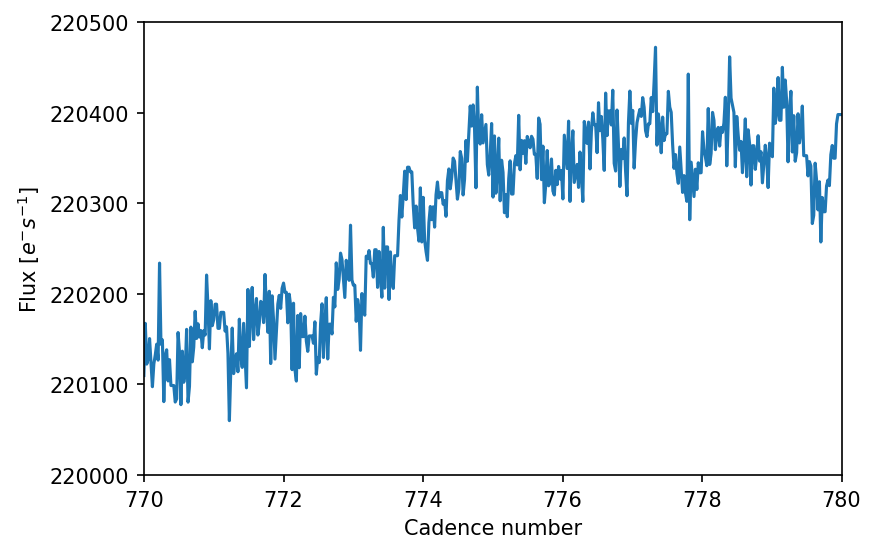

In [45]:
plt.plot(tabby.time, opt_params[:, 0])
plt.ylabel(r"Flux $[e^{-}s^{-1}]$")
plt.xlabel(r"Cadence number")
plt.xlim(770, 780)
plt.ylim(220000, 220500)

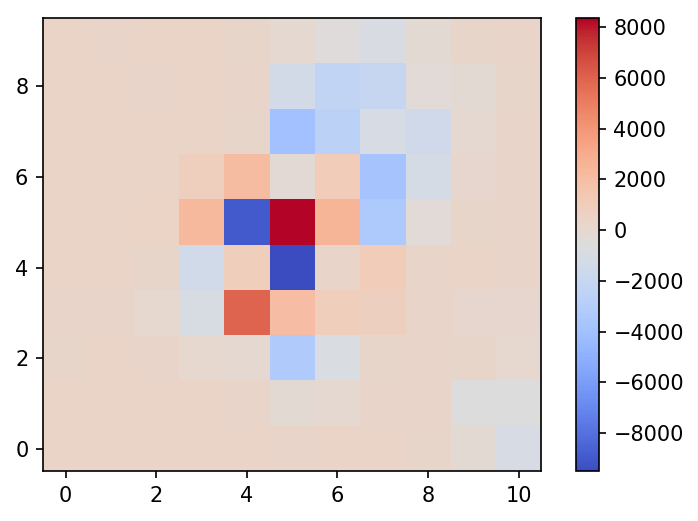

In [21]:
plt.imshow((sess.run(mean) - (tabby.flux[-1] + tabby.flux_bkg[-1])), cmap='coolwarm', origin='lower')
plt.colorbar()

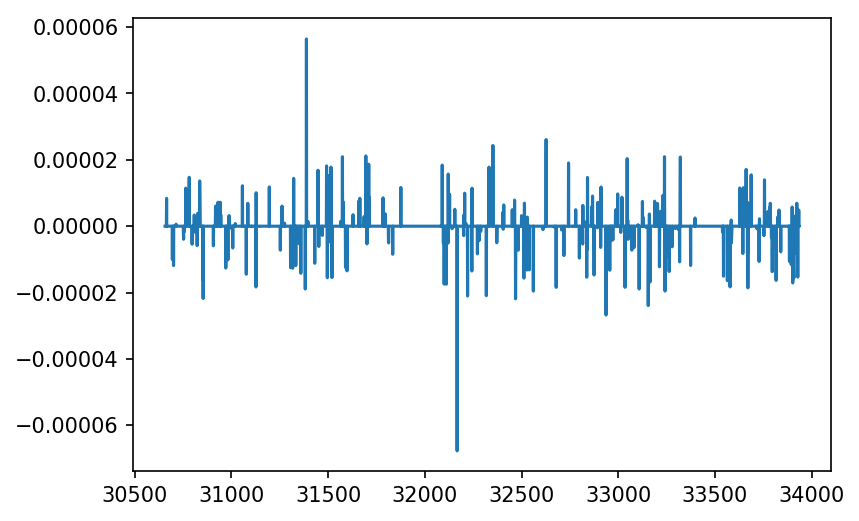

In [44]:
plt.plot(tabby.cadenceno, opt_grad[:, 0])